In [366]:
import os 
import sys
from tqdm import tqdm
import importlib
import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

module_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/"
data_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/data/long_seqs_v11/"
model_save_dir = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11'

if module_path not in sys.path:
    sys.path.append(module_path)

In [70]:
BATCH_SIZE = 256
N_DATA = 4000
T = 20
VOCAB = ['start', 'view', 'click', 'install']
EVENT_VOCAB_DIM = len(VOCAB)
EMB_DIM = 16
HIDDEN_DIM = 128

## Load Data

In [4]:
pos_data_path = os.path.join(data_path, 'positive_long_sequences.pickle')
# neg_data_path = os.path.join(data_path, 'negative_long_sequences.pickle')

def load_sequence_from_pickle_to_numpy(pickle_file_path, use_init_token=False):
    """
        A list of sequence in format of (event_type, time_delta)
    :param pickle_file_path: e.g. /.../project-basileus/seq-gan/data/fixed_length/valid_sequences.pickle
    :return: (event_type_seqs, time_delta)
    """
    with open(pickle_file_path, 'rb') as f:
        raw_seqs = pickle.load(f)

    if not raw_seqs or not raw_seqs[0]:
        return np.array([]), np.array([])

    N = len(raw_seqs)
    T = len(raw_seqs[0])
    
    seqs = np.array(raw_seqs)
        
    et_seqs = seqs[:, :, 0].astype(np.float64).reshape((N, T, 1))
    ts_seqs = seqs[:, :, 1].astype(np.float64).reshape((N, T, 1))
    
    return et_seqs, ts_seqs

raw_pos_event_type_seqs, raw_pos_timestamp_seqs = load_sequence_from_pickle_to_numpy(pos_data_path, use_init_token=False)

In [5]:
# cast indicator data into one-hot
pos_event_type_seqs = tf.cast(raw_pos_event_type_seqs, tf.int32)
pos_event_type_seqs = tf.one_hot(pos_event_type_seqs, depth=EVENT_VOCAB_DIM, axis=2, dtype=tf.float64)
pos_event_type_seqs = tf.squeeze(pos_event_type_seqs, axis=3)

In [252]:
def zcore_norm(data):
    N = data.shape[0]
    
    _mean = tf.reduce_mean(data, axis=0)
    _mean = tf.expand_dims(_mean, axis=0)
    _mean = tf.repeat(_mean, N, axis=0)

    _std = tf.math.reduce_std(data, axis=0)
    _std = tf.expand_dims(_std, axis=0)
    _std = tf.repeat(_std, N, axis=0)

    return (data - _mean) / _std, _mean[0,:,:], _std[0,:,:]

def get_mean_std(data):
    _mean = tf.reduce_mean(data, axis=0)
    _mean = tf.expand_dims(_mean, axis=0)

    _std = tf.math.reduce_std(data, axis=0)
    _std = tf.expand_dims(_std, axis=0)

    return _mean, _std

def apply_mean_std(data, _mean, _std):
    N = data.shape[0]
    
    _mean = tf.reshape(_mean, (1, T, 1))
    _mean = tf.repeat(_mean, N, axis=0)
    
    _std = tf.reshape(_std, (1, T, 1))
    _std = tf.repeat(_std, N, axis=0)
    
    return data * _std + _mean

pos_timestamp_seqs, GLOBAL_MEAN, GLOBAL_STD = zcore_norm(raw_pos_timestamp_seqs)

## Global Functions

In [35]:
def create_dataset(features: np.array, labels: np.array, batch_size=2, epochs=10, buffer_size=10000):
    """
    Create dataset from numpy arrays
    """
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

In [36]:
def generate_initial_noise(max_token=EVENT_VOCAB_DIM, time_mean=0, time_std=1):
    init_token_noise_index = tf.random.uniform(shape=[BATCH_SIZE, 1, 1], maxval=max_token, dtype=tf.int32)
    init_token_noise = tf.squeeze(tf.one_hot(init_token_noise_index, EVENT_VOCAB_DIM, axis=2, dtype=tf.float64), axis=3)
    init_time_noise = tf.random.truncated_normal(shape=[BATCH_SIZE, 1, 1], mean=time_mean, stddev=time_std, dtype=tf.float64)
    return init_token_noise, init_time_noise

In [301]:
from scipy.linalg import sqrtm

def calculate_FID_batch(batch1, batch2, weight=1, N=4000, T=20):
    batch1, batch2 = np.array(batch1).reshape((N, T)), np.array(batch2).reshape((N, T))
    mu1, sigma1 = batch1.mean(axis=0), np.cov(batch1, rowvar=False)
    mu2, sigma2 = batch2.mean(axis=0), np.cov(batch2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid2 = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid2

calculate_FID_score = lambda batch: calculate_FID_batch(raw_pos_timestamp_seqs, batch)
# calculate_FID_score(raw_pos_timestamp_seqs)

In [304]:
class MAD:
    """ Sum square of one-hot distance between tokens
    Params:
    -- batch1         : The first batch of sequences to be compared with the second one
                        or it can be the comparison base
    -- batch2
    Returns:
    --   : dict, sum square of distances and base medians
    """

    def __init__(self):
        self.base_ssad = []
        self.base_med = []
        self.base_med_oh = []
        self.one_hot_map = {0: [0, 0, 0, 0, 0],
                            1: [1, 0, 0, 0, 0],
                            2: [0, 1, 0, 0, 0],
                            3: [0, 0, 1, 0, 0]}

    def nan_if(self, arr, value):
        return np.where(arr == value, np.nan, arr)

    def fit(self, batch1):
        assert len(batch1) > 1, 'batch1 should have more than one sequence'
        X_tok = []
        for i in batch1:
            X_tok.append([j[0] for j in i])
        X_tok_t = np.array(X_tok).T
        X_tok_oh = [[self.one_hot_map[j] for j in i] for i in X_tok]
        medians = [int(i) for i in np.nanmedian(self.nan_if(X_tok_t, 0), axis=1)]
        medians_oh = [self.one_hot_map[j] for j in medians]
        self.base_med = medians
        self.base_med_oh = medians_oh
        tok_dist = []
        for tok in X_tok_oh:
            dist = []
            for j in range(len(tok)):
                tt = np.array(tok[j])
                med = np.array(medians_oh[j])
                # skip 0
                dist.append(np.nansum(np.abs(self.nan_if(tt, 0) - med)))
            tok_dist.append(dist)
        self.base_ssad = np.mean(tok_dist)

    def compare(self, batch2):
        assert len(batch2) > 1, 'batch2 should have more than one sequence'
        X_tok = []
        for i in batch2:
            X_tok.append([j[0] for j in i])
        X_tok_t = np.array(X_tok).T
        X_tok_oh = [[self.one_hot_map[j] for j in i] for i in X_tok]
        medians = [int(i) for i in np.nanmedian(self.nan_if(X_tok_t, 0), axis=1)]
        medians_oh = [self.one_hot_map[j] for j in medians]
        tok_dist = []
        for tok in X_tok_oh:
            dist = []
            for j in range(len(tok)):
                tt = np.array(tok[j])
                med = np.array(self.base_med_oh[j])
                # skip 0
                dist.append(np.nansum(np.abs(self.nan_if(tt, 0) - med)))
            tok_dist.append(dist)
        compare_ssd = np.mean(tok_dist)
        return {'mad': compare_ssd,
                'base_medians': np.array(self.base_med),
                'base_medians_oh': np.array(self.base_med_oh),
                'comp_medians': np.array(medians),
                'comp_medians_oh': np.array(medians_oh)}
    
mad_obj = MAD()
mad_obj.fit(raw_pos_event_type_seqs)
calculate_MAD_score = lambda batch: mad_obj.compare(batch)['mad']
# calculate_MAD_score(raw_pos_event_type_seqs)

In [307]:
EVENT_TYPES = ['A', 'B', 'C', 'D']
EVENT_ENCODE = {'A':0, 'B':1, 'C':2, 'D':3}

MIN_SAME_DELAY = 20
MAX_PAIR_DELAY = 200


def check_min_delay_rule(seq, use_init_token=False):
    if use_init_token:
        seq = seq[1:]
    prev_et, _ = None, 0.0
    for et, dt in seq:
        if et == prev_et and dt < MIN_SAME_DELAY:
            return False
        prev_et = et
    return True

def check_paring_rule(seq, use_init_token=False):
    if use_init_token:
        seq = seq[1:]    
    # one-pass: add D to queue to be attributed to the first available C in a reversed linear scanning
    queue = []
    for i in range(len(seq)-1, -1, -1):
        if seq[i][0] == EVENT_ENCODE['D']: # encounter a D event
            queue.append(i)
        elif seq[i][0] == EVENT_ENCODE['C'] and queue: # encounter a C event
            queue.pop(0)
    return len(queue) == 0

def check_max_delay_rule(seq, use_init_token=False):    
    if use_init_token:
        seq = seq[1:]    
        
    def recover_timedelta_to_timestamp(time_seq):
        csum = []
        curr = 0
        for dt in time_seq:
            if dt != 0:
                curr += dt
                csum.append(curr)
            else:
                csum.append(0)
        return csum
    
    ets = [e[0] for e in seq]
    tss = recover_timedelta_to_timestamp([e[1] for e in seq])
        
    # one-pass: add D to queue to be attributed to the first available C in a reversed linear scanning
    queue = []
    for i in range(len(seq)-1, -1, -1):
        if ets[i] == EVENT_ENCODE['D']: # encounter a D event
            queue.append(i)
        elif ets[i] == EVENT_ENCODE['C'] and queue: # encounter a C event
            if tss[queue[0]] - tss[i] <= MAX_PAIR_DELAY:
                queue.pop(0)
            else:
                return False
    # for rule 6, it's fine if there are unpaired D in queue
    # b/c this rules is to ensure for each paired (C, D), the delay is bounded
    return True


def calculate_rule_score(batch):
    N_batch = batch.shape[0]
    cnt = 0
    for i in range(N_batch):
        seq = batch[i, :, :]
        if check_min_delay_rule(seq) and check_paring_rule(seq) and check_max_delay_rule(seq):
            cnt += 1    
    return cnt / N_batch

# calculate_rule_score(batch)

In [312]:
# G0 = build_G(
#     batch_size = BATCH_SIZE,
#     event_vocab_dim = EVENT_VOCAB_DIM,
#     emb_dim = EMB_DIM,
#     hidden_dim= HIDDEN_DIM,
# )
# seqs_random_et, seqs_random_ts = generate_sequences_gumbel(4000, G0, BATCH_SIZE, T)

# seqs_random_et_ind = tf.argmax(seqs_random_et, axis=2).numpy().reshape((N_DATA, T, 1))
# seqs_random_ts_ori = apply_mean_std(seqs_random_ts, GLOBAL_MEAN, GLOBAL_STD)

# batch_for_rules = np.dstack((seqs_random_et_ind, seqs_random_ts_ori))

In [313]:
# _fid_score = calculate_FID_score( seqs_random_ts_ori)
# _mad_score = calculate_MAD_score(seqs_random_et_ind)
# _rule_score = calculate_rule_score(batch_for_rules)

# _fid_score, _mad_score, _rule_score 
# # (10892.375979306666, 0.5591, 0.09175)

## Create multitype SeqGan

In [132]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense, Dropout, Activation, Multiply, Add, Lambda
from tensorflow.keras import regularizers

from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

tf.keras.backend.set_floatx('float64')

def build_G(batch_size, event_vocab_dim, emb_dim, hidden_dim=16):
    # inputs of Time-LSTM:
    i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
    i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp

    embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
    merged0 = tf.concat([embed0, i_ts], axis=2)

    hm = LSTM(hidden_dim,
          name='lstm_token',
          stateful=True,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)

    
    tm = LSTM(hidden_dim,
          name='lstm_time',
          stateful=True,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)
    
    
    token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
    dense_combined = Dense(hidden_dim, 
                           activation='elu',
                           name='dense_combination')(token_time_comb)
        
    token_logits = Dense(event_vocab_dim,
                   activation='linear',
                   name='dense_token',
                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                   bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(dense_combined)
        
    time_delta_out = Dense(1,
                   activation='linear',
                   name='dense_time',
                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                   bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(dense_combined)
    
    generator = Model(
        inputs=[i_et, i_ts],
        outputs=[token_logits, time_delta_out])
        
    return generator

In [133]:
def build_D(batch_size, T, event_vocab_dim, emb_dim, hidden_dim, dropout_rate=0.25):
    # normal LSTM
    i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
    i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp
    
    embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
    merged0 = tf.concat([embed0, i_ts], axis=2)
    
    hm = LSTM(hidden_dim,
          name='lstm_token',
          stateful=False, # stateless, never input a partial sequnce for D
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)

    tm = LSTM(hidden_dim,
          name='lstm_time',
          stateful=False, # stateless, never input a partial sequnce for D
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)
    
    token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
    dropped = Dropout(rate=dropout_rate)(token_time_comb)
    
    prob = Dense(1, 
             activation='sigmoid',
             name='final',
             kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
             bias_initializer=tf.keras.initializers.Constant(value=0.1))(dropped)
        
    discriminator = Model(
        inputs=[i_et, i_ts],
        outputs=prob)
    return discriminator

In [134]:
# import tensorflow as tf
# from tensorflow.keras import backend as K
# from tensorflow.keras.models import Model
# from tensorflow.keras import Sequential
# from tensorflow.keras.optimizers import Adam, SGD
# from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense, Dropout, Activation, Multiply, Add, Lambda
# from tensorflow.keras import regularizers

# from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

# tf.keras.backend.set_floatx('float64')

# def build_G(batch_size, event_vocab_dim, emb_dim, hidden_dim=16):
#     # inputs of Time-LSTM:
#     i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
#     i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp

#     embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
#     merged0 = tf.concat([embed0, i_ts], axis=2)
    
#     hm, tm = TimeLSTM1(hidden_dim,
#                        name='time_lstm',
#                        stateful=True, 
#                        return_sequences=False,
#                        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        time_kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)    
        
#     token_logits = Dense(event_vocab_dim,
#                    activation='linear',
#                    name='dense_token',
#                    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                    bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(hm)
        
#     time_delta_out = Dense(1,
#                    activation='linear',
#                    name='dense_time',
#                    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                    bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(tm)
    
#     generator = Model(
#         inputs=[i_et, i_ts],
#         outputs=[token_logits, time_delta_out])
        
#     return generator

In [135]:
# def build_D(batch_size, T, event_vocab_dim, emb_dim, hidden_dim, dropout_rate=0.25):
#     # normal LSTM
#     i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
#     i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp
    
#     embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
#     merged0 = tf.concat([embed0, i_ts], axis=2)
    
#     hm, tm = TimeLSTM1(hidden_dim,
#                        name='time_lstm',
#                        stateful=True, 
#                        return_sequences=False,
#                        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        time_kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)
    
#     token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
#     dropped = Dropout(rate=dropout_rate)(token_time_comb)
    
#     prob = Dense(1, 
#              activation='sigmoid',
#              name='final',
#              kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
#              bias_initializer=tf.keras.initializers.Constant(value=0.1))(dropped)
        
#     discriminator = Model(
#         inputs=[i_et, i_ts],
#         outputs=prob)
#     return discriminator

## Define rollout and sequence generation

In [136]:
def sample_gumbel(shape, eps=1e-20): 
    U = tf.random.uniform(shape,minval=0,maxval=1)   #gumbel noise
#     print('noise:{}'.format(U))
    return -tf.math.log(-tf.math.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature=0.5): 
    y = logits + tf.cast(sample_gumbel(tf.shape(logits)), logits.dtype)
    return tf.nn.softmax( y / temperature)  # use softmax to approximate argmax

def gumbel_softmax(logits, temperature=0.5, hard=True):
    """Sample from the Gumbel-Softmax distribution and optionally discretize.
    Args:
    logits: [batch_size, n_class] unnormalized log-probs
    temperature: non-negative scalar
    hard: if True, take argmax, but differentiate w.r.t. soft sample y
    Returns:
    [batch_size, n_class] sample from the Gumbel-Softmax distribution.
    If hard=True, then the returned sample will be one-hot, otherwise it will
    be a probabilitiy distribution that sums to 1 across classes
    """
    logits = tf.cast(logits, tf.float64)
    y = gumbel_softmax_sample(logits, temperature) # this is differentiable
    if hard:
        k = tf.shape(logits)[-1]
        #y_hard = tf.cast(tf.one_hot(tf.argmax(y,1),k), y.dtype)
        y_hard = tf.cast(tf.equal(y,tf.reduce_max(y,1,keepdims=True)),y.dtype)
        y = tf.stop_gradient(y_hard - y) + y
    return y


In [394]:
def rollout_from_initial_gumbel(G, batch_size, init_et, init_ts, L=T):
    # Begin from dummy init state (init_token=1, init_timestamp=0.0)
    all_state_et = init_et
    all_state_ts = init_ts
    
    l_prefix = init_et.shape[1]
    
    G.reset_states()
    # LSTM-token
    G.layers[4].states[0] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
    G.layers[4].states[1] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
    # LSTM-time
    G.layers[5].states[0] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
    G.layers[5].states[1] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
    
    # Time-LSTM
#     G.layers[4].states[0] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
#     G.layers[4].states[1] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))

    for _ in range(L + 1 - l_prefix):  # sequence length
        curr_state_et = all_state_et[:, -1:, :]
        curr_state_ts = all_state_ts[:, -1:, :]
        
        # add step noise to token and time inputs
#         curr_state_et = tf.cast(tf.where(curr_state_et == 1, 0.9, 0.1/3), tf.float64)
#         curr_state_ts = curr_state_ts + tf.random.normal(shape=tf.shape(curr_state_ts), mean=0.0, stddev=1, dtype=tf.float64)

        token_logits, time_delta_out = G([curr_state_et, curr_state_ts])
        
        # sample event types using Gumbel-softmax
        sampled_et = gumbel_softmax(token_logits, temperature=0.9)  # this is differentiable
        sampled_et = tf.reshape(sampled_et, [batch_size, 1, EVENT_VOCAB_DIM])        
        sampled_et = tf.cast(sampled_et, dtype=tf.float64) # cast sampled_et into float
        
        time_delta_out = tf.reshape(time_delta_out, [batch_size, 1, 1]) 
        
        # Do NOT stop genererating once hit end_token; G is supposed to learn it.
        all_state_et = tf.concat([all_state_et, sampled_et], axis=1)
        all_state_ts = tf.concat([all_state_ts, time_delta_out], axis=1)

    # the initlal random states are excluded in output
    return all_state_et[:, 1:, :], all_state_ts[:, 1:, :]


def generate_sequences_gumbel(N_gen, generator, batch_size, T):
    """
        Generate sequences batch per batch
    :param N_gen: total number of seqs to be generated
    :param generator:
    :param batch_size:
    :param T:
    :return: a python list of shape [N_gen, T, 1]
    """
    N = 0
    all_type_seq = None
    all_time_seq = None
    
    init_token_noise, init_time_noise = generate_initial_noise()
        
    while N < N_gen:
        batch_state_et, batch_state_ts = rollout_from_initial_gumbel(generator, batch_size, init_token_noise, init_time_noise, T)

        if all_type_seq is None or all_time_seq is None:
            all_type_seq = batch_state_et
            all_time_seq = batch_state_ts
        else:
            all_type_seq = tf.concat([all_type_seq, batch_state_et], axis=0)
            all_time_seq = tf.concat([all_time_seq, batch_state_ts], axis=0)

        N += batch_size

    all_type_seq = all_type_seq[:N_gen, :, :]
    all_time_seq = all_time_seq[:N_gen, :, :]

    return all_type_seq, all_time_seq

## Pre-Training of Gumbel-Softmax SeqGan

In [395]:
def pretrain_discriminator(event_type_batch, time_delta_batch, label_batch, discriminator, verbose=False, optimizer=Adam(lr=0.001)):
    # train the discriminator
    with tf.GradientTape() as tape:
        # train discriminator
        true_prob = discriminator([event_type_batch, time_delta_batch])

        # cross-entropy loss
        discriminator_loss = ce_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(label_batch, true_prob, from_logits=False)
        )

        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return discriminator_loss


def pretrain_generator(event_type_batch, time_delta_batch, generator, verbose=False, optimizer=Adam(lr=0.001)):
    _, T, _ = event_type_batch.shape
    
    # train the generator
    with tf.GradientTape() as tape:
        generator.reset_states()
        step_token_ce_loss_list = []
        step_time_mxe_loss_list = []

        for i in range(0, T - 1):
            curr_state_et = event_type_batch[:, i:i + 1, :]
            curr_state_ts = time_delta_batch[:, i:i + 1, :]
            
            target_et = event_type_batch[:, i + 1, :]
            target_ts = time_delta_batch[:, i + 1, :]            
            
            token_logits, time_delta_out = generator([curr_state_et, curr_state_ts])

            token_ce_losses = tf.keras.losses.categorical_crossentropy(target_et, token_logits, from_logits=True)
            token_ce_loss = tf.reduce_mean(token_ce_losses)
            step_token_ce_loss_list.append(token_ce_loss)
            
            time_mxe_losses = tf.keras.losses.MAE(target_ts, time_delta_out)
            time_mxe_loss = tf.reduce_mean(time_mxe_losses)
            step_time_mxe_loss_list.append(time_mxe_loss)                        
    
        episode_token_ce_loss = tf.reduce_mean(step_token_ce_loss_list)
        episode_time_mxe_loss = tf.reduce_mean(step_time_mxe_loss_list)
        generator_loss = episode_token_ce_loss + episode_time_mxe_loss

    if verbose:
        print('token ce loss:{}'.format(episode_token_ce_loss))
        print('time mae loss:{}'.format(episode_time_mxe_loss))
        print('train loss:{}'.format(generator_loss))

    # apply gradient decent per batch
    grads = tape.gradient(generator_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    return generator_loss

### pre-train G

In [396]:
N_total_G = pos_event_type_seqs.shape[0]

EPOCHS = 3
_TOTAL_STEPS = int(EPOCHS * N_total_G / BATCH_SIZE)

pretrain_G_dataset = create_dataset((pos_event_type_seqs, pos_timestamp_seqs),
                                  np.ones((N_total_G, 1)),
                                  batch_size=BATCH_SIZE,
                                  epochs=EPOCHS,
                                  buffer_size=N_total_G)
_TOTAL_STEPS

46

In [397]:
pretrain_gen_loss_history = []

pretrained_generator = build_G(
    batch_size=BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM)

In [398]:
step = 0
OPTIMIZER = Adam(lr=1e-3)
# _TOTAL_STEPS = 100

for feature_batch, _ in tqdm(pretrain_G_dataset.take(_TOTAL_STEPS)):
    event_type_batch, time_delta_batch = feature_batch
    step += 1
    print('Training Step:', step)
        
    gen_loss =  pretrain_generator(event_type_batch, time_delta_batch, pretrained_generator, verbose=True, optimizer=OPTIMIZER)                    
    pretrain_gen_loss_history.append(gen_loss.numpy())

0it [00:00, ?it/s]

Training Step: 1
token ce loss:1.3624861682597897
time mae loss:0.7933820516645947
train loss:2.1558682199243844


1it [00:01,  1.10s/it]

Training Step: 2
token ce loss:1.3464183447310512
time mae loss:0.800165840812889
train loss:2.14658418554394


2it [00:02,  1.06s/it]

Training Step: 3
token ce loss:1.345406158060083
time mae loss:0.7819089470628653
train loss:2.127315105122948


3it [00:03,  1.05s/it]

Training Step: 4
token ce loss:1.3614449333850285
time mae loss:0.7974687253178723
train loss:2.1589136587029008


4it [00:04,  1.03s/it]

Training Step: 5
token ce loss:1.3371345308096116
time mae loss:0.7936407324888204
train loss:2.130775263298432


5it [00:04,  1.07it/s]

Training Step: 6
token ce loss:1.3351486725383064
time mae loss:0.7891620351642363
train loss:2.1243107077025427


6it [00:05,  1.17it/s]

Training Step: 7
token ce loss:1.3294847230968854
time mae loss:0.7874619424760866
train loss:2.116946665572972


7it [00:06,  1.24it/s]

Training Step: 8
token ce loss:1.3310917521749166
time mae loss:0.7881830262872839
train loss:2.1192747784622004


8it [00:07,  1.29it/s]

Training Step: 9
token ce loss:1.3272590164191032
time mae loss:0.7869503748405261
train loss:2.1142093912596294


9it [00:07,  1.33it/s]

Training Step: 10
token ce loss:1.3260862394013946
time mae loss:0.79303362523418
train loss:2.1191198646355747


10it [00:08,  1.35it/s]

Training Step: 11
token ce loss:1.3208022930265118
time mae loss:0.7787096238888126
train loss:2.0995119169153242


11it [00:09,  1.38it/s]

Training Step: 12
token ce loss:1.3144876121364122
time mae loss:0.7692998573446157
train loss:2.083787469481028


12it [00:09,  1.39it/s]

Training Step: 13
token ce loss:1.3150877187445633
time mae loss:0.7732428110335579
train loss:2.088330529778121


13it [00:10,  1.40it/s]

Training Step: 14
token ce loss:1.3153255289796961
time mae loss:0.7827506035845863
train loss:2.0980761325642825


14it [00:11,  1.41it/s]

Training Step: 15
token ce loss:1.3081406223428562
time mae loss:0.7823711992721446
train loss:2.0905118216150007


15it [00:11,  1.41it/s]

Training Step: 16
token ce loss:1.3144535891695062
time mae loss:0.7821753224804979
train loss:2.0966289116500043


16it [00:12,  1.41it/s]

Training Step: 17
token ce loss:1.3065225133157647
time mae loss:0.7855225400917935
train loss:2.092045053407558


17it [00:13,  1.41it/s]

Training Step: 18
token ce loss:1.3128849548827994
time mae loss:0.7881079998059715
train loss:2.100992954688771


18it [00:14,  1.22it/s]

Training Step: 19
token ce loss:1.306293280670132
time mae loss:0.7834404188922596
train loss:2.0897336995623914


19it [00:15,  1.28it/s]

Training Step: 20
token ce loss:1.306695922653185
time mae loss:0.7755680963228566
train loss:2.0822640189760415


20it [00:15,  1.32it/s]

Training Step: 21
token ce loss:1.3005395169359941
time mae loss:0.7712855554475224
train loss:2.0718250723835165


21it [00:16,  1.35it/s]

Training Step: 22
token ce loss:1.303197187157092
time mae loss:0.7835795585652438
train loss:2.086776745722336


22it [00:17,  1.37it/s]

Training Step: 23
token ce loss:1.3028853977188786
time mae loss:0.7687620437342455
train loss:2.0716474414531243


23it [00:17,  1.39it/s]

Training Step: 24
token ce loss:1.3002561062691043
time mae loss:0.7883167000030571
train loss:2.088572806272161


24it [00:18,  1.40it/s]

Training Step: 25
token ce loss:1.3003754469025417
time mae loss:0.7902841297680576
train loss:2.0906595766705993


25it [00:19,  1.41it/s]

Training Step: 26
token ce loss:1.2985135183044432
time mae loss:0.7798265134650773
train loss:2.07834003176952


26it [00:20,  1.41it/s]

Training Step: 27
token ce loss:1.2920987105625432
time mae loss:0.7806992804468679
train loss:2.072797991009411


27it [00:20,  1.42it/s]

Training Step: 28
token ce loss:1.2914034561427699
time mae loss:0.778518464883314
train loss:2.0699219210260837


28it [00:21,  1.42it/s]

Training Step: 29
token ce loss:1.2901848714702597
time mae loss:0.7731300342694767
train loss:2.0633149057397366


29it [00:22,  1.42it/s]

Training Step: 30
token ce loss:1.2904301243452607
time mae loss:0.784634852944522
train loss:2.0750649772897827


30it [00:22,  1.43it/s]

Training Step: 31
token ce loss:1.2911990301244243
time mae loss:0.7789546116238318
train loss:2.0701536417482562


31it [00:23,  1.42it/s]

Training Step: 32
token ce loss:1.2901476488185941
time mae loss:0.7725863797544905
train loss:2.0627340285730846


32it [00:24,  1.42it/s]

Training Step: 33
token ce loss:1.2930997495507592
time mae loss:0.7861774936656081
train loss:2.0792772432163673


33it [00:24,  1.42it/s]

Training Step: 34
token ce loss:1.2902271422750327
time mae loss:0.77941945171574
train loss:2.0696465939907727


34it [00:25,  1.41it/s]

Training Step: 35
token ce loss:1.2930278891565559
time mae loss:0.7685052333765845
train loss:2.0615331225331404


35it [00:26,  1.42it/s]

Training Step: 36
token ce loss:1.2854590712568268
time mae loss:0.7835736539968181
train loss:2.0690327252536447


36it [00:27,  1.42it/s]

Training Step: 37
token ce loss:1.2851257767405357
time mae loss:0.7774414177352386
train loss:2.062567194475774


37it [00:27,  1.42it/s]

Training Step: 38
token ce loss:1.2855982544736408
time mae loss:0.7817971439754585
train loss:2.0673953984490994


38it [00:28,  1.42it/s]

Training Step: 39
token ce loss:1.2850074025469909
time mae loss:0.7866048696554765
train loss:2.0716122722024672


39it [00:29,  1.43it/s]

Training Step: 40
token ce loss:1.282586848192818
time mae loss:0.7787326620271342
train loss:2.061319510219952


40it [00:29,  1.43it/s]

Training Step: 41
token ce loss:1.2826462946531616
time mae loss:0.7865052867252864
train loss:2.0691515813784482


41it [00:30,  1.43it/s]

Training Step: 42
token ce loss:1.2806275296605831
time mae loss:0.7761097949585133
train loss:2.0567373246190965


42it [00:31,  1.43it/s]

Training Step: 43
token ce loss:1.282599671564317
time mae loss:0.7855893393642323
train loss:2.0681890109285495


43it [00:32,  1.43it/s]

Training Step: 44
token ce loss:1.2780495781827832
time mae loss:0.7706243621637521
train loss:2.0486739403465353


44it [00:32,  1.43it/s]

Training Step: 45
token ce loss:1.2758115725074848
time mae loss:0.7778409592733647
train loss:2.0536525317808496


45it [00:33,  1.43it/s]

Training Step: 46
token ce loss:1.2845823951038093
time mae loss:0.7762119640156806
train loss:2.06079435911949


46it [00:34,  1.35it/s]


In [399]:
if not os.path.exists(model_save_dir + '/pretrained_gen_weights'):
    os.makedirs(model_save_dir + '/pretrained_gen_weights')

G_save_path = model_save_dir + '/pretrained_gen_weights/model.tf'
pretrained_generator.save_weights(G_save_path)

In [400]:
reload_pretrained_gen = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

reload_pretrained_gen.build(input_shape=((BATCH_SIZE, T, 1)))
reload_pretrained_gen.load_weights(G_save_path)
reload_pretrained_gen.summary()

Model: "model_88"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(256, None, 4)]     0                                            
__________________________________________________________________________________________________
dense_emb (Dense)               (256, None, 16)      80          event_type[0][0]                 
__________________________________________________________________________________________________
time_delta_in (InputLayer)      [(256, None, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_concat_88 (TensorFl [(256, None, 17)]    0           dense_emb[0][0]                  
                                                                 time_delta_in[0][0]       

### pre-train D

In [401]:
N_fake_D = N_real_D = N_total_G 

In [402]:
# generate fake data by G to pre-train D
fake_pos_event_type_seqs, fake_pos_timestamp_seqs = generate_sequences_gumbel(N_fake_D, pretrained_generator, BATCH_SIZE, T)

In [403]:
# generate fake data by G to pre-train D
real_pos_event_type_seqs = pos_event_type_seqs[0:N_real_D, :, :]
real_pos_timestamp_seqs = pos_timestamp_seqs[0:N_real_D, :, :]

In [404]:
N_total_D = N_fake_D + N_real_D

pretrain_D_et = tf.concat([fake_pos_event_type_seqs, real_pos_event_type_seqs], axis=0)
pretrain_D_ts = tf.concat([fake_pos_timestamp_seqs, real_pos_timestamp_seqs], axis=0)
pretrain_D_labels = tf.concat([np.zeros((N_fake_D, 1)), np.ones((N_real_D, 1))], axis=0)

EPOCHS = 1
_TOTAL_STEPS = int(EPOCHS * N_total_D / BATCH_SIZE)

pretrain_D_dataset = create_dataset((pretrain_D_et, pretrain_D_ts),
                                    pretrain_D_labels,
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS,
                                    buffer_size=N_total_D) # shuffle the entire Dataset

In [405]:
pretrain_disc_token_loss_history = []

pretrained_discriminator = build_D(batch_size=BATCH_SIZE,
                                   T=T,
                                   event_vocab_dim=EVENT_VOCAB_DIM,
                                   emb_dim=EMB_DIM,
                                   hidden_dim=HIDDEN_DIM,    
                                   dropout_rate=0.25)

In [406]:
step = 0
OPTIMIZER = Adam(lr=1e-3)
_TOTAL_STEPS = 10

for feature_batch, labels in tqdm(pretrain_D_dataset.take(_TOTAL_STEPS)):
    event_type_batch, time_delta_batch = feature_batch
    step += 1
    print('Training Step:', step)

    disc_token_loss = pretrain_discriminator(event_type_batch, time_delta_batch, labels, pretrained_discriminator, verbose=True, optimizer=OPTIMIZER)
    pretrain_disc_token_loss_history.append(disc_token_loss.numpy())

0it [00:00, ?it/s]

Training Step: 1
total discriminator loss:0.6976283057356374


1it [00:00,  2.47it/s]

Training Step: 2
total discriminator loss:0.6793890989318796


2it [00:00,  2.61it/s]

Training Step: 3
total discriminator loss:0.6602426516022948


3it [00:01,  2.66it/s]

Training Step: 4
total discriminator loss:0.644000659359381


4it [00:01,  2.68it/s]

Training Step: 5
total discriminator loss:0.6212101729455993


5it [00:01,  2.68it/s]

Training Step: 6
total discriminator loss:0.6118884884891373


6it [00:02,  2.69it/s]

Training Step: 7
total discriminator loss:0.5788361964544678


7it [00:02,  2.70it/s]

Training Step: 8
total discriminator loss:0.5502111904393405


8it [00:02,  2.71it/s]

Training Step: 9
total discriminator loss:0.5830561004836661


9it [00:03,  2.71it/s]

Training Step: 10
total discriminator loss:0.554752193774391


10it [00:03,  2.68it/s]


In [407]:
if not os.path.exists(model_save_dir + '/pretrained_disc_weights'):
    os.makedirs(model_save_dir + '/pretrained_disc_weights')

D_save_path = model_save_dir + '/pretrained_disc_weights/model.tf'
pretrained_discriminator.save_weights(D_save_path)

In [408]:
reload_pretrained_disc = build_D(
    batch_size=BATCH_SIZE,
    T=T,
    event_vocab_dim=EVENT_VOCAB_DIM,
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,    
    dropout_rate=0.25)

reload_pretrained_disc.build(input_shape=((BATCH_SIZE, T, 1)))
reload_pretrained_disc.load_weights(D_save_path)
reload_pretrained_disc.summary()

Model: "model_90"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(256, None, 4)]     0                                            
__________________________________________________________________________________________________
dense_emb (Dense)               (256, None, 16)      80          event_type[0][0]                 
__________________________________________________________________________________________________
time_delta_in (InputLayer)      [(256, None, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_concat_90 (TensorFl [(256, None, 17)]    0           dense_emb[0][0]                  
                                                                 time_delta_in[0][0]       

## Gumbel  Traning

In [409]:
def train_generator_gumbel(generator, discriminator, batch_size, T, verbose=False,                   
                    optimizer=Adam(lr=0.001)):
    
    with tf.GradientTape() as tape:                        

        G_sample_et, G_sample_ts = generate_sequences_gumbel(batch_size, generator, batch_size, T)
        D_fake = discriminator([G_sample_et, G_sample_ts])

        generator_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(D_fake), D_fake))
        
    if verbose:
        print('generator loss:{}'.format(generator_loss))
        print('-----------------------')

    # update generator
    generator_grads = tape.gradient(generator_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

    return generator_loss


def train_discriminator_gumbel(real_data_batch_et, real_data_batch_ts, generator, discriminator, batch_size, T, verbose=False,
                        optimizer=Adam(lr=0.001), label_smoothing=False, label_flipping=False):

    # data prep
    real_labels = tf.ones((batch_size//2, 1))        
    fake_labels = tf.zeros((batch_size//2, 1))    
    
    real_data_batch_et, real_data_batch_ts = real_data_batch_et[:batch_size//2, :, :], real_data_batch_ts[:batch_size//2, :, :]    
    fake_data_batch_et, fake_data_batch_ts = generate_sequences_gumbel(batch_size//2, generator, batch_size, T)
    
    if label_smoothing:
        fake_labels = fake_labels + tf.random.normal(fake_labels.shape, mean=0, stddev=0.3)
        fake_labels = tf.clip_by_value(fake_labels, clip_value_min=0., clip_value_max=0.3)

        real_labels = real_labels + tf.random.normal(real_labels.shape, mean=0, stddev=0.3)
        real_labels = tf.clip_by_value(real_labels, clip_value_min=0.7, clip_value_max=1.0)

    if label_flipping:
        if tf.random.uniform((1,)) < 0.05:
            fake_labels, real_labels = real_labels, fake_labels
    
    total_data_et = tf.concat([fake_data_batch_et, real_data_batch_et], axis=0)
    total_data_ts = tf.concat([fake_data_batch_ts, real_data_batch_ts], axis=0)
    total_labels = tf.concat([fake_labels, real_labels], axis=0)        
        
    # train the discriminator
    with tf.GradientTape() as tape:                                                           
        # train discriminator
        pred_prob = discriminator([total_data_et, total_data_ts])

        # cross-entropy loss
        discriminator_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(total_labels, pred_prob, from_logits=False))

        # average true return
        average_true_return = tf.reduce_mean(pred_prob)
        
        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))
            print('average true return:{}'.format(average_true_return))
            print('-----------------------')

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return discriminator_loss, average_true_return

In [410]:
def track_training(step, G, save_path=None, verbose=True, plot=True):
    _gen_seqs_et, _gen_seqs_ts = generate_sequences_gumbel(N_DATA, G, BATCH_SIZE, T)
    
    # convert one-hot event types to indices; convert normalized timestamps to original
    _gen_seqs_et_ind = tf.argmax(_gen_seqs_et, axis=2).numpy().reshape(N_DATA, T, 1)
    _gen_seqs_ts_ori = apply_mean_std(_gen_seqs_ts, GLOBAL_MEAN, GLOBAL_STD)
    _gen_seqs_for_rules = np.dstack((_gen_seqs_et_ind, _gen_seqs_ts_ori))
    
    _mad_score = calculate_MAD_score(_gen_seqs_et_ind)
    _fid_score = calculate_FID_score(_gen_seqs_ts_ori)
    _rule_score = calculate_rule_score(_gen_seqs_for_rules)

    if verbose:
        print('event_types:', _gen_seqs_et_ind[0,:, :].squeeze().tolist())
        print('mad_score:', _mad_score)
        print('fid_score:', _fid_score)
        print('rule_score:', _rule_score)

    if plot:
        plt.figure()
        x = np.arange(_gen_seqs_et[0,:,:].shape[0])
        y = _gen_seqs_ts[0,:,:]
        plt.plot(x, y)
        plt.title(f'wave shape after {step} steps')
        plt.show()

    if save_path:     
        G_save_path = os.path.join(save_path, f'G_{step}', 'model_weights.tf')
        G.save_weights(G_save_path)
        print('G saved to:', G_save_path)

        D_save_path = os.path.join(save_path, f'D_{step}', 'model_weights.tf')
        D.save_weights(D_save_path)
        print('D saved to:', D_save_path)
        
    return _mad_score, _fid_score, _rule_score

In [411]:
G_save_path = model_save_dir + '/pretrained_gen_weights/model.tf'
D_save_path = model_save_dir + '/pretrained_disc_weights/model.tf'

G = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

G.build(input_shape=((BATCH_SIZE, T, 1)))
G.load_weights(G_save_path)
G.summary()

D = build_D(
    batch_size=BATCH_SIZE,
    T=T,
    event_vocab_dim=EVENT_VOCAB_DIM,
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,    
    dropout_rate=0.25)

D.build(input_shape=((BATCH_SIZE, T, 1)))
D.load_weights(D_save_path)
D.summary()

Model: "model_91"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(256, None, 4)]     0                                            
__________________________________________________________________________________________________
dense_emb (Dense)               (256, None, 16)      80          event_type[0][0]                 
__________________________________________________________________________________________________
time_delta_in (InputLayer)      [(256, None, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_concat_91 (TensorFl [(256, None, 17)]    0           dense_emb[0][0]                  
                                                                 time_delta_in[0][0]       

In [412]:
N_total_G = pos_event_type_seqs.shape[0]

EPOCHS = 100
_TOTAL_STEPS = int(EPOCHS * N_total_G / BATCH_SIZE)


train_dataset = create_dataset((pos_event_type_seqs, pos_timestamp_seqs),
                             np.ones((N_total_G, 1)),
                             batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             buffer_size=N_total_G)

gen_loss_history = []
disc_loss_history = []
average_true_return_history = []
mad_history = []
fid_history = []
rule_history = []

step = 0

G_optimizer = Adam(learning_rate=1e-4)
D_optimizer = Adam(learning_rate=1e-4)

_G_STEPS = 1
_D_STEPS = 1

now_str = datetime.strftime(datetime.now(), format='%Y-%m-%d-%H-%M-%S')
model_save_path = os.path.join(model_save_dir, now_str)
print(model_save_path)
print(_TOTAL_STEPS)

/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43
1562


0it [00:00, ?it/s]

Training Step: 0
event_types: [3, 1, 2, 1, 2, 0, 1, 2, 3, 0, 3, 2, 0, 2, 2, 0, 1, 3, 2, 1]
mad_score: 0.434375
fid_score: 9679.247143554925
rule_score: 0.5545


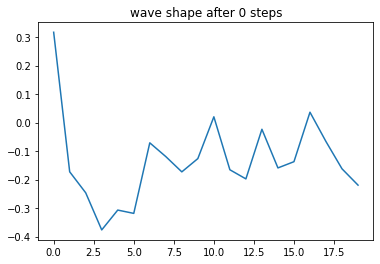

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_0/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_0/model_weights.tf
generator loss:1.0932595065251747
-----------------------


1it [00:11, 11.13s/it]

total discriminator loss:0.5888820237273446
average true return:0.5140072063947458
-----------------------
Training Step: 1
generator loss:1.0240954089408856
-----------------------


2it [00:13,  5.71s/it]

total discriminator loss:0.6293810130005479
average true return:0.5168430537636813
-----------------------
Training Step: 2
generator loss:1.028352596291359
-----------------------


3it [00:14,  3.98s/it]

total discriminator loss:0.6202376709545497
average true return:0.5176991814278096
-----------------------
Training Step: 3
generator loss:0.93933945262432
-----------------------


4it [00:16,  3.17s/it]

total discriminator loss:0.6632843345903834
average true return:0.5088121212795352
-----------------------
Training Step: 4
generator loss:0.9105032666713108
-----------------------


5it [00:18,  2.72s/it]

total discriminator loss:0.6568446354692857
average true return:0.520463957550053
-----------------------
Training Step: 5
event_types: [3, 0, 3, 2, 1, 0, 2, 2, 0, 1, 2, 1, 2, 3, 1, 3, 2, 2, 1, 2]
mad_score: 0.429675
fid_score: 9114.022680620847
rule_score: 0.5355


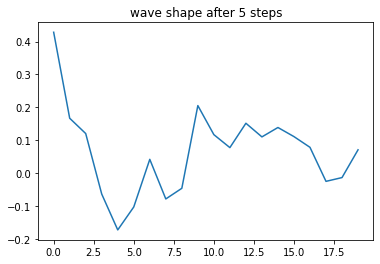

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_5/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_5/model_weights.tf
generator loss:0.871864759629777
-----------------------


6it [00:29,  5.58s/it]

total discriminator loss:0.7350918462573264
average true return:0.5007534388097155
-----------------------
Training Step: 6
generator loss:0.8025278714388435
-----------------------


7it [00:31,  4.40s/it]

total discriminator loss:0.757155435683335
average true return:0.5069512412629279
-----------------------
Training Step: 7
generator loss:0.7700572639439838
-----------------------


8it [00:33,  3.62s/it]

total discriminator loss:0.7777159667762762
average true return:0.5147780153216777
-----------------------
Training Step: 8
generator loss:0.7097073882632612
-----------------------


9it [00:35,  3.09s/it]

total discriminator loss:0.7949245929464034
average true return:0.517849292985634
-----------------------
Training Step: 9
generator loss:0.6920071947538249
-----------------------


10it [00:37,  2.73s/it]

total discriminator loss:0.8397544310606235
average true return:0.5132982911361822
-----------------------
Training Step: 10
event_types: [1, 2, 2, 0, 1, 2, 0, 3, 2, 0, 2, 1, 3, 1, 2, 2, 1, 0, 2, 3]
mad_score: 0.4277875
fid_score: 9639.456474136648
rule_score: 0.524


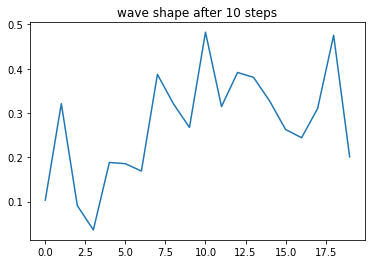

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_10/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_10/model_weights.tf
generator loss:0.6353873107361883
-----------------------


11it [00:49,  5.39s/it]

total discriminator loss:0.865773470390612
average true return:0.514659776640275
-----------------------
Training Step: 11
generator loss:0.6144083174715913
-----------------------


12it [00:51,  4.33s/it]

total discriminator loss:0.8906929242011435
average true return:0.5051755685469524
-----------------------
Training Step: 12
generator loss:0.5774649700130229
-----------------------


13it [00:52,  3.60s/it]

total discriminator loss:0.906966588377738
average true return:0.5257494241477445
-----------------------
Training Step: 13
generator loss:0.5596086416641022
-----------------------


14it [00:54,  3.10s/it]

total discriminator loss:0.9455071227596337
average true return:0.4989707460954814
-----------------------
Training Step: 14
generator loss:0.5204324133832863
-----------------------


15it [00:56,  2.74s/it]

total discriminator loss:0.9649403755521373
average true return:0.5224129956158383
-----------------------
Training Step: 15
event_types: [2, 0, 3, 2, 0, 2, 3, 0, 2, 2, 0, 2, 3, 2, 3, 1, 3, 3, 2, 2]
mad_score: 0.4214
fid_score: 11216.459508668862
rule_score: 0.48675


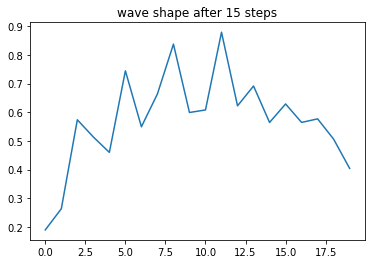

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_15/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_15/model_weights.tf
generator loss:0.5144220289931807
-----------------------


16it [01:07,  5.26s/it]

total discriminator loss:0.9385540931616757
average true return:0.5173038674510531
-----------------------
Training Step: 16
generator loss:0.4811261299299646
-----------------------


17it [01:09,  4.26s/it]

total discriminator loss:0.9836718604204076
average true return:0.5230079072076191
-----------------------
Training Step: 17
generator loss:0.4561412892179888
-----------------------


18it [01:11,  3.56s/it]

total discriminator loss:0.9701934484956438
average true return:0.527232869784354
-----------------------
Training Step: 18
generator loss:0.4457540267387594
-----------------------


19it [01:13,  3.07s/it]

total discriminator loss:0.998671922654699
average true return:0.5245823424647454
-----------------------
Training Step: 19
generator loss:0.4282306682870477
-----------------------


20it [01:15,  2.72s/it]

total discriminator loss:1.0187107955144743
average true return:0.5219404025655028
-----------------------
Training Step: 20
event_types: [2, 1, 3, 2, 0, 2, 1, 2, 0, 1, 3, 0, 0, 2, 0, 2, 2, 2, 3, 0]
mad_score: 0.4192
fid_score: 13793.579052454226
rule_score: 0.477


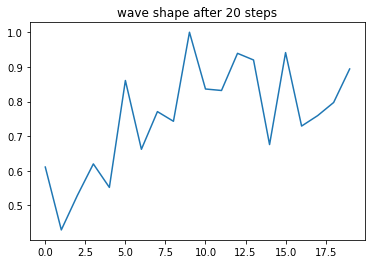

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_20/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_20/model_weights.tf
generator loss:0.41916651294753693
-----------------------


21it [01:26,  5.23s/it]

total discriminator loss:0.5149871267095263
average true return:0.5271291716387102
-----------------------
Training Step: 21
generator loss:0.41420507305560417
-----------------------


22it [01:28,  4.24s/it]

total discriminator loss:1.0272334753317178
average true return:0.5300793719553522
-----------------------
Training Step: 22
generator loss:0.4148828278829399
-----------------------


23it [01:30,  3.54s/it]

total discriminator loss:1.0243240604443147
average true return:0.5315823343122783
-----------------------
Training Step: 23
generator loss:0.40645799833395635
-----------------------


24it [01:32,  3.06s/it]

total discriminator loss:1.006205463531459
average true return:0.525961986563006
-----------------------
Training Step: 24
generator loss:0.4118161402438224
-----------------------


25it [01:34,  2.72s/it]

total discriminator loss:1.0264388972932892
average true return:0.5287357443563536
-----------------------
Training Step: 25
event_types: [1, 1, 2, 2, 3, 1, 2, 0, 2, 2, 3, 1, 2, 2, 0, 1, 2, 3, 0, 1]
mad_score: 0.4141375
fid_score: 17179.96664840987
rule_score: 0.48575


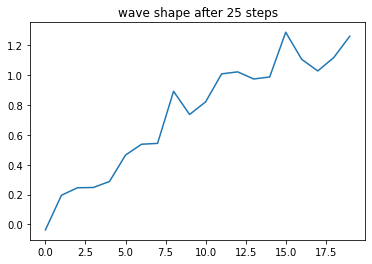

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_25/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_25/model_weights.tf
generator loss:0.39716514897571875
-----------------------


26it [01:45,  5.21s/it]

total discriminator loss:1.0134649713748418
average true return:0.5257572504414789
-----------------------
Training Step: 26
generator loss:0.40083642119133045
-----------------------


27it [01:47,  4.22s/it]

total discriminator loss:0.9875867753384187
average true return:0.5314367520959067
-----------------------
Training Step: 27
generator loss:0.4077571850406527
-----------------------


28it [01:49,  3.53s/it]

total discriminator loss:1.0041822396933757
average true return:0.5292159540679886
-----------------------
Training Step: 28
generator loss:0.4108546313260627
-----------------------


29it [01:51,  3.05s/it]

total discriminator loss:1.0075568880892876
average true return:0.5277370735342115
-----------------------
Training Step: 29
generator loss:0.4133864199934548
-----------------------


30it [01:53,  2.71s/it]

total discriminator loss:0.9841944020508556
average true return:0.5283213407083467
-----------------------
Training Step: 30
event_types: [2, 0, 2, 1, 2, 2, 2, 0, 1, 1, 2, 1, 2, 2, 0, 2, 1, 0, 2, 0]
mad_score: 0.408575
fid_score: 21165.921469609708
rule_score: 0.42175


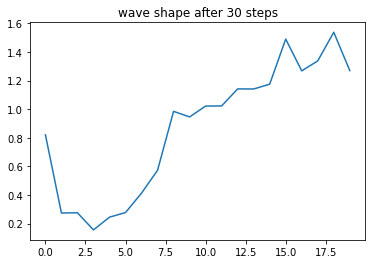

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_30/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_30/model_weights.tf
generator loss:0.4209139535554239
-----------------------


31it [02:04,  5.21s/it]

total discriminator loss:0.9606238969673055
average true return:0.5302781167947119
-----------------------
Training Step: 31
generator loss:0.4289922284062031
-----------------------


32it [02:06,  4.23s/it]

total discriminator loss:0.9674820821074792
average true return:0.521261590257481
-----------------------
Training Step: 32
generator loss:0.43342980145168636
-----------------------


33it [02:08,  3.54s/it]

total discriminator loss:0.9571161678656553
average true return:0.5260659395332429
-----------------------
Training Step: 33
generator loss:0.4463527235916245
-----------------------


34it [02:09,  3.06s/it]

total discriminator loss:0.9427815647304463
average true return:0.5276366524183121
-----------------------
Training Step: 34
generator loss:0.44992732884757025
-----------------------


35it [02:11,  2.72s/it]

total discriminator loss:0.9099551563981711
average true return:0.5290599481341254
-----------------------
Training Step: 35
event_types: [1, 0, 3, 2, 1, 0, 3, 0, 1, 2, 2, 2, 0, 0, 2, 1, 0, 1, 0, 2]
mad_score: 0.4007
fid_score: 25727.223657150535
rule_score: 0.40575


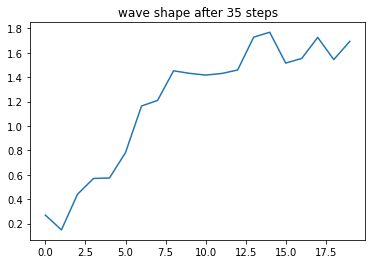

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_35/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_35/model_weights.tf
generator loss:0.45875506271487465
-----------------------


36it [02:22,  5.21s/it]

total discriminator loss:0.9087953757271175
average true return:0.5219781712211422
-----------------------
Training Step: 36
generator loss:0.48088772024305326
-----------------------


37it [02:24,  4.23s/it]

total discriminator loss:0.8893152409002327
average true return:0.5237124882120999
-----------------------
Training Step: 37
generator loss:0.489547165811582
-----------------------


38it [02:26,  3.54s/it]

total discriminator loss:0.8793692978494824
average true return:0.5238007574281247
-----------------------
Training Step: 38
generator loss:0.5058199394339287
-----------------------


39it [02:29,  3.17s/it]

total discriminator loss:0.856711082384952
average true return:0.5185082351719494
-----------------------
Training Step: 39
generator loss:0.5150500705972996
-----------------------


40it [02:31,  2.80s/it]

total discriminator loss:0.8574025827092768
average true return:0.5154999258430071
-----------------------
Training Step: 40
event_types: [1, 0, 3, 2, 2, 2, 2, 0, 3, 2, 2, 3, 1, 2, 2, 0, 1, 2, 0, 1]
mad_score: 0.3970125
fid_score: 30615.03232146534
rule_score: 0.41025


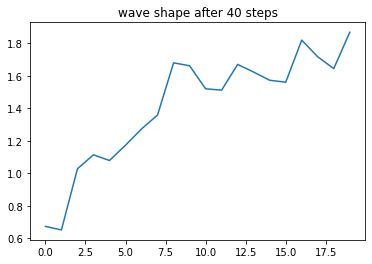

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_40/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_40/model_weights.tf
generator loss:0.5331024673626881
-----------------------


41it [02:42,  5.29s/it]

total discriminator loss:0.8278558181508601
average true return:0.5150082626310875
-----------------------
Training Step: 41
generator loss:0.547563370800063
-----------------------


42it [02:44,  4.28s/it]

total discriminator loss:0.8110667465362422
average true return:0.5118730865177334
-----------------------
Training Step: 42
generator loss:0.5732621539572273
-----------------------


43it [02:45,  3.57s/it]

total discriminator loss:0.7986524130819135
average true return:0.5102917459495928
-----------------------
Training Step: 43
generator loss:0.5900669681181001
-----------------------


44it [02:47,  3.08s/it]

total discriminator loss:0.7841462145938751
average true return:0.5091711238116086
-----------------------
Training Step: 44
generator loss:0.6037013662776222
-----------------------


45it [02:49,  2.74s/it]

total discriminator loss:0.7729694238650116
average true return:0.5030304090069324
-----------------------
Training Step: 45
event_types: [2, 0, 3, 1, 0, 1, 0, 2, 2, 1, 0, 2, 3, 0, 0, 2, 2, 1, 1, 1]
mad_score: 0.39255
fid_score: 35547.43273760355
rule_score: 0.40375


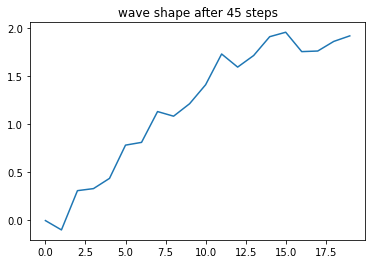

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_45/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_45/model_weights.tf
generator loss:0.6225019196625415
-----------------------


46it [03:00,  5.23s/it]

total discriminator loss:0.757327998131886
average true return:0.5007148254284967
-----------------------
Training Step: 46
generator loss:0.6426293963435776
-----------------------


47it [03:02,  4.24s/it]

total discriminator loss:0.7415240494970248
average true return:0.4981599791868548
-----------------------
Training Step: 47
generator loss:0.6683930827431059
-----------------------


48it [03:04,  3.55s/it]

total discriminator loss:0.7222351516855275
average true return:0.4983383764417224
-----------------------
Training Step: 48
generator loss:0.6868220009270989
-----------------------


49it [03:06,  3.06s/it]

total discriminator loss:0.7107948001865214
average true return:0.49430851026206857
-----------------------
Training Step: 49
generator loss:0.7115287406573803
-----------------------


50it [03:08,  2.72s/it]

total discriminator loss:0.6987584021367577
average true return:0.49313095351343655
-----------------------
Training Step: 50
event_types: [2, 1, 0, 2, 1, 2, 3, 2, 3, 1, 2, 2, 2, 2, 2, 1, 0, 2, 1, 0]
mad_score: 0.39045
fid_score: 40129.67682484526
rule_score: 0.4


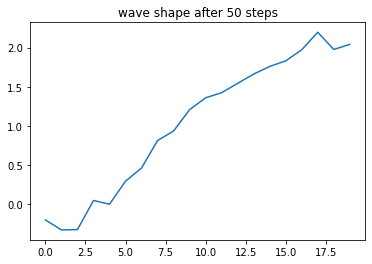

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_50/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_50/model_weights.tf
generator loss:0.7317237239343829
-----------------------


51it [03:19,  5.23s/it]

total discriminator loss:0.6802224988729967
average true return:0.489630989919551
-----------------------
Training Step: 51
generator loss:0.7530666642038806
-----------------------


52it [03:21,  4.25s/it]

total discriminator loss:0.6677229094707099
average true return:0.48702253988538746
-----------------------
Training Step: 52
generator loss:0.7768776909929241
-----------------------


53it [03:23,  3.55s/it]

total discriminator loss:0.6550572128529625
average true return:0.4858472959157323
-----------------------
Training Step: 53
generator loss:0.8040910905464922
-----------------------


54it [03:25,  3.07s/it]

total discriminator loss:0.6431856362549091
average true return:0.48302376948534653
-----------------------
Training Step: 54
generator loss:0.8224559110267174
-----------------------


55it [03:27,  2.72s/it]

total discriminator loss:0.6259929518932867
average true return:0.48383814170099404
-----------------------
Training Step: 55
event_types: [0, 3, 0, 2, 1, 0, 2, 2, 3, 2, 0, 2, 1, 0, 3, 0, 2, 3, 2, 3]
mad_score: 0.3879625
fid_score: 43629.890357001495
rule_score: 0.37875


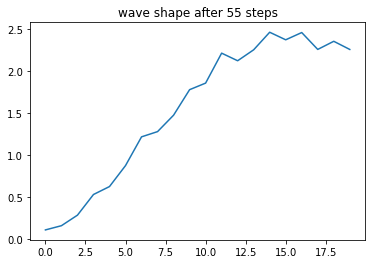

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_55/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_55/model_weights.tf
generator loss:0.8480567797257577
-----------------------


56it [03:38,  5.23s/it]

total discriminator loss:0.6132405371359226
average true return:0.4812107885705464
-----------------------
Training Step: 56
generator loss:0.8702965987950039
-----------------------


57it [03:40,  4.24s/it]

total discriminator loss:0.6048846068463769
average true return:0.4809920470399812
-----------------------
Training Step: 57
generator loss:0.88865563514499
-----------------------


58it [03:42,  3.55s/it]

total discriminator loss:0.5881271143010387
average true return:0.47888888782466044
-----------------------
Training Step: 58
generator loss:0.912692452790539
-----------------------


59it [03:44,  3.06s/it]

total discriminator loss:0.5745331165063906
average true return:0.48014645777088544
-----------------------
Training Step: 59
generator loss:0.9269629354420416
-----------------------


60it [03:46,  2.72s/it]

total discriminator loss:0.5689713015125146
average true return:0.4810116827651156
-----------------------
Training Step: 60
event_types: [2, 2, 0, 1, 2, 3, 1, 1, 1, 0, 2, 3, 2, 1, 0, 2, 3, 3, 2, 1]
mad_score: 0.3874375
fid_score: 44833.392126996034
rule_score: 0.3685


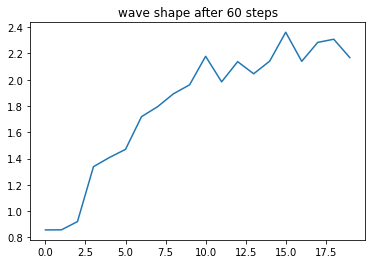

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_60/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_60/model_weights.tf
generator loss:0.9506385261192527
-----------------------


61it [03:57,  5.21s/it]

total discriminator loss:0.5609540212660689
average true return:0.47946842997629147
-----------------------
Training Step: 61
generator loss:0.9721284676878712
-----------------------


62it [03:59,  4.23s/it]

total discriminator loss:0.5589979997151082
average true return:0.47947545955952525
-----------------------
Training Step: 62
generator loss:0.9843795288600565
-----------------------


63it [04:01,  3.54s/it]

total discriminator loss:0.537643193680497
average true return:0.4830093363528988
-----------------------
Training Step: 63
generator loss:1.0113200798079949
-----------------------


64it [04:03,  3.06s/it]

total discriminator loss:0.5281268736811436
average true return:0.482548634215584
-----------------------
Training Step: 64
generator loss:1.0201921424146123
-----------------------


65it [04:04,  2.72s/it]

total discriminator loss:0.5241290447738294
average true return:0.4855943860167604
-----------------------
Training Step: 65
event_types: [0, 0, 1, 2, 0, 2, 2, 3, 1, 0, 0, 2, 1, 0, 2, 3, 3, 3, 1, 3]
mad_score: 0.38645
fid_score: 42788.97067584999
rule_score: 0.377


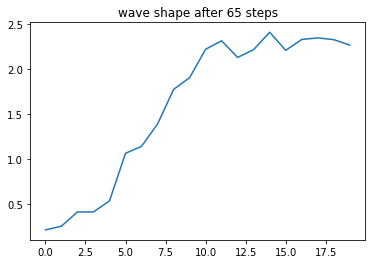

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_65/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_65/model_weights.tf
generator loss:1.0324173928729172
-----------------------


66it [04:16,  5.35s/it]

total discriminator loss:0.5150652776120503
average true return:0.48784408791842065
-----------------------
Training Step: 66
generator loss:1.050476364112427
-----------------------


67it [04:18,  4.33s/it]

total discriminator loss:0.5032298511408663
average true return:0.48856445710904606
-----------------------
Training Step: 67
generator loss:1.0626480327680738
-----------------------


68it [04:20,  3.61s/it]

total discriminator loss:0.49407002184726534
average true return:0.4869100025409481
-----------------------
Training Step: 68
generator loss:1.0739169516085836
-----------------------


69it [04:22,  3.10s/it]

total discriminator loss:0.5001155180861938
average true return:0.4932035758456618
-----------------------
Training Step: 69
generator loss:1.0822198008726125
-----------------------


70it [04:24,  2.75s/it]

total discriminator loss:0.47819761719010156
average true return:0.49961379379543536
-----------------------
Training Step: 70
event_types: [0, 1, 2, 0, 2, 3, 1, 2, 1, 1, 0, 2, 1, 1, 1, 2, 1, 3, 2, 1]
mad_score: 0.3905625
fid_score: 37715.07110098817
rule_score: 0.35375


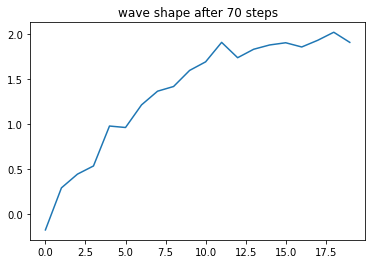

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_70/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_70/model_weights.tf
generator loss:1.075314211669133
-----------------------


71it [04:35,  5.26s/it]

total discriminator loss:0.4973165276332151
average true return:0.49635278390818616
-----------------------
Training Step: 71
generator loss:1.0878803166058484
-----------------------


72it [04:37,  4.26s/it]

total discriminator loss:0.47620668964751345
average true return:0.5028324403843437
-----------------------
Training Step: 72
generator loss:1.0976186469334688
-----------------------


73it [04:39,  3.56s/it]

total discriminator loss:0.4807525567292078
average true return:0.5074041274940444
-----------------------
Training Step: 73
generator loss:1.0848981535346256
-----------------------


74it [04:41,  3.07s/it]

total discriminator loss:0.47817209234649327
average true return:0.5057849632356715
-----------------------
Training Step: 74
generator loss:1.1103518799762397
-----------------------


75it [04:43,  2.73s/it]

total discriminator loss:0.48725996425517204
average true return:0.5159357978644462
-----------------------
Training Step: 75
event_types: [1, 0, 1, 2, 2, 3, 1, 2, 2, 1, 2, 1, 3, 0, 2, 2, 2, 2, 3, 2]
mad_score: 0.3867
fid_score: 30992.93722874372
rule_score: 0.37225


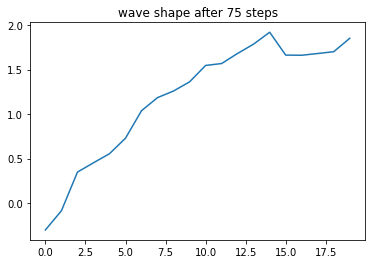

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_75/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_75/model_weights.tf
generator loss:1.0975200550305262
-----------------------


76it [04:54,  5.23s/it]

total discriminator loss:0.47159527492015985
average true return:0.5178373141649533
-----------------------
Training Step: 76
generator loss:1.1084639863875798
-----------------------


77it [04:56,  4.24s/it]

total discriminator loss:0.4690674902212324
average true return:0.5207210583909185
-----------------------
Training Step: 77
generator loss:1.0886369873920931
-----------------------


78it [04:57,  3.54s/it]

total discriminator loss:0.47021577697945893
average true return:0.5196601919210047
-----------------------
Training Step: 78
generator loss:1.0929685412613588
-----------------------


79it [04:59,  3.06s/it]

total discriminator loss:0.4560545685056651
average true return:0.5225231000200451
-----------------------
Training Step: 79
generator loss:1.1032508679241353
-----------------------


80it [05:01,  2.72s/it]

total discriminator loss:0.4629612942887941
average true return:0.5238632912984567
-----------------------
Training Step: 80
event_types: [1, 0, 3, 1, 0, 2, 0, 0, 2, 2, 0, 1, 0, 2, 3, 0, 1, 1, 0, 3]
mad_score: 0.387275
fid_score: 23915.4385900611
rule_score: 0.4035


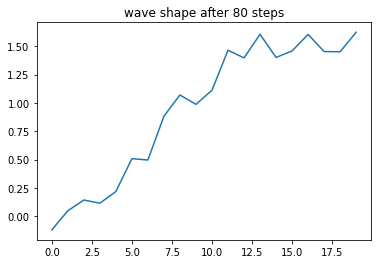

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_80/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_80/model_weights.tf
generator loss:1.0950690947098807
-----------------------


81it [05:12,  5.22s/it]

total discriminator loss:0.46272827970662944
average true return:0.5234766960667101
-----------------------
Training Step: 81
generator loss:1.0759216030891374
-----------------------


82it [05:14,  4.23s/it]

total discriminator loss:0.4685348496555437
average true return:0.5280552944453178
-----------------------
Training Step: 82
generator loss:1.0699511197271852
-----------------------


83it [05:16,  3.54s/it]

total discriminator loss:0.47239929705180683
average true return:0.5285712904446032
-----------------------
Training Step: 83
generator loss:1.0753038679191023
-----------------------


84it [05:18,  3.06s/it]

total discriminator loss:0.4768212112121416
average true return:0.5325164694190833
-----------------------
Training Step: 84
generator loss:1.069909127390477
-----------------------


85it [05:20,  2.72s/it]

total discriminator loss:0.4884118249463976
average true return:0.5298297280233073
-----------------------
Training Step: 85
event_types: [3, 2, 0, 3, 2, 2, 0, 0, 2, 0, 1, 0, 2, 2, 3, 1, 2, 0, 2, 1]
mad_score: 0.3815375
fid_score: 17915.472341128323
rule_score: 0.48125


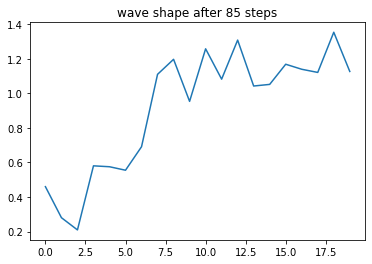

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_85/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_85/model_weights.tf
generator loss:1.0579893813756966
-----------------------


86it [05:31,  5.22s/it]

total discriminator loss:0.4857906851654985
average true return:0.5245648582465374
-----------------------
Training Step: 86
generator loss:1.0681442062726942
-----------------------


87it [05:33,  4.24s/it]

total discriminator loss:0.49376320974338617
average true return:0.5281568291925294
-----------------------
Training Step: 87
generator loss:1.0426711426488358
-----------------------


88it [05:35,  3.55s/it]

total discriminator loss:0.4864164962366835
average true return:0.5200092263342648
-----------------------
Training Step: 88
generator loss:1.0504020814939512
-----------------------


89it [05:37,  3.07s/it]

total discriminator loss:0.49326349513722134
average true return:0.5210602902964392
-----------------------
Training Step: 89
generator loss:1.036693222029878
-----------------------


90it [05:39,  2.74s/it]

total discriminator loss:0.5027318264153119
average true return:0.5279002683854128
-----------------------
Training Step: 90
event_types: [1, 2, 0, 1, 2, 1, 2, 2, 0, 1, 2, 1, 0, 2, 0, 2, 2, 2, 0, 1]
mad_score: 0.3796
fid_score: 13461.765268574367
rule_score: 0.50925


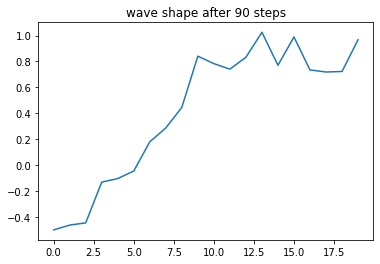

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_90/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_90/model_weights.tf
generator loss:1.0281368853656905
-----------------------


91it [05:50,  5.24s/it]

total discriminator loss:0.5189642039962662
average true return:0.52594337542114
-----------------------
Training Step: 91
generator loss:0.9886031652967919
-----------------------


92it [05:52,  4.24s/it]

total discriminator loss:0.5197385716316947
average true return:0.5243539596899912
-----------------------
Training Step: 92
generator loss:1.0032443808910383
-----------------------


93it [05:54,  3.55s/it]

total discriminator loss:0.5153660240433713
average true return:0.5316150424113039
-----------------------
Training Step: 93
generator loss:0.9645999503483091
-----------------------


94it [05:56,  3.18s/it]

total discriminator loss:0.5533930671587842
average true return:0.5137799102571301
-----------------------
Training Step: 94
generator loss:0.9570146044051104
-----------------------


95it [05:58,  2.81s/it]

total discriminator loss:0.5571176904211179
average true return:0.5149375829014763
-----------------------
Training Step: 95
event_types: [3, 2, 0, 0, 3, 2, 1, 0, 1, 2, 0, 1, 2, 2, 3, 3, 1, 0, 2, 0]
mad_score: 0.3702625
fid_score: 10565.245536468075
rule_score: 0.5715


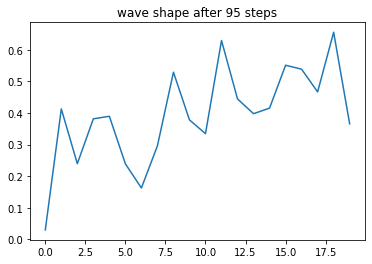

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_95/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_95/model_weights.tf
generator loss:0.9386389799442749
-----------------------


96it [06:09,  5.30s/it]

total discriminator loss:0.5663090937875488
average true return:0.5148557239123066
-----------------------
Training Step: 96
generator loss:0.9328791919906606
-----------------------


97it [06:11,  4.29s/it]

total discriminator loss:0.575605313172968
average true return:0.4997517318784788
-----------------------
Training Step: 97
generator loss:0.944860126024563
-----------------------


98it [06:13,  3.58s/it]

total discriminator loss:0.5984534861089438
average true return:0.5002424215279191
-----------------------
Training Step: 98
generator loss:0.8935570079313746
-----------------------


99it [06:15,  3.08s/it]

total discriminator loss:0.6091381496801225
average true return:0.5053929756533717
-----------------------
Training Step: 99
generator loss:0.8759416232441416
-----------------------


100it [06:17,  2.74s/it]

total discriminator loss:0.6273075614682438
average true return:0.5004688772891448
-----------------------
Training Step: 100
event_types: [2, 1, 1, 0, 2, 2, 2, 1, 0, 2, 1, 1, 2, 0, 2, 0, 2, 2, 0, 2]
mad_score: 0.363375
fid_score: 9126.804765169807
rule_score: 0.60225


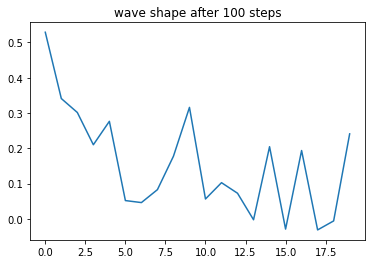

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_100/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_100/model_weights.tf
generator loss:0.8686397848608727
-----------------------


101it [06:28,  5.24s/it]

total discriminator loss:0.6656909722030828
average true return:0.49521046586159523
-----------------------
Training Step: 101
generator loss:0.8279026836637406
-----------------------


102it [06:30,  4.24s/it]

total discriminator loss:0.6947406101254878
average true return:0.49339032717411435
-----------------------
Training Step: 102
generator loss:0.8005379276883111
-----------------------


103it [06:32,  3.54s/it]

total discriminator loss:0.6877614460759645
average true return:0.4837276309583205
-----------------------
Training Step: 103
generator loss:0.7862076790831931
-----------------------


104it [06:34,  3.06s/it]

total discriminator loss:0.7350983945833469
average true return:0.4796936037440553
-----------------------
Training Step: 104
generator loss:0.761867526786086
-----------------------


105it [06:36,  2.72s/it]

total discriminator loss:0.7188320709994904
average true return:0.4948237621397978
-----------------------
Training Step: 105
event_types: [2, 2, 0, 2, 2, 2, 3, 2, 1, 2, 0, 2, 0, 1, 0, 1, 0, 1, 1, 2]
mad_score: 0.356725
fid_score: 8982.588587916547
rule_score: 0.62575


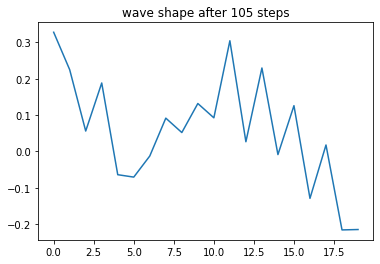

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_105/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_105/model_weights.tf
generator loss:0.7520715708382573
-----------------------


106it [06:47,  5.19s/it]

total discriminator loss:0.7416464034407213
average true return:0.4881512713574354
-----------------------
Training Step: 106
generator loss:0.7011532566194425
-----------------------


107it [06:49,  4.21s/it]

total discriminator loss:0.7799047839673907
average true return:0.48297361538176037
-----------------------
Training Step: 107
generator loss:0.7060676539965554
-----------------------


108it [06:50,  3.52s/it]

total discriminator loss:0.8012399836017413
average true return:0.48202380838679726
-----------------------
Training Step: 108
generator loss:0.6775685042571242
-----------------------


109it [06:52,  3.04s/it]

total discriminator loss:0.8125677267730655
average true return:0.48364522978687496
-----------------------
Training Step: 109
generator loss:0.6937170917552875
-----------------------


110it [06:54,  2.71s/it]

total discriminator loss:0.8497624005430433
average true return:0.46530579827043034
-----------------------
Training Step: 110
event_types: [2, 0, 3, 2, 2, 0, 2, 3, 3, 2, 2, 0, 1, 0, 2, 2, 3, 3, 3, 1]
mad_score: 0.3493625
fid_score: 10001.161336517893
rule_score: 0.63975


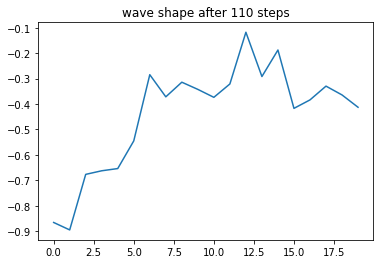

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_110/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_110/model_weights.tf
generator loss:0.66080882985068
-----------------------


111it [07:05,  5.22s/it]

total discriminator loss:0.8270350593135001
average true return:0.4654913923346782
-----------------------
Training Step: 111
generator loss:0.6615414819175383
-----------------------


112it [07:07,  4.24s/it]

total discriminator loss:0.8552138778628189
average true return:0.4699009420848811
-----------------------
Training Step: 112
generator loss:0.6619241679231282
-----------------------


113it [07:09,  3.54s/it]

total discriminator loss:0.8665726454442517
average true return:0.4648134752287808
-----------------------
Training Step: 113
generator loss:0.6716500998900209
-----------------------


114it [07:11,  3.06s/it]

total discriminator loss:0.8368248515891471
average true return:0.4619511592717984
-----------------------
Training Step: 114
generator loss:0.6677168674330454
-----------------------


115it [07:13,  2.72s/it]

total discriminator loss:0.8410363775395293
average true return:0.4603815822855084
-----------------------
Training Step: 115
event_types: [2, 1, 2, 2, 1, 1, 2, 3, 2, 2, 1, 3, 2, 3, 2, 0, 2, 2, 0, 1]
mad_score: 0.3417375
fid_score: 11950.383728425286
rule_score: 0.405


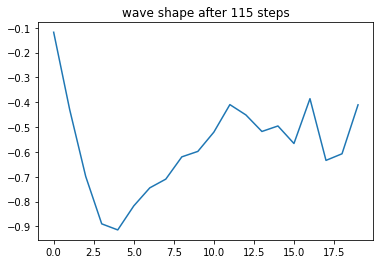

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_115/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_115/model_weights.tf
generator loss:0.6708575735505357
-----------------------


116it [07:24,  5.20s/it]

total discriminator loss:0.8232902378001525
average true return:0.45382927624296654
-----------------------
Training Step: 116
generator loss:0.687403840613895
-----------------------


117it [07:26,  4.22s/it]

total discriminator loss:0.824464632956838
average true return:0.4503764623692182
-----------------------
Training Step: 117
generator loss:0.6953223692276143
-----------------------


118it [07:28,  3.53s/it]

total discriminator loss:0.8100982404172443
average true return:0.4426604931574848
-----------------------
Training Step: 118
generator loss:0.7113927959291058
-----------------------


119it [07:30,  3.05s/it]

total discriminator loss:0.8247846815622745
average true return:0.4413874585915086
-----------------------
Training Step: 119
generator loss:0.7395751253862924
-----------------------


120it [07:32,  2.71s/it]

total discriminator loss:0.7869339606532837
average true return:0.4387005395480363
-----------------------
Training Step: 120
event_types: [0, 1, 3, 0, 2, 2, 3, 0, 2, 1, 2, 3, 2, 0, 1, 3, 2, 0, 2, 1]
mad_score: 0.3357
fid_score: 14534.76783136792
rule_score: 0.08075


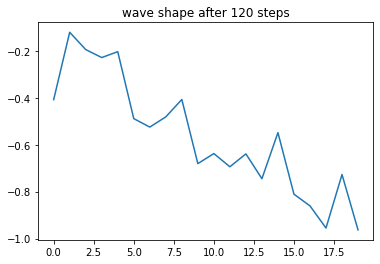

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_120/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_120/model_weights.tf
generator loss:0.7711024870768388
-----------------------


121it [07:43,  5.25s/it]

total discriminator loss:0.7682299186796712
average true return:0.4309234580654851
-----------------------
Training Step: 121
generator loss:0.7793016393159456
-----------------------


122it [07:45,  4.25s/it]

total discriminator loss:0.754556194157631
average true return:0.4295185539232027
-----------------------
Training Step: 122
generator loss:0.8212291987529289
-----------------------


123it [07:47,  3.55s/it]

total discriminator loss:0.7357178116984009
average true return:0.4289482744788514
-----------------------
Training Step: 123
generator loss:0.8528364732529812
-----------------------


124it [07:49,  3.06s/it]

total discriminator loss:0.722858482068504
average true return:0.4214625151715674
-----------------------
Training Step: 124
generator loss:0.8844301767299585
-----------------------


125it [07:51,  2.72s/it]

total discriminator loss:0.7093498009264608
average true return:0.4207253498667918
-----------------------
Training Step: 125
event_types: [1, 2, 2, 1, 1, 2, 2, 2, 3, 2, 0, 1, 2, 2, 1, 0, 0, 1, 3, 2]
mad_score: 0.3316375
fid_score: 17159.653053773396
rule_score: 0.0455


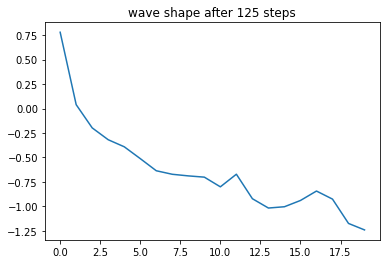

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_125/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_125/model_weights.tf
generator loss:0.9200914247975683
-----------------------


126it [08:02,  5.17s/it]

total discriminator loss:0.6827562824080384
average true return:0.4148192153666137
-----------------------
Training Step: 126
generator loss:0.9534243099719458
-----------------------


127it [08:03,  4.20s/it]

total discriminator loss:0.662068750338124
average true return:0.41364225283765393
-----------------------
Training Step: 127
generator loss:0.9772840093886295
-----------------------


128it [08:05,  3.51s/it]

total discriminator loss:0.6537926512552823
average true return:0.417304941815417
-----------------------
Training Step: 128
generator loss:1.0116686241120703
-----------------------


129it [08:07,  3.04s/it]

total discriminator loss:0.6318980915162722
average true return:0.41267152276468905
-----------------------
Training Step: 129
generator loss:1.0455144365977649
-----------------------


130it [08:09,  2.70s/it]

total discriminator loss:0.61883910283363
average true return:0.41895872783447297
-----------------------
Training Step: 130
event_types: [1, 1, 2, 0, 1, 0, 2, 2, 0, 2, 2, 0, 2, 0, 0, 1, 0, 2, 1, 0]
mad_score: 0.325225
fid_score: 18828.936764161335
rule_score: 0.04325


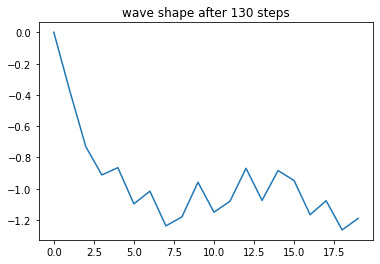

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_130/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_130/model_weights.tf
generator loss:1.0802213475411042
-----------------------


131it [08:20,  5.14s/it]

total discriminator loss:0.6127263498512985
average true return:0.4196689417528867
-----------------------
Training Step: 131
generator loss:1.0917965220034833
-----------------------


132it [08:22,  4.18s/it]

total discriminator loss:0.595244208202296
average true return:0.41792387830341693
-----------------------
Training Step: 132
generator loss:1.1165705846994112
-----------------------


133it [08:24,  3.50s/it]

total discriminator loss:0.5785104351686922
average true return:0.42029340237050294
-----------------------
Training Step: 133
generator loss:1.1137736799327875
-----------------------


134it [08:26,  3.03s/it]

total discriminator loss:0.5766385635887601
average true return:0.4209325821237907
-----------------------
Training Step: 134
generator loss:1.1372598678074253
-----------------------


135it [08:28,  2.70s/it]

total discriminator loss:0.558736660981053
average true return:0.4300988688017646
-----------------------
Training Step: 135
event_types: [2, 2, 2, 0, 1, 2, 1, 2, 3, 0, 2, 0, 2, 0, 0, 1, 2, 3, 2, 2]
mad_score: 0.32765
fid_score: 19499.629023767942
rule_score: 0.045


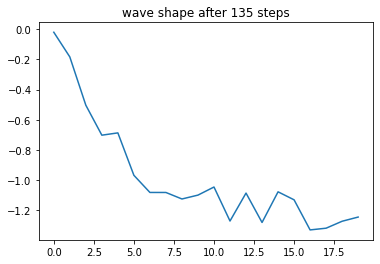

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_135/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_135/model_weights.tf
generator loss:1.1231314962258807
-----------------------


136it [08:39,  5.13s/it]

total discriminator loss:0.924451018810911
average true return:0.4355577729971161
-----------------------
Training Step: 136
generator loss:1.114713335958928
-----------------------


137it [08:41,  4.17s/it]

total discriminator loss:0.5421134080149518
average true return:0.43986305566830136
-----------------------
Training Step: 137
generator loss:1.131499041459194
-----------------------


138it [08:42,  3.49s/it]

total discriminator loss:0.5330065002056503
average true return:0.4443600989732688
-----------------------
Training Step: 138
generator loss:1.1115580111069323
-----------------------


139it [08:44,  3.02s/it]

total discriminator loss:0.542177779204422
average true return:0.45095449589313913
-----------------------
Training Step: 139
generator loss:1.1175247792663847
-----------------------


140it [08:46,  2.69s/it]

total discriminator loss:0.9423275378160975
average true return:0.4557341153078244
-----------------------
Training Step: 140
event_types: [0, 1, 1, 1, 2, 0, 1, 2, 0, 0, 1, 0, 2, 2, 2, 3, 2, 1, 1, 0]
mad_score: 0.3329625
fid_score: 19027.67852941488
rule_score: 0.05625


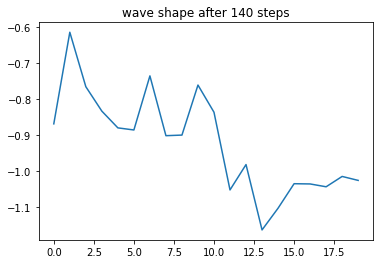

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_140/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_140/model_weights.tf
generator loss:1.1167983319808874
-----------------------


141it [08:57,  5.14s/it]

total discriminator loss:0.5257532269215994
average true return:0.4666751491655414
-----------------------
Training Step: 141
generator loss:1.0746903957062943
-----------------------


142it [08:59,  4.17s/it]

total discriminator loss:0.5206835453340968
average true return:0.4742751978575971
-----------------------
Training Step: 142
generator loss:1.0677299294836682
-----------------------


143it [09:01,  3.50s/it]

total discriminator loss:0.5132662689662741
average true return:0.47987505502509464
-----------------------
Training Step: 143
generator loss:1.0396952446736007
-----------------------


144it [09:03,  3.02s/it]

total discriminator loss:0.5153016647174485
average true return:0.48545238366707844
-----------------------
Training Step: 144
generator loss:1.0548404435476475
-----------------------


145it [09:05,  2.69s/it]

total discriminator loss:0.5059006011819155
average true return:0.49320485758054133
-----------------------
Training Step: 145
event_types: [2, 1, 2, 1, 2, 1, 0, 3, 1, 2, 1, 0, 2, 2, 0, 2, 2, 2, 1, 2]
mad_score: 0.3373875
fid_score: 17648.419271753737
rule_score: 0.06175


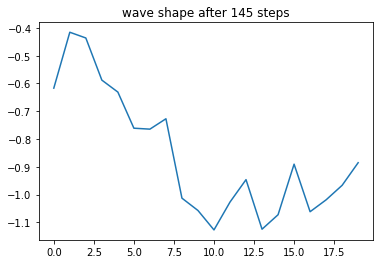

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_145/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_145/model_weights.tf
generator loss:1.0463715746607916
-----------------------


146it [09:16,  5.15s/it]

total discriminator loss:0.5202542966270456
average true return:0.4923423599740916
-----------------------
Training Step: 146
generator loss:1.026895742409492
-----------------------


147it [09:18,  4.18s/it]

total discriminator loss:0.5060863946200074
average true return:0.49900078431568595
-----------------------
Training Step: 147
generator loss:1.0109850987408573
-----------------------


148it [09:20,  3.51s/it]

total discriminator loss:0.5129857238928054
average true return:0.5093927182570327
-----------------------
Training Step: 148
generator loss:0.9892366386223531
-----------------------


149it [09:22,  3.15s/it]

total discriminator loss:0.5160410022647373
average true return:0.5173835954803319
-----------------------
Training Step: 149
generator loss:0.983072913950378
-----------------------


150it [09:24,  2.79s/it]

total discriminator loss:0.513567502550698
average true return:0.5186921501003856
-----------------------
Training Step: 150
event_types: [1, 0, 2, 1, 2, 2, 2, 2, 3, 0, 1, 0, 0, 3, 1, 0, 2, 0, 0, 1]
mad_score: 0.3445125
fid_score: 15809.271120973535
rule_score: 0.109


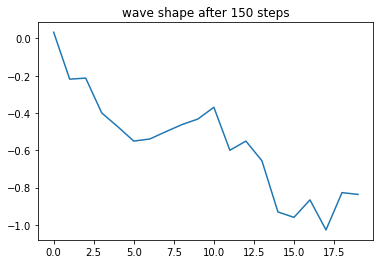

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_150/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_150/model_weights.tf
generator loss:0.9886089625356259
-----------------------


151it [09:35,  5.22s/it]

total discriminator loss:0.5093721548258258
average true return:0.5239799013692393
-----------------------
Training Step: 151
generator loss:0.9568449014679687
-----------------------


152it [09:37,  4.23s/it]

total discriminator loss:0.5096066970214725
average true return:0.5344738232318413
-----------------------
Training Step: 152
generator loss:0.9613214849872898
-----------------------


153it [09:39,  3.54s/it]

total discriminator loss:0.5156232804755961
average true return:0.5305086340947563
-----------------------
Training Step: 153
generator loss:0.9566294308480924
-----------------------


154it [09:40,  3.06s/it]

total discriminator loss:0.5213763266732214
average true return:0.5322274320088842
-----------------------
Training Step: 154
generator loss:0.9413461970281026
-----------------------


155it [09:42,  2.72s/it]

total discriminator loss:0.5133014325682976
average true return:0.5403440374571843
-----------------------
Training Step: 155
event_types: [1, 0, 2, 3, 1, 2, 1, 0, 2, 0, 3, 0, 1, 0, 1, 0, 2, 3, 1, 0]
mad_score: 0.3502
fid_score: 13700.70495362653
rule_score: 0.2135


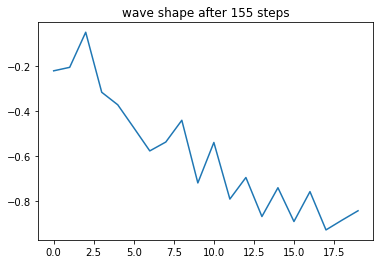

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_155/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_155/model_weights.tf
generator loss:0.9268719897661735
-----------------------


156it [09:53,  5.15s/it]

total discriminator loss:0.519771373893432
average true return:0.5366449372191393
-----------------------
Training Step: 156
generator loss:0.9120886359939919
-----------------------


157it [09:55,  4.18s/it]

total discriminator loss:0.5477881346942799
average true return:0.5485841734955881
-----------------------
Training Step: 157
generator loss:0.9305837533972972
-----------------------


158it [09:57,  3.51s/it]

total discriminator loss:0.5476305387244687
average true return:0.5520044997272062
-----------------------
Training Step: 158
generator loss:0.9269125027211269
-----------------------


159it [09:59,  3.03s/it]

total discriminator loss:0.5371685771768953
average true return:0.5529448567378912
-----------------------
Training Step: 159
generator loss:0.9129719289616189
-----------------------


160it [10:01,  2.70s/it]

total discriminator loss:0.5394313934966655
average true return:0.5414082534691218
-----------------------
Training Step: 160
event_types: [1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 2, 2, 0, 3, 3, 2, 0, 1, 0, 2]
mad_score: 0.3562625
fid_score: 11685.611004139417
rule_score: 0.5095


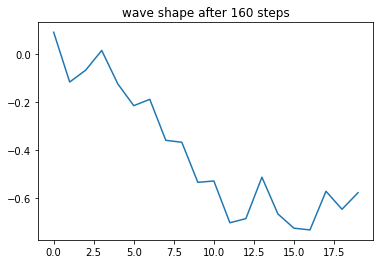

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_160/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_160/model_weights.tf
generator loss:0.90470008400752
-----------------------


161it [10:12,  5.19s/it]

total discriminator loss:0.5500114448202681
average true return:0.5440532902690431
-----------------------
Training Step: 161
generator loss:0.8980401050379841
-----------------------


162it [10:14,  4.21s/it]

total discriminator loss:0.563535209707861
average true return:0.5449143501971252
-----------------------
Training Step: 162
generator loss:0.8934135915910231
-----------------------


163it [10:16,  3.52s/it]

total discriminator loss:0.5782602376035328
average true return:0.5357405403797308
-----------------------
Training Step: 163
generator loss:0.8921259112449595
-----------------------


164it [10:18,  3.04s/it]

total discriminator loss:0.570980155137306
average true return:0.5590683358100433
-----------------------
Training Step: 164
generator loss:0.8990560627534147
-----------------------


165it [10:20,  2.71s/it]

total discriminator loss:0.5928736151871458
average true return:0.5350050257773002
-----------------------
Training Step: 165
event_types: [1, 0, 2, 0, 2, 3, 0, 3, 2, 0, 3, 1, 0, 2, 1, 0, 0, 1, 0, 0]
mad_score: 0.362375
fid_score: 10064.476098692106
rule_score: 0.66025


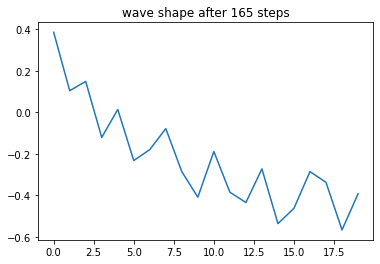

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_165/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_165/model_weights.tf
generator loss:0.8719601514623179
-----------------------


166it [10:31,  5.20s/it]

total discriminator loss:0.6115446982560802
average true return:0.5399862572666978
-----------------------
Training Step: 166
generator loss:0.8705918468584093
-----------------------


167it [10:33,  4.22s/it]

total discriminator loss:0.6339189100269731
average true return:0.535117342888699
-----------------------
Training Step: 167
generator loss:0.8468993534171194
-----------------------


168it [10:34,  3.53s/it]

total discriminator loss:0.625003673636714
average true return:0.5294687228764493
-----------------------
Training Step: 168
generator loss:0.8368282516635375
-----------------------


169it [10:36,  3.04s/it]

total discriminator loss:0.6477729057758075
average true return:0.52270912426527
-----------------------
Training Step: 169
generator loss:0.8488191355525715
-----------------------


170it [10:38,  2.71s/it]

total discriminator loss:0.6820714546664146
average true return:0.5017880068953341
-----------------------
Training Step: 170
event_types: [1, 1, 2, 1, 2, 2, 3, 1, 0, 1, 2, 2, 0, 0, 1, 0, 1, 0, 3, 1]
mad_score: 0.3706375
fid_score: 9052.173597109355
rule_score: 0.66025


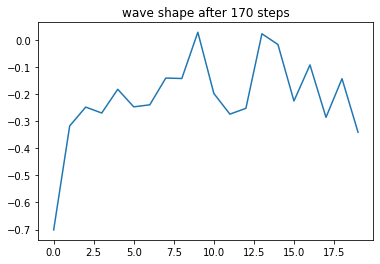

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_170/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_170/model_weights.tf
generator loss:0.8376686940494626
-----------------------


171it [10:49,  5.22s/it]

total discriminator loss:0.7909539179120666
average true return:0.5143539480027289
-----------------------
Training Step: 171
generator loss:0.8091880693649778
-----------------------


172it [10:51,  4.25s/it]

total discriminator loss:0.6720155009120554
average true return:0.5121972253762452
-----------------------
Training Step: 172
generator loss:0.7695074384937821
-----------------------


173it [10:53,  3.56s/it]

total discriminator loss:0.7408212905439311
average true return:0.49575774217473556
-----------------------
Training Step: 173
generator loss:0.7513793346918409
-----------------------


174it [10:55,  3.08s/it]

total discriminator loss:0.7254116398219826
average true return:0.5132516409922485
-----------------------
Training Step: 174
generator loss:0.7267157862522688
-----------------------


175it [10:57,  2.73s/it]

total discriminator loss:0.7729595912996974
average true return:0.5083443667801695
-----------------------
Training Step: 175
event_types: [0, 1, 2, 1, 2, 0, 1, 0, 1, 0, 1, 0, 2, 2, 0, 1, 0, 0, 1, 0]
mad_score: 0.375875
fid_score: 8835.391347324887
rule_score: 0.62875


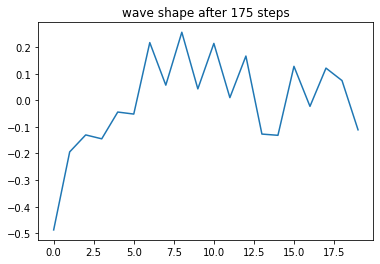

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_175/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_175/model_weights.tf
generator loss:0.6953691014492911
-----------------------


176it [11:09,  5.34s/it]

total discriminator loss:0.8000844268308904
average true return:0.49694111433722576
-----------------------
Training Step: 176
generator loss:0.682659554272239
-----------------------


177it [11:11,  4.32s/it]

total discriminator loss:0.7831942675312396
average true return:0.5122355899515496
-----------------------
Training Step: 177
generator loss:0.6817188622968008
-----------------------


178it [11:12,  3.60s/it]

total discriminator loss:0.6537789156439721
average true return:0.5145375928871302
-----------------------
Training Step: 178
generator loss:0.6430112729471569
-----------------------


179it [11:14,  3.09s/it]

total discriminator loss:0.8151645773824446
average true return:0.5066326720922762
-----------------------
Training Step: 179
generator loss:0.6237486104156433
-----------------------


180it [11:16,  2.74s/it]

total discriminator loss:0.8386773312355396
average true return:0.49862130265987514
-----------------------
Training Step: 180
event_types: [0, 2, 1, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 1, 2, 0, 1, 2, 0, 2]
mad_score: 0.379175
fid_score: 9486.402948362953
rule_score: 0.6245


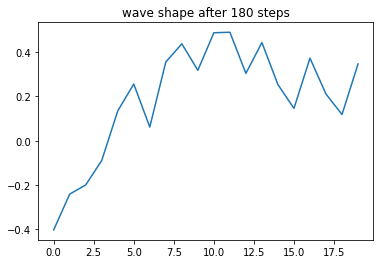

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_180/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_180/model_weights.tf
generator loss:0.6046626213359056
-----------------------


181it [11:27,  5.24s/it]

total discriminator loss:0.8661148794168686
average true return:0.49062604579524194
-----------------------
Training Step: 181
generator loss:0.5985955179865419
-----------------------


182it [11:29,  4.25s/it]

total discriminator loss:0.8717212486450392
average true return:0.5002692813534535
-----------------------
Training Step: 182
generator loss:0.5797527487286555
-----------------------


183it [11:31,  3.55s/it]

total discriminator loss:0.8862557102533772
average true return:0.4897479497718034
-----------------------
Training Step: 183
generator loss:0.5712015671570979
-----------------------


184it [11:33,  3.06s/it]

total discriminator loss:0.8755538324905392
average true return:0.5036928429259371
-----------------------
Training Step: 184
generator loss:0.566951079659192
-----------------------


185it [11:35,  2.72s/it]

total discriminator loss:0.8984211838382313
average true return:0.4978974020549464
-----------------------
Training Step: 185
event_types: [0, 3, 2, 1, 0, 2, 0, 1, 0, 2, 0, 1, 0, 1, 2, 0, 1, 2, 0, 1]
mad_score: 0.377975
fid_score: 10997.801331575305
rule_score: 0.6145


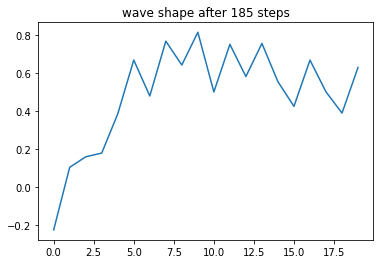

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_185/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_185/model_weights.tf
generator loss:0.5546696733004548
-----------------------


186it [11:46,  5.20s/it]

total discriminator loss:0.871623568607454
average true return:0.5060688796382684
-----------------------
Training Step: 186
generator loss:0.5660053090331454
-----------------------


187it [11:48,  4.22s/it]

total discriminator loss:0.8828607729660916
average true return:0.5070568844909874
-----------------------
Training Step: 187
generator loss:0.5509085473365469
-----------------------


188it [11:50,  3.53s/it]

total discriminator loss:0.9012264907980612
average true return:0.47705993851246853
-----------------------
Training Step: 188
generator loss:0.5599553396405906
-----------------------


189it [11:52,  3.05s/it]

total discriminator loss:0.8937388404351915
average true return:0.491107096677901
-----------------------
Training Step: 189
generator loss:0.5617395985063721
-----------------------


190it [11:54,  2.71s/it]

total discriminator loss:0.9022872704029117
average true return:0.4742216475388593
-----------------------
Training Step: 190
event_types: [1, 3, 1, 0, 1, 0, 1, 0, 1, 0, 2, 2, 2, 0, 3, 1, 0, 2, 0, 1]
mad_score: 0.37545
fid_score: 13035.242478609798
rule_score: 0.59675


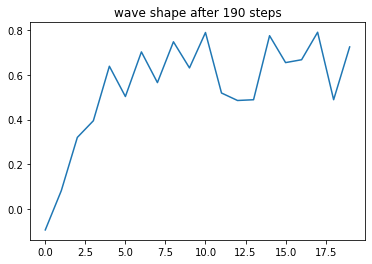

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_190/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_190/model_weights.tf
generator loss:0.5906028131464365
-----------------------


191it [12:05,  5.21s/it]

total discriminator loss:0.8915760039443814
average true return:0.4784976247674626
-----------------------
Training Step: 191
generator loss:0.5774837696896162
-----------------------


192it [12:07,  4.22s/it]

total discriminator loss:0.8837928929664047
average true return:0.4786401085518596
-----------------------
Training Step: 192
generator loss:0.5829796370787808
-----------------------


193it [12:09,  3.54s/it]

total discriminator loss:0.869444148825629
average true return:0.47765291035209384
-----------------------
Training Step: 193
generator loss:0.6017128442937965
-----------------------


194it [12:11,  3.05s/it]

total discriminator loss:0.8549541752704182
average true return:0.4762841095421336
-----------------------
Training Step: 194
generator loss:0.6159293304233017
-----------------------


195it [12:12,  2.71s/it]

total discriminator loss:0.8505234424310688
average true return:0.47478624857377455
-----------------------
Training Step: 195
event_types: [2, 1, 1, 3, 0, 1, 0, 0, 2, 2, 0, 2, 2, 0, 1, 0, 1, 1, 2, 0]
mad_score: 0.37255
fid_score: 15399.995623365994
rule_score: 0.59975


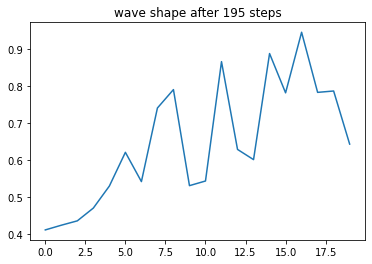

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_195/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_195/model_weights.tf
generator loss:0.6187328848189069
-----------------------


196it [12:24,  5.22s/it]

total discriminator loss:0.6034231992661943
average true return:0.47143149934468853
-----------------------
Training Step: 196
generator loss:0.6499199993878242
-----------------------


197it [12:25,  4.23s/it]

total discriminator loss:0.7991906521941973
average true return:0.4713496399175814
-----------------------
Training Step: 197
generator loss:0.657904636434169
-----------------------


198it [12:27,  3.54s/it]

total discriminator loss:0.8151346652287667
average true return:0.47283107527895396
-----------------------
Training Step: 198
generator loss:0.6608296973737906
-----------------------


199it [12:29,  3.06s/it]

total discriminator loss:0.7892877512296064
average true return:0.46837057660289394
-----------------------
Training Step: 199
generator loss:0.6740037984818247
-----------------------


200it [12:31,  2.72s/it]

total discriminator loss:0.7932792949857256
average true return:0.4679595671813883
-----------------------
Training Step: 200
event_types: [1, 2, 3, 2, 2, 1, 2, 2, 1, 0, 1, 0, 3, 1, 0, 2, 2, 3, 0, 1]
mad_score: 0.366225
fid_score: 17658.766224806
rule_score: 0.62375


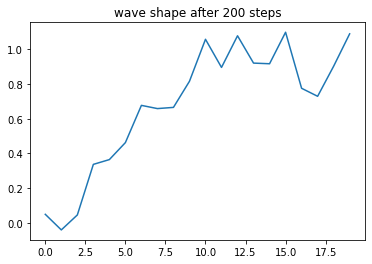

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_200/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_200/model_weights.tf
generator loss:0.6889957800681319
-----------------------


201it [12:42,  5.20s/it]

total discriminator loss:0.7874953851433502
average true return:0.4542320233691872
-----------------------
Training Step: 201
generator loss:0.7072689593683674
-----------------------


202it [12:44,  4.21s/it]

total discriminator loss:0.7745471691390924
average true return:0.45675835947155874
-----------------------
Training Step: 202
generator loss:0.7284663562103093
-----------------------


203it [12:46,  3.52s/it]

total discriminator loss:0.7560121189013638
average true return:0.45854347926200273
-----------------------
Training Step: 203
generator loss:0.7408438199562059
-----------------------


204it [12:48,  3.05s/it]

total discriminator loss:0.6708978915524566
average true return:0.4600667764276479
-----------------------
Training Step: 204
generator loss:0.7661903980753446
-----------------------


205it [12:50,  2.83s/it]

total discriminator loss:0.7206983343747771
average true return:0.4571751790524276
-----------------------
Training Step: 205
event_types: [0, 2, 0, 0, 1, 0, 0, 1, 1, 0, 2, 0, 2, 0, 0, 3, 1, 0, 2, 0]
mad_score: 0.358275
fid_score: 19241.422030189402
rule_score: 0.6155


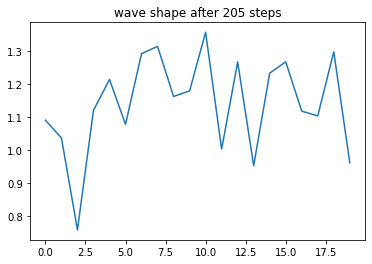

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_205/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_205/model_weights.tf
generator loss:0.7737772129685639
-----------------------


206it [13:01,  5.29s/it]

total discriminator loss:0.7202365353636722
average true return:0.4574563155425376
-----------------------
Training Step: 206
generator loss:0.7865743884643055
-----------------------


207it [13:03,  4.28s/it]

total discriminator loss:0.7015478592466273
average true return:0.4586670507122909
-----------------------
Training Step: 207
generator loss:0.8009290189081414
-----------------------


208it [13:05,  3.58s/it]

total discriminator loss:0.6906965003402605
average true return:0.4590704116550947
-----------------------
Training Step: 208
generator loss:0.810831973859827
-----------------------


209it [13:07,  3.08s/it]

total discriminator loss:0.6907894806771536
average true return:0.45599772559423674
-----------------------
Training Step: 209
generator loss:0.8189399908769053
-----------------------


210it [13:09,  2.74s/it]

total discriminator loss:0.669255231587291
average true return:0.4681501013444975
-----------------------
Training Step: 210
event_types: [0, 0, 1, 2, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2, 2, 1, 1, 0, 2, 0]
mad_score: 0.3517125
fid_score: 19990.604326492128
rule_score: 0.61525


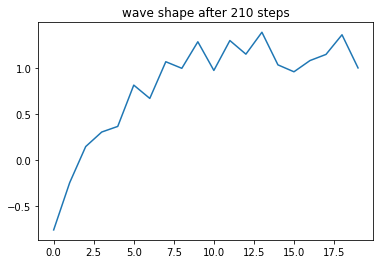

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_210/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_210/model_weights.tf
generator loss:0.8464414139142448
-----------------------


211it [13:20,  5.24s/it]

total discriminator loss:0.6545668844597727
average true return:0.4584827549397684
-----------------------
Training Step: 211
generator loss:0.8632285467196288
-----------------------


212it [13:22,  4.25s/it]

total discriminator loss:0.6429225368212387
average true return:0.46199875334915497
-----------------------
Training Step: 212
generator loss:0.8782092767721755
-----------------------


213it [13:24,  3.55s/it]

total discriminator loss:0.6328504999420402
average true return:0.4610305777283623
-----------------------
Training Step: 213
generator loss:0.9001264312707645
-----------------------


214it [13:26,  3.07s/it]

total discriminator loss:0.6267483764384245
average true return:0.4671514634516227
-----------------------
Training Step: 214
generator loss:0.904661082424218
-----------------------


215it [13:28,  2.73s/it]

total discriminator loss:0.6222894456784527
average true return:0.46374973925738616
-----------------------
Training Step: 215
event_types: [1, 2, 2, 0, 1, 0, 0, 2, 0, 2, 1, 0, 1, 0, 1, 0, 2, 0, 1, 2]
mad_score: 0.342425
fid_score: 19474.498708621642
rule_score: 0.63475


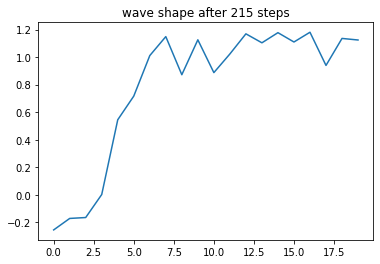

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_215/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_215/model_weights.tf
generator loss:0.9048620281849908
-----------------------


216it [13:39,  5.23s/it]

total discriminator loss:0.5997357321114787
average true return:0.47520626017877565
-----------------------
Training Step: 216
generator loss:0.9376937041168011
-----------------------


217it [13:41,  4.24s/it]

total discriminator loss:0.8350633558984261
average true return:0.46969967060741435
-----------------------
Training Step: 217
generator loss:0.9516040841167209
-----------------------


218it [13:43,  3.54s/it]

total discriminator loss:0.8357610287670623
average true return:0.47320591356433567
-----------------------
Training Step: 218
generator loss:0.9558459291339377
-----------------------


219it [13:45,  3.06s/it]

total discriminator loss:0.8482576807038604
average true return:0.4785855117363295
-----------------------
Training Step: 219
generator loss:0.9315632367078023
-----------------------


220it [13:47,  2.72s/it]

total discriminator loss:0.5967962036784633
average true return:0.4911887117401852
-----------------------
Training Step: 220
event_types: [2, 3, 2, 0, 2, 0, 2, 2, 2, 0, 1, 1, 1, 0, 2, 0, 1, 0, 1, 2]
mad_score: 0.334575
fid_score: 18029.326088374175
rule_score: 0.642


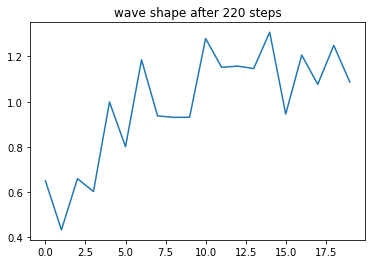

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_220/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_220/model_weights.tf
generator loss:0.9233430876693095
-----------------------


221it [13:58,  5.22s/it]

total discriminator loss:0.5807393832276856
average true return:0.48421817606358575
-----------------------
Training Step: 221
generator loss:0.8942970291251116
-----------------------


222it [14:00,  4.23s/it]

total discriminator loss:0.5854680795420593
average true return:0.5003812534735552
-----------------------
Training Step: 222
generator loss:0.9090810151276191
-----------------------


223it [14:02,  3.54s/it]

total discriminator loss:0.5810327183158959
average true return:0.49276091841975445
-----------------------
Training Step: 223
generator loss:0.8844510239708641
-----------------------


224it [14:04,  3.05s/it]

total discriminator loss:0.5850429236901893
average true return:0.49547274296092714
-----------------------
Training Step: 224
generator loss:0.8810730278802088
-----------------------


225it [14:05,  2.71s/it]

total discriminator loss:0.5789363943829244
average true return:0.4974790040289233
-----------------------
Training Step: 225
event_types: [2, 2, 3, 3, 2, 3, 2, 0, 2, 2, 2, 0, 2, 1, 1, 0, 0, 2, 0, 1]
mad_score: 0.3272625
fid_score: 16319.147072494443
rule_score: 0.66025


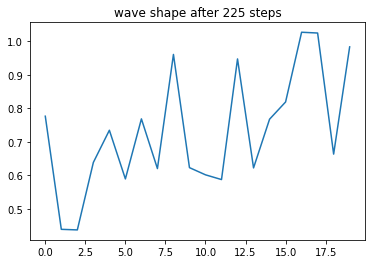

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_225/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_225/model_weights.tf
generator loss:0.8838386865136088
-----------------------


226it [14:16,  5.21s/it]

total discriminator loss:0.5722184709320023
average true return:0.5036384704399481
-----------------------
Training Step: 226
generator loss:0.8942148649607813
-----------------------


227it [14:18,  4.22s/it]

total discriminator loss:0.5700080235100344
average true return:0.5001145748017174
-----------------------
Training Step: 227
generator loss:0.902954922647387
-----------------------


228it [14:20,  3.54s/it]

total discriminator loss:0.5700019487680499
average true return:0.5094679522543668
-----------------------
Training Step: 228
generator loss:0.9009575172563845
-----------------------


229it [14:22,  3.05s/it]

total discriminator loss:0.5622685998659093
average true return:0.5068582455345083
-----------------------
Training Step: 229
generator loss:0.9080281240127865
-----------------------


230it [14:24,  2.71s/it]

total discriminator loss:0.5567188064033538
average true return:0.5066663822257704
-----------------------
Training Step: 230
event_types: [2, 3, 1, 2, 2, 0, 2, 1, 1, 2, 0, 2, 3, 2, 0, 2, 2, 1, 0, 2]
mad_score: 0.317825
fid_score: 14641.878968636885
rule_score: 0.66375


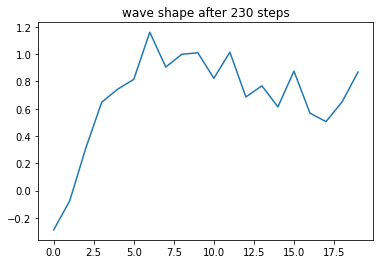

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_230/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_230/model_weights.tf
generator loss:0.9466730830912
-----------------------


231it [14:36,  5.33s/it]

total discriminator loss:0.8914667049091392
average true return:0.5071855827259866
-----------------------
Training Step: 231
generator loss:0.9465405854662525
-----------------------


232it [14:38,  4.32s/it]

total discriminator loss:0.5578396212622749
average true return:0.5022743061113788
-----------------------
Training Step: 232
generator loss:0.9360632932869504
-----------------------


233it [14:39,  3.60s/it]

total discriminator loss:0.547662099733827
average true return:0.4963244464277855
-----------------------
Training Step: 233
generator loss:0.9372812069445398
-----------------------


234it [14:41,  3.10s/it]

total discriminator loss:0.552626698174969
average true return:0.503053262595257
-----------------------
Training Step: 234
generator loss:0.952984537083315
-----------------------


235it [14:43,  2.75s/it]

total discriminator loss:0.5484910331016755
average true return:0.5029852025111615
-----------------------
Training Step: 235
event_types: [1, 2, 2, 2, 2, 3, 2, 1, 2, 0, 3, 1, 0, 2, 0, 1, 0, 2, 0, 1]
mad_score: 0.317875
fid_score: 13019.753602659173
rule_score: 0.64325


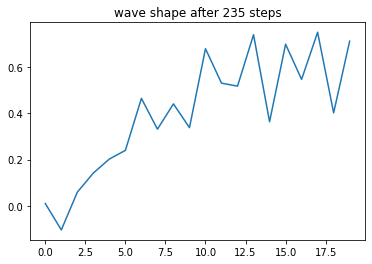

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_235/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_235/model_weights.tf
generator loss:0.9658509435352851
-----------------------


236it [14:54,  5.24s/it]

total discriminator loss:0.5487471898428508
average true return:0.4950909188178529
-----------------------
Training Step: 236
generator loss:0.9633699803503575
-----------------------


237it [14:56,  4.25s/it]

total discriminator loss:0.5542319141806089
average true return:0.498710507899648
-----------------------
Training Step: 237
generator loss:0.9950197463389301
-----------------------


238it [14:58,  3.55s/it]

total discriminator loss:0.5459506585967735
average true return:0.49886712341399564
-----------------------
Training Step: 238
generator loss:0.9954949353975295
-----------------------


239it [15:00,  3.06s/it]

total discriminator loss:0.5477100191216205
average true return:0.49431176369757196
-----------------------
Training Step: 239
generator loss:0.9747151041506437
-----------------------


240it [15:02,  2.72s/it]

total discriminator loss:0.5411577243264747
average true return:0.49404521213990793
-----------------------
Training Step: 240
event_types: [1, 0, 2, 0, 0, 1, 2, 2, 0, 2, 2, 1, 1, 2, 0, 2, 2, 0, 3, 1]
mad_score: 0.3141375
fid_score: 11578.040061540756
rule_score: 0.67


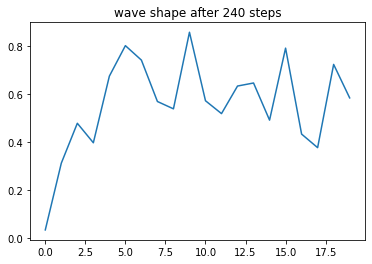

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_240/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_240/model_weights.tf
generator loss:1.009760746604754
-----------------------


241it [15:13,  5.22s/it]

total discriminator loss:0.5422935441656629
average true return:0.497942665850238
-----------------------
Training Step: 241
generator loss:0.9862862172078276
-----------------------


242it [15:15,  4.23s/it]

total discriminator loss:0.5466002546594861
average true return:0.4911608811064162
-----------------------
Training Step: 242
generator loss:0.9857343980613088
-----------------------


243it [15:17,  3.54s/it]

total discriminator loss:0.5392475035626649
average true return:0.49372884069743794
-----------------------
Training Step: 243
generator loss:1.0027734959584913
-----------------------


244it [15:19,  3.05s/it]

total discriminator loss:0.5286766834620302
average true return:0.49047189974652305
-----------------------
Training Step: 244
generator loss:1.012074901024985
-----------------------


245it [15:21,  2.72s/it]

total discriminator loss:0.545567069675899
average true return:0.4926985162518177
-----------------------
Training Step: 245
event_types: [2, 3, 2, 3, 2, 0, 0, 2, 2, 0, 1, 2, 0, 3, 2, 2, 0, 1, 2, 1]
mad_score: 0.3116875
fid_score: 10376.827526249286
rule_score: 0.65975


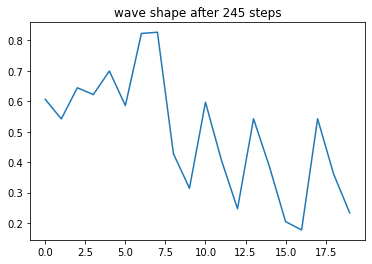

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_245/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_245/model_weights.tf
generator loss:0.9930190759291495
-----------------------


246it [15:32,  5.23s/it]

total discriminator loss:0.5452309534913874
average true return:0.4981060727946678
-----------------------
Training Step: 246
generator loss:1.0103884078213596
-----------------------


247it [15:34,  4.24s/it]

total discriminator loss:0.5252780216036687
average true return:0.49193153187765787
-----------------------
Training Step: 247
generator loss:0.9973500715260446
-----------------------


248it [15:36,  3.54s/it]

total discriminator loss:0.5431829034132865
average true return:0.5064397879383906
-----------------------
Training Step: 248
generator loss:1.0227234649481824
-----------------------


249it [15:38,  3.06s/it]

total discriminator loss:0.5449491499931676
average true return:0.49860632143806577
-----------------------
Training Step: 249
generator loss:1.0049476638982706
-----------------------


250it [15:40,  2.72s/it]

total discriminator loss:0.543238234596132
average true return:0.4996483479264383
-----------------------
Training Step: 250
event_types: [3, 1, 0, 1, 1, 2, 2, 2, 2, 0, 2, 0, 3, 1, 2, 2, 1, 2, 2, 2]
mad_score: 0.311975
fid_score: 9391.046544055229
rule_score: 0.67925


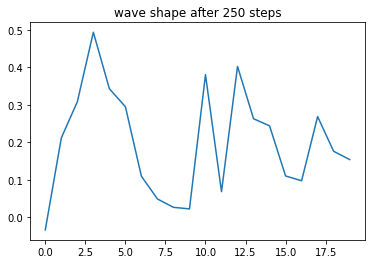

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_250/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_250/model_weights.tf
generator loss:0.9825877880041549
-----------------------


251it [15:51,  5.22s/it]

total discriminator loss:0.9165582372959762
average true return:0.5001879522164653
-----------------------
Training Step: 251
generator loss:0.9919714838031493
-----------------------


252it [15:53,  4.23s/it]

total discriminator loss:0.5532886333078622
average true return:0.5138349403795459
-----------------------
Training Step: 252
generator loss:0.968281116656657
-----------------------


253it [15:55,  3.54s/it]

total discriminator loss:0.5571118045904324
average true return:0.5069205990818172
-----------------------
Training Step: 253
generator loss:0.953185386421334
-----------------------


254it [15:57,  3.07s/it]

total discriminator loss:0.5590247886715333
average true return:0.4990368069839207
-----------------------
Training Step: 254
generator loss:0.963998129711315
-----------------------


255it [15:58,  2.73s/it]

total discriminator loss:0.5795733423357923
average true return:0.5106285217569994
-----------------------
Training Step: 255
event_types: [0, 2, 1, 2, 1, 2, 1, 1, 1, 0, 2, 0, 2, 3, 2, 0, 1, 0, 1, 0]
mad_score: 0.317025
fid_score: 8727.73532755914
rule_score: 0.663


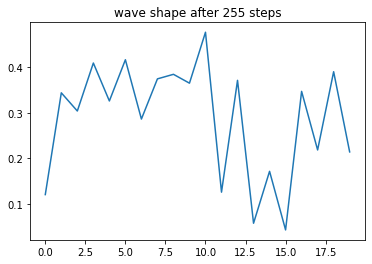

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_255/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_255/model_weights.tf
generator loss:0.9449876971912616
-----------------------


256it [16:10,  5.26s/it]

total discriminator loss:0.574124381550055
average true return:0.5060519049245413
-----------------------
Training Step: 256
generator loss:0.9153355770005169
-----------------------


257it [16:12,  4.26s/it]

total discriminator loss:0.587507148955426
average true return:0.5110818748643873
-----------------------
Training Step: 257
generator loss:0.9194672494380729
-----------------------


258it [16:13,  3.56s/it]

total discriminator loss:0.5722307123941246
average true return:0.5112479013212359
-----------------------
Training Step: 258
generator loss:0.9072957256620795
-----------------------


259it [16:16,  3.19s/it]

total discriminator loss:0.5951043377467883
average true return:0.51818490787363
-----------------------
Training Step: 259
generator loss:0.9040351057854454
-----------------------


260it [16:18,  2.81s/it]

total discriminator loss:0.6099791950545652
average true return:0.5184739551880151
-----------------------
Training Step: 260
event_types: [2, 1, 0, 2, 2, 1, 0, 1, 1, 0, 2, 3, 2, 1, 2, 3, 1, 0, 2, 1]
mad_score: 0.3166125
fid_score: 8360.330810531146
rule_score: 0.68825


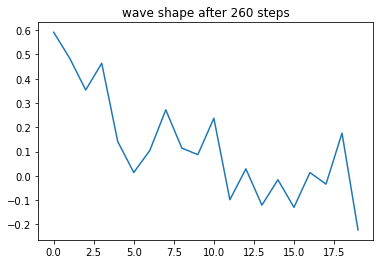

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_260/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_260/model_weights.tf
generator loss:0.8749445714469697
-----------------------


261it [16:29,  5.29s/it]

total discriminator loss:0.6219452896944264
average true return:0.5135305880341989
-----------------------
Training Step: 261
generator loss:0.847250681344213
-----------------------


262it [16:31,  4.28s/it]

total discriminator loss:0.6123289816758339
average true return:0.509458124917455
-----------------------
Training Step: 262
generator loss:0.8699710384066295
-----------------------


263it [16:33,  3.57s/it]

total discriminator loss:0.6454508974262846
average true return:0.5056232113228617
-----------------------
Training Step: 263
generator loss:0.8621241583369998
-----------------------


264it [16:35,  3.08s/it]

total discriminator loss:0.6532217003498535
average true return:0.5064288901175686
-----------------------
Training Step: 264
generator loss:0.833754737816233
-----------------------


265it [16:36,  2.73s/it]

total discriminator loss:0.6479694558875304
average true return:0.4977065737493186
-----------------------
Training Step: 265
event_types: [2, 2, 1, 0, 1, 0, 2, 0, 1, 1, 2, 1, 2, 3, 3, 2, 0, 2, 2, 0]
mad_score: 0.32225
fid_score: 8374.575454189599
rule_score: 0.6795


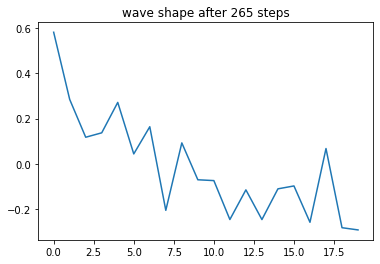

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_265/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_265/model_weights.tf
generator loss:0.816397296359765
-----------------------


266it [16:47,  5.21s/it]

total discriminator loss:0.6679721599231166
average true return:0.49283206584306216
-----------------------
Training Step: 266
generator loss:0.8227444746514647
-----------------------


267it [16:49,  4.23s/it]

total discriminator loss:0.6765306252580363
average true return:0.5098552127320738
-----------------------
Training Step: 267
generator loss:0.7993039841155375
-----------------------


268it [16:51,  3.54s/it]

total discriminator loss:0.7173203015106632
average true return:0.5212772433120095
-----------------------
Training Step: 268
generator loss:0.8028809122604328
-----------------------


269it [16:53,  3.05s/it]

total discriminator loss:0.692138253038503
average true return:0.5093148513581757
-----------------------
Training Step: 269
generator loss:0.7538036063520448
-----------------------


270it [16:55,  2.71s/it]

total discriminator loss:0.7200413687166977
average true return:0.5196849065221305
-----------------------
Training Step: 270
event_types: [2, 1, 2, 0, 2, 2, 0, 2, 0, 2, 3, 0, 2, 2, 3, 0, 2, 2, 0, 2]
mad_score: 0.32835
fid_score: 8776.554071690853
rule_score: 0.69575


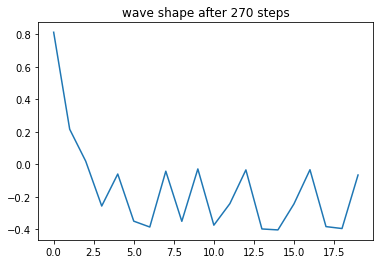

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_270/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_270/model_weights.tf
generator loss:0.7066769052576471
-----------------------


271it [17:06,  5.21s/it]

total discriminator loss:0.7233688432510118
average true return:0.5004728186426008
-----------------------
Training Step: 271
generator loss:0.7217905489243496
-----------------------


272it [17:08,  4.23s/it]

total discriminator loss:0.7571694980976709
average true return:0.5202464318034625
-----------------------
Training Step: 272
generator loss:0.7310213552435209
-----------------------


273it [17:10,  3.54s/it]

total discriminator loss:0.7405105190303558
average true return:0.5023805330274922
-----------------------
Training Step: 273
generator loss:0.681417826351987
-----------------------


274it [17:12,  3.05s/it]

total discriminator loss:0.7476560422446743
average true return:0.5187183496221472
-----------------------
Training Step: 274
generator loss:0.6498695479767609
-----------------------


275it [17:14,  2.71s/it]

total discriminator loss:0.7466196504302791
average true return:0.5207533073592123
-----------------------
Training Step: 275
event_types: [3, 2, 0, 2, 1, 0, 2, 0, 2, 0, 0, 0, 1, 2, 1, 2, 0, 2, 3, 2]
mad_score: 0.335525
fid_score: 9550.417259060296
rule_score: 0.68275


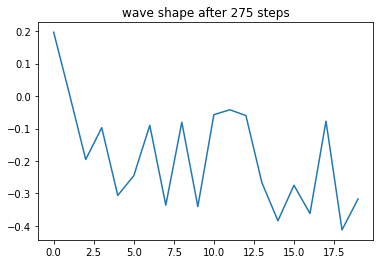

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_275/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_275/model_weights.tf
generator loss:0.6498007589208539
-----------------------


276it [17:25,  5.22s/it]

total discriminator loss:0.7489869579342026
average true return:0.5276708475184507
-----------------------
Training Step: 276
generator loss:0.6378995113446081
-----------------------


277it [17:27,  4.24s/it]

total discriminator loss:0.7837272517272753
average true return:0.5243606689914685
-----------------------
Training Step: 277
generator loss:0.6278689524718667
-----------------------


278it [17:29,  3.54s/it]

total discriminator loss:0.7654663111858971
average true return:0.5274476803230616
-----------------------
Training Step: 278
generator loss:0.625935623148582
-----------------------


279it [17:31,  3.05s/it]

total discriminator loss:0.7445887806408285
average true return:0.5286835505232333
-----------------------
Training Step: 279
generator loss:0.6107716561981991
-----------------------


280it [17:33,  2.72s/it]

total discriminator loss:0.7497591462735341
average true return:0.5284464214636453
-----------------------
Training Step: 280
event_types: [1, 1, 2, 1, 2, 2, 1, 2, 0, 2, 1, 2, 3, 2, 2, 2, 3, 2, 2, 1]
mad_score: 0.346175
fid_score: 10559.87432795622
rule_score: 0.58275


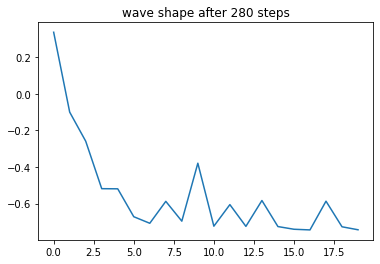

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_280/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_280/model_weights.tf
generator loss:0.6037578673096093
-----------------------


281it [17:44,  5.19s/it]

total discriminator loss:0.7459904298663378
average true return:0.5356298069959773
-----------------------
Training Step: 281
generator loss:0.6124269300179805
-----------------------


282it [17:46,  4.21s/it]

total discriminator loss:0.7270322211134121
average true return:0.5231345610499807
-----------------------
Training Step: 282
generator loss:0.6163945313146069
-----------------------


283it [17:48,  3.52s/it]

total discriminator loss:0.7235652449051889
average true return:0.5330968970593437
-----------------------
Training Step: 283
generator loss:0.6237315205638911
-----------------------


284it [17:49,  3.04s/it]

total discriminator loss:0.7116882510594346
average true return:0.5329259510583753
-----------------------
Training Step: 284
generator loss:0.6603387948398772
-----------------------


285it [17:51,  2.71s/it]

total discriminator loss:0.693366389365055
average true return:0.5330662189644346
-----------------------
Training Step: 285
event_types: [0, 1, 1, 0, 2, 0, 2, 0, 3, 2, 0, 0, 2, 3, 2, 2, 1, 2, 3, 0]
mad_score: 0.36305
fid_score: 11635.626643399199
rule_score: 0.35275


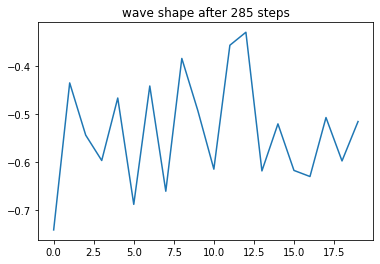

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_285/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_285/model_weights.tf
generator loss:0.6699235200175573
-----------------------


286it [18:03,  5.29s/it]

total discriminator loss:0.6882730316836985
average true return:0.5325457218329904
-----------------------
Training Step: 286
generator loss:0.6825772914930842
-----------------------


287it [18:05,  4.28s/it]

total discriminator loss:0.6730211898457337
average true return:0.5205625867978401
-----------------------
Training Step: 287
generator loss:0.7005038490439582
-----------------------


288it [18:07,  3.57s/it]

total discriminator loss:0.7517905687264596
average true return:0.5233385592023081
-----------------------
Training Step: 288
generator loss:0.7179648838955532
-----------------------


289it [18:08,  3.08s/it]

total discriminator loss:0.6561670988571031
average true return:0.5292830922316795
-----------------------
Training Step: 289
generator loss:0.7320538771877962
-----------------------


290it [18:10,  2.73s/it]

total discriminator loss:0.65067358510438
average true return:0.527569314273477
-----------------------
Training Step: 290
event_types: [1, 2, 0, 2, 0, 1, 2, 1, 0, 2, 1, 2, 2, 2, 3, 2, 2, 3, 2, 3]
mad_score: 0.383675
fid_score: 12414.21778660475
rule_score: 0.22775


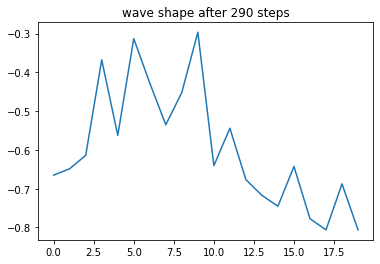

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_290/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_290/model_weights.tf
generator loss:0.7481951472700643
-----------------------


291it [18:21,  5.18s/it]

total discriminator loss:0.6344693443428973
average true return:0.5258559430220717
-----------------------
Training Step: 291
generator loss:0.7731457524625431
-----------------------


292it [18:23,  4.20s/it]

total discriminator loss:0.7959378662222527
average true return:0.5191478766284126
-----------------------
Training Step: 292
generator loss:0.7859419902632909
-----------------------


293it [18:25,  3.52s/it]

total discriminator loss:0.6258945108771177
average true return:0.5068409911416708
-----------------------
Training Step: 293
generator loss:0.8118186548925774
-----------------------


294it [18:27,  3.04s/it]

total discriminator loss:0.6115600436567467
average true return:0.5121568245350568
-----------------------
Training Step: 294
generator loss:0.82885768228891
-----------------------


295it [18:29,  2.70s/it]

total discriminator loss:0.6110759310279104
average true return:0.5073035516047042
-----------------------
Training Step: 295
event_types: [3, 2, 2, 1, 2, 3, 1, 0, 1, 2, 1, 2, 1, 3, 2, 2, 3, 3, 0, 1]
mad_score: 0.4072375
fid_score: 12734.119946694744
rule_score: 0.21225


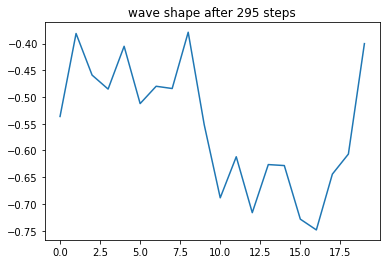

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_295/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_295/model_weights.tf
generator loss:0.8407778100589713
-----------------------


296it [18:40,  5.17s/it]

total discriminator loss:0.6076850042821806
average true return:0.49870544396844596
-----------------------
Training Step: 296
generator loss:0.8470183613000805
-----------------------


297it [18:42,  4.20s/it]

total discriminator loss:0.5966012526123499
average true return:0.5014263110512681
-----------------------
Training Step: 297
generator loss:0.8491822184466016
-----------------------


298it [18:44,  3.51s/it]

total discriminator loss:0.5807839419423353
average true return:0.502125222372755
-----------------------
Training Step: 298
generator loss:0.8679215389789126
-----------------------


299it [18:46,  3.03s/it]

total discriminator loss:0.5921878710104829
average true return:0.5045192822882928
-----------------------
Training Step: 299
generator loss:0.865804780493896
-----------------------


300it [18:48,  2.70s/it]

total discriminator loss:0.56683438950288
average true return:0.5115479082576933
-----------------------
Training Step: 300
event_types: [2, 1, 2, 2, 2, 2, 0, 3, 2, 2, 1, 2, 2, 1, 3, 0, 2, 2, 1, 3]
mad_score: 0.4345125
fid_score: 12654.008908931599
rule_score: 0.21625


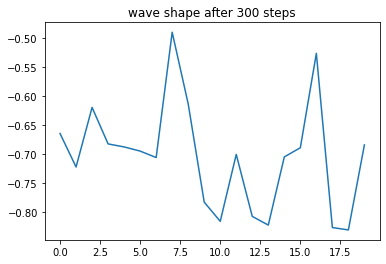

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_300/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_300/model_weights.tf
generator loss:0.8713358796921163
-----------------------


301it [18:58,  5.15s/it]

total discriminator loss:0.5749280301178619
average true return:0.5133024811949878
-----------------------
Training Step: 301
generator loss:0.8719821769141287
-----------------------


302it [19:00,  4.18s/it]

total discriminator loss:0.5746013450128212
average true return:0.5212587314273576
-----------------------
Training Step: 302
generator loss:0.8757016931302418
-----------------------


303it [19:02,  3.50s/it]

total discriminator loss:0.5617804166363083
average true return:0.5192185578350597
-----------------------
Training Step: 303
generator loss:0.8752154701408852
-----------------------


304it [19:04,  3.03s/it]

total discriminator loss:0.5590929084820615
average true return:0.5199467507517004
-----------------------
Training Step: 304
generator loss:0.8823275803282666
-----------------------


305it [19:06,  2.70s/it]

total discriminator loss:0.5581855151159294
average true return:0.5266901675489482
-----------------------
Training Step: 305
event_types: [1, 0, 2, 1, 0, 1, 2, 3, 2, 2, 0, 3, 1, 0, 2, 1, 0, 3, 1, 0]
mad_score: 0.4599625
fid_score: 12189.926594507662
rule_score: 0.286


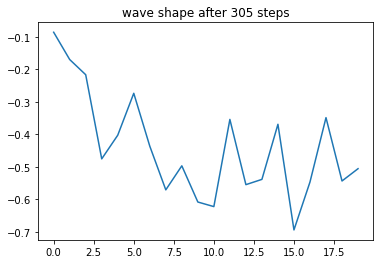

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_305/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_305/model_weights.tf
generator loss:0.8824321164726385
-----------------------


306it [19:17,  5.16s/it]

total discriminator loss:0.5497007909608328
average true return:0.5348259859938091
-----------------------
Training Step: 306
generator loss:0.9011269397702875
-----------------------


307it [19:19,  4.19s/it]

total discriminator loss:0.5305114846097037
average true return:0.5363172063475353
-----------------------
Training Step: 307
generator loss:0.9078979476872115
-----------------------


308it [19:21,  3.51s/it]

total discriminator loss:0.5486915072392513
average true return:0.5224225061127021
-----------------------
Training Step: 308
generator loss:0.905229568291378
-----------------------


309it [19:23,  3.03s/it]

total discriminator loss:0.9292741652420841
average true return:0.5256798501630451
-----------------------
Training Step: 309
generator loss:0.9253720289395819
-----------------------


310it [19:25,  2.69s/it]

total discriminator loss:0.5391416761407894
average true return:0.531088537472783
-----------------------
Training Step: 310
event_types: [1, 2, 2, 0, 1, 2, 3, 2, 1, 1, 0, 1, 3, 1, 1, 2, 3, 3, 1, 2]
mad_score: 0.485025
fid_score: 11497.894197843838
rule_score: 0.36925


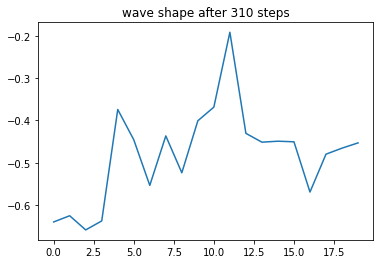

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_310/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_310/model_weights.tf
generator loss:0.9254934546749081
-----------------------


311it [19:36,  5.16s/it]

total discriminator loss:0.5436349883251512
average true return:0.52511134963828
-----------------------
Training Step: 311
generator loss:0.9480706619253878
-----------------------


312it [19:38,  4.18s/it]

total discriminator loss:0.526711096163603
average true return:0.5296165824632556
-----------------------
Training Step: 312
generator loss:0.932332371693533
-----------------------


313it [19:39,  3.51s/it]

total discriminator loss:0.5575258983401119
average true return:0.5137066914031994
-----------------------
Training Step: 313
generator loss:0.9437200484814
-----------------------


314it [19:42,  3.16s/it]

total discriminator loss:0.545973218316421
average true return:0.5163970346678961
-----------------------
Training Step: 314
generator loss:0.9680182320428006
-----------------------


315it [19:44,  2.79s/it]

total discriminator loss:0.5260560044182498
average true return:0.5204081817692136
-----------------------
Training Step: 315
event_types: [2, 2, 3, 2, 2, 3, 3, 3, 1, 2, 2, 3, 3, 2, 1, 3, 2, 0, 3, 1]
mad_score: 0.509675
fid_score: 10726.212553047317
rule_score: 0.38175


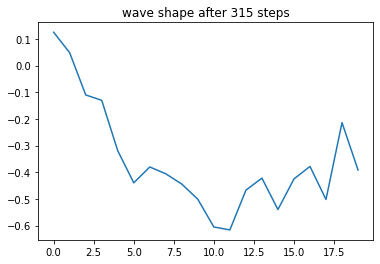

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_315/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_315/model_weights.tf
generator loss:0.9585240866409535
-----------------------


316it [19:55,  5.25s/it]

total discriminator loss:0.9461261408908063
average true return:0.5053265947842853
-----------------------
Training Step: 316
generator loss:0.9783417191072621
-----------------------


317it [19:57,  4.25s/it]

total discriminator loss:0.5259675970480454
average true return:0.5213587562613945
-----------------------
Training Step: 317
generator loss:0.9559962320733176
-----------------------


318it [19:59,  3.57s/it]

total discriminator loss:0.5439687523757739
average true return:0.5076616252232167
-----------------------
Training Step: 318
generator loss:0.953554314569789
-----------------------


319it [20:01,  3.09s/it]

total discriminator loss:0.558314095523016
average true return:0.506249158209306
-----------------------
Training Step: 319
generator loss:0.9465546282678595
-----------------------


320it [20:03,  2.76s/it]

total discriminator loss:0.5495438938447172
average true return:0.5121071662023142
-----------------------
Training Step: 320
event_types: [3, 3, 2, 2, 0, 3, 3, 1, 3, 2, 3, 1, 3, 3, 2, 2, 2, 1, 2, 3]
mad_score: 0.5291875
fid_score: 9955.749062604707
rule_score: 0.3305


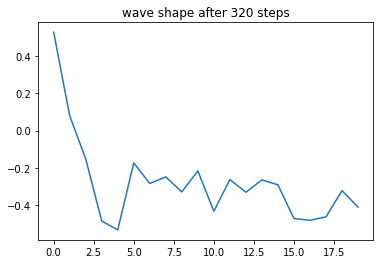

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_320/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_320/model_weights.tf
generator loss:0.9476284365301826
-----------------------


321it [20:14,  5.23s/it]

total discriminator loss:0.5576116726887332
average true return:0.5109820984386747
-----------------------
Training Step: 321
generator loss:0.9336021210381475
-----------------------


322it [20:15,  4.23s/it]

total discriminator loss:0.5629983358129109
average true return:0.5188102091747102
-----------------------
Training Step: 322
generator loss:0.9512758341493732
-----------------------


323it [20:17,  3.53s/it]

total discriminator loss:0.558713966307806
average true return:0.511727360795752
-----------------------
Training Step: 323
generator loss:0.9389680916137826
-----------------------


324it [20:19,  3.05s/it]

total discriminator loss:0.5832268213390785
average true return:0.49956378230362347
-----------------------
Training Step: 324
generator loss:0.9555167754440023
-----------------------


325it [20:21,  2.71s/it]

total discriminator loss:0.5773594300910675
average true return:0.5122193287362954
-----------------------
Training Step: 325
event_types: [2, 2, 3, 1, 2, 3, 2, 1, 2, 1, 2, 3, 1, 0, 1, 3, 2, 3, 1, 0]
mad_score: 0.5425875
fid_score: 9295.25030500389
rule_score: 0.267


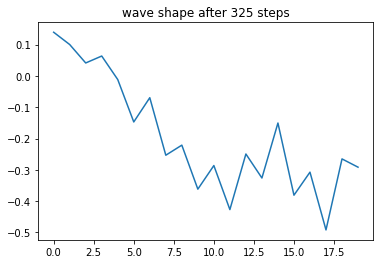

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_325/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_325/model_weights.tf
generator loss:0.9442684238849058
-----------------------


326it [20:32,  5.18s/it]

total discriminator loss:0.5668893385183633
average true return:0.5035301874460872
-----------------------
Training Step: 326
generator loss:0.9146821587652176
-----------------------


327it [20:34,  4.20s/it]

total discriminator loss:0.5617700098154403
average true return:0.5091576335128181
-----------------------
Training Step: 327
generator loss:0.9460397995026529
-----------------------


328it [20:36,  3.52s/it]

total discriminator loss:0.5972361831793064
average true return:0.4941816839957225
-----------------------
Training Step: 328
generator loss:0.9196969872129594
-----------------------


329it [20:38,  3.04s/it]

total discriminator loss:0.5781300083311012
average true return:0.5043875400302265
-----------------------
Training Step: 329
generator loss:0.935138271559449
-----------------------


330it [20:40,  2.70s/it]

total discriminator loss:0.5850619767800925
average true return:0.512509386868728
-----------------------
Training Step: 330
event_types: [2, 0, 2, 2, 3, 1, 3, 1, 3, 2, 3, 3, 2, 3, 2, 0, 3, 3, 2, 0]
mad_score: 0.5533625
fid_score: 8851.147337678822
rule_score: 0.216


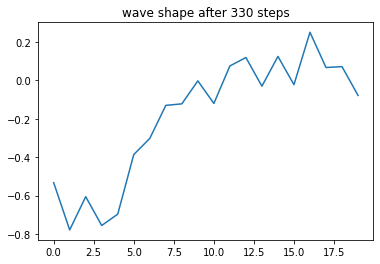

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_330/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_330/model_weights.tf
generator loss:0.9249058828945764
-----------------------


331it [20:51,  5.18s/it]

total discriminator loss:0.5940666544748245
average true return:0.5048745293051085
-----------------------
Training Step: 331
generator loss:0.9224976719193141
-----------------------


332it [20:53,  4.20s/it]

total discriminator loss:0.5983104558270553
average true return:0.501900468143463
-----------------------
Training Step: 332
generator loss:0.9242127552706694
-----------------------


333it [20:55,  3.52s/it]

total discriminator loss:0.5983110907459888
average true return:0.5087638590221182
-----------------------
Training Step: 333
generator loss:0.9078340059643752
-----------------------


334it [20:57,  3.04s/it]

total discriminator loss:0.6033440711629705
average true return:0.48450881619275665
-----------------------
Training Step: 334
generator loss:0.9264740274740543
-----------------------


335it [20:58,  2.70s/it]

total discriminator loss:0.6050173221205467
average true return:0.49573034817996253
-----------------------
Training Step: 335
event_types: [1, 3, 3, 0, 2, 2, 2, 3, 3, 3, 3, 3, 3, 1, 1, 1, 2, 2, 3, 1]
mad_score: 0.5601
fid_score: 8679.40629175996
rule_score: 0.18475


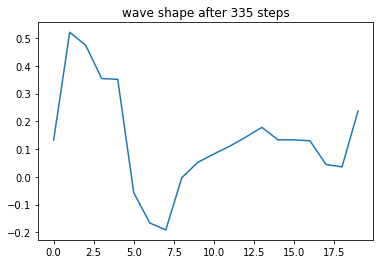

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_335/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_335/model_weights.tf
generator loss:0.9177652983358958
-----------------------


336it [21:10,  5.20s/it]

total discriminator loss:0.609135846682497
average true return:0.4964301873918555
-----------------------
Training Step: 336
generator loss:0.9164235528247158
-----------------------


337it [21:11,  4.23s/it]

total discriminator loss:0.5921149704616437
average true return:0.5036512122053409
-----------------------
Training Step: 337
generator loss:0.933681342378315
-----------------------


338it [21:13,  3.54s/it]

total discriminator loss:0.6248269228751872
average true return:0.48025699889978546
-----------------------
Training Step: 338
generator loss:0.9137089576928116
-----------------------


339it [21:15,  3.06s/it]

total discriminator loss:0.6293186343880106
average true return:0.5015815568978594
-----------------------
Training Step: 339
generator loss:0.9458102922672926
-----------------------


340it [21:17,  2.72s/it]

total discriminator loss:0.6264985747584815
average true return:0.4754769213682631
-----------------------
Training Step: 340
event_types: [3, 1, 2, 0, 2, 3, 2, 3, 3, 3, 2, 2, 3, 3, 3, 3, 1, 0, 3, 2]
mad_score: 0.564975
fid_score: 8849.550877910695
rule_score: 0.138


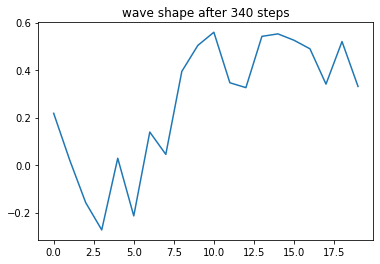

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_340/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_340/model_weights.tf
generator loss:0.9420550369038493
-----------------------


341it [21:29,  5.31s/it]

total discriminator loss:0.651633577920484
average true return:0.46890089014254804
-----------------------
Training Step: 341
generator loss:0.9475109475210122
-----------------------


342it [21:31,  4.29s/it]

total discriminator loss:0.6460356775423879
average true return:0.476607987707367
-----------------------
Training Step: 342
generator loss:0.9275419439752511
-----------------------


343it [21:32,  3.58s/it]

total discriminator loss:0.6024451269078742
average true return:0.5031699973776836
-----------------------
Training Step: 343
generator loss:0.9207981869355213
-----------------------


344it [21:34,  3.08s/it]

total discriminator loss:0.6134687873222602
average true return:0.49081976489944723
-----------------------
Training Step: 344
generator loss:0.9330734456776758
-----------------------


345it [21:36,  2.73s/it]

total discriminator loss:0.6280795861733528
average true return:0.48530056145554523
-----------------------
Training Step: 345
event_types: [1, 3, 2, 2, 3, 2, 2, 3, 1, 3, 3, 1, 2, 3, 1, 2, 3, 1, 3, 2]
mad_score: 0.5590625
fid_score: 9425.237823622754
rule_score: 0.146


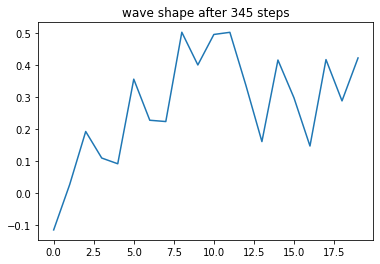

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_345/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_345/model_weights.tf
generator loss:0.9611732147306484
-----------------------


346it [21:47,  5.20s/it]

total discriminator loss:0.623712758705752
average true return:0.48876148158916544
-----------------------
Training Step: 346
generator loss:0.959787824290787
-----------------------


347it [21:49,  4.22s/it]

total discriminator loss:0.6079616464505896
average true return:0.4933192120669087
-----------------------
Training Step: 347
generator loss:0.9453323881068721
-----------------------
total discriminator loss:0.6256617178572661
average true return:0.47337754314380776
-----------------------


348it [21:51,  3.55s/it]

Training Step: 348
generator loss:1.0111288591059933
-----------------------


349it [21:53,  3.07s/it]

total discriminator loss:0.5841486973362485
average true return:0.49191833020444486
-----------------------
Training Step: 349
generator loss:1.0001687847337128
-----------------------


350it [21:55,  2.72s/it]

total discriminator loss:0.5807269822416183
average true return:0.4744047730955635
-----------------------
Training Step: 350
event_types: [0, 2, 1, 2, 3, 1, 0, 2, 1, 2, 3, 2, 3, 1, 2, 2, 1, 2, 3, 2]
mad_score: 0.5552875
fid_score: 10322.310327067902
rule_score: 0.15425


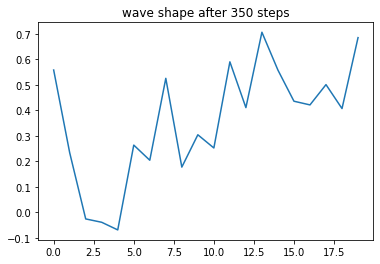

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_350/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_350/model_weights.tf
generator loss:1.0176968926974295
-----------------------


351it [22:06,  5.19s/it]

total discriminator loss:0.5736397200499226
average true return:0.48907026925393576
-----------------------
Training Step: 351
generator loss:1.0237001462091153
-----------------------


352it [22:08,  4.22s/it]

total discriminator loss:0.5559844117163036
average true return:0.48662215482922655
-----------------------
Training Step: 352
generator loss:1.0546027266534415
-----------------------


353it [22:10,  3.53s/it]

total discriminator loss:0.5506727712091184
average true return:0.4710964585484712
-----------------------
Training Step: 353
generator loss:1.118193181374258
-----------------------


354it [22:12,  3.05s/it]

total discriminator loss:0.5431896265943571
average true return:0.49404049127144567
-----------------------
Training Step: 354
generator loss:1.1430086202044245
-----------------------


355it [22:14,  2.71s/it]

total discriminator loss:0.5273469274190106
average true return:0.4822735283568049
-----------------------
Training Step: 355
event_types: [0, 0, 1, 2, 1, 2, 0, 1, 2, 2, 3, 3, 2, 1, 0, 3, 2, 3, 3, 2]
mad_score: 0.5423625
fid_score: 11422.820684205124
rule_score: 0.16925


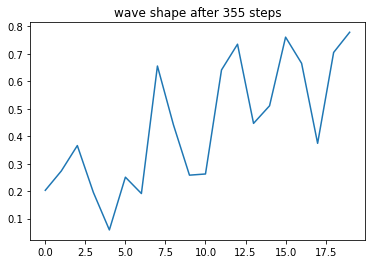

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_355/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_355/model_weights.tf
generator loss:1.1624960725684583
-----------------------


356it [22:25,  5.18s/it]

total discriminator loss:0.5144792301984211
average true return:0.4849822065380135
-----------------------
Training Step: 356
generator loss:1.2454396741821205
-----------------------


357it [22:27,  4.20s/it]

total discriminator loss:0.5024741766350953
average true return:0.47281715716441386
-----------------------
Training Step: 357
generator loss:1.2841200162713542
-----------------------


358it [22:28,  3.51s/it]

total discriminator loss:0.4686470047847381
average true return:0.4758343817904263
-----------------------
Training Step: 358
generator loss:1.3104477384663369
-----------------------


359it [22:30,  3.04s/it]

total discriminator loss:0.4652404882483451
average true return:0.4781676000874815
-----------------------
Training Step: 359
generator loss:1.3224197537859923
-----------------------


360it [22:32,  2.70s/it]

total discriminator loss:0.46787732263416915
average true return:0.497333686066302
-----------------------
Training Step: 360
event_types: [3, 2, 2, 0, 2, 3, 2, 1, 3, 2, 3, 1, 3, 2, 2, 2, 1, 2, 3, 3]
mad_score: 0.5245125
fid_score: 12254.516122831641
rule_score: 0.20775


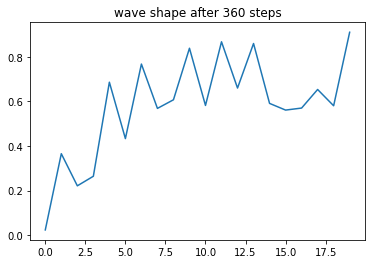

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_360/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_360/model_weights.tf
generator loss:1.316819837427912
-----------------------


361it [22:43,  5.20s/it]

total discriminator loss:0.4633042343249283
average true return:0.48854331543452156
-----------------------
Training Step: 361
generator loss:1.3970389969894754
-----------------------


362it [22:45,  4.21s/it]

total discriminator loss:0.4300314052051837
average true return:0.4829523794471993
-----------------------
Training Step: 362
generator loss:1.4908675320676792
-----------------------


363it [22:47,  3.52s/it]

total discriminator loss:0.4174211946809936
average true return:0.47819695559374364
-----------------------
Training Step: 363
generator loss:1.5260129451985398
-----------------------


364it [22:49,  3.04s/it]

total discriminator loss:0.4299809211945085
average true return:0.4739275692258748
-----------------------
Training Step: 364
generator loss:1.5420700713748996
-----------------------


365it [22:51,  2.70s/it]

total discriminator loss:0.411044197788801
average true return:0.4854494676910659
-----------------------
Training Step: 365
event_types: [3, 1, 0, 2, 2, 3, 3, 2, 3, 2, 3, 3, 1, 2, 2, 2, 3, 2, 2, 3]
mad_score: 0.50355
fid_score: 12434.67912148367
rule_score: 0.2805


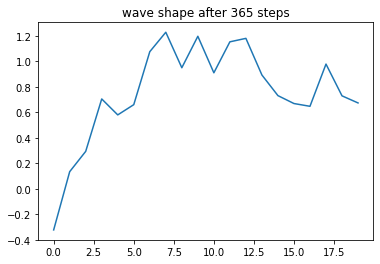

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_365/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_365/model_weights.tf
generator loss:1.6034778678420587
-----------------------


366it [23:02,  5.20s/it]

total discriminator loss:0.3903725730914742
average true return:0.4784142320605002
-----------------------
Training Step: 366
generator loss:1.6229081196119792
-----------------------


367it [23:04,  4.21s/it]

total discriminator loss:0.3960828077561944
average true return:0.46987756104175554
-----------------------
Training Step: 367
generator loss:1.6413757296834723
-----------------------


368it [23:06,  3.52s/it]

total discriminator loss:0.3991097446090226
average true return:0.5072873909864243
-----------------------
Training Step: 368
generator loss:1.6585962099517801
-----------------------


369it [23:08,  3.16s/it]

total discriminator loss:0.37563675306381134
average true return:0.4931443607600059
-----------------------
Training Step: 369
generator loss:1.6817927291227894
-----------------------


370it [23:10,  2.79s/it]

total discriminator loss:0.3953687564426487
average true return:0.4982829820391035
-----------------------
Training Step: 370
event_types: [2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 3, 2, 3, 2, 3, 2, 2, 2, 2]
mad_score: 0.4825875
fid_score: 11734.517912921845
rule_score: 0.3885


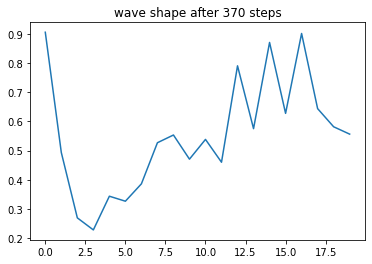

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_370/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_370/model_weights.tf
generator loss:1.7411568443734358
-----------------------


371it [23:21,  5.25s/it]

total discriminator loss:0.3877917021059836
average true return:0.47553353971038237
-----------------------
Training Step: 371
generator loss:1.785480462166737
-----------------------


372it [23:23,  4.25s/it]

total discriminator loss:1.56388225475271
average true return:0.4756183168730317
-----------------------
Training Step: 372
generator loss:1.7914285208494483
-----------------------


373it [23:25,  3.56s/it]

total discriminator loss:0.3706616724075727
average true return:0.47081841824925885
-----------------------
Training Step: 373
generator loss:1.80444877035741
-----------------------


374it [23:27,  3.06s/it]

total discriminator loss:0.4060391611188384
average true return:0.462575091007501
-----------------------
Training Step: 374
generator loss:1.7446773211653872
-----------------------


375it [23:29,  2.72s/it]

total discriminator loss:0.38678434315225824
average true return:0.4778955174886307
-----------------------
Training Step: 375
event_types: [1, 3, 3, 3, 2, 2, 2, 1, 2, 3, 3, 3, 2, 1, 2, 2, 3, 1, 2, 3]
mad_score: 0.4668
fid_score: 10655.262832540599
rule_score: 0.47775


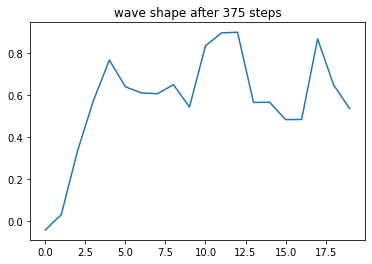

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_375/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_375/model_weights.tf
generator loss:1.7512694461888694
-----------------------


376it [23:40,  5.21s/it]

total discriminator loss:0.40367060162269014
average true return:0.4892502602489226
-----------------------
Training Step: 376
generator loss:1.6503793235770838
-----------------------


377it [23:42,  4.22s/it]

total discriminator loss:0.40659621012528124
average true return:0.5191307045505885
-----------------------
Training Step: 377
generator loss:1.6628638641601452
-----------------------


378it [23:44,  3.53s/it]

total discriminator loss:0.38269561233814586
average true return:0.5003759758206603
-----------------------
Training Step: 378
generator loss:1.6258412317579105
-----------------------


379it [23:45,  3.04s/it]

total discriminator loss:0.4001411215355962
average true return:0.5107499689492201
-----------------------
Training Step: 379
generator loss:1.6291635898658665
-----------------------


380it [23:47,  2.70s/it]

total discriminator loss:0.39809751296106766
average true return:0.4960452373999803
-----------------------
Training Step: 380
event_types: [3, 2, 2, 2, 3, 2, 3, 1, 2, 0, 3, 1, 2, 3, 1, 2, 1, 3, 2, 2]
mad_score: 0.449775
fid_score: 9625.713960070316
rule_score: 0.5745


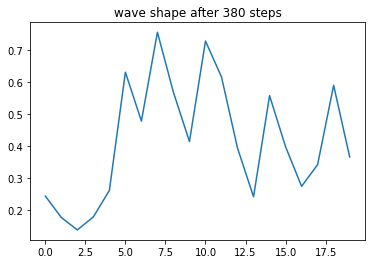

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_380/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_380/model_weights.tf
generator loss:1.7007382705140306
-----------------------


381it [23:58,  5.18s/it]

total discriminator loss:0.37128717243587944
average true return:0.5011205395474447
-----------------------
Training Step: 381
generator loss:1.6524775495736819
-----------------------


382it [24:00,  4.20s/it]

total discriminator loss:0.3786228222467206
average true return:0.49710923982193056
-----------------------
Training Step: 382
generator loss:1.65458147080006
-----------------------


383it [24:02,  3.52s/it]

total discriminator loss:0.4104089278823044
average true return:0.4871258250435773
-----------------------
Training Step: 383
generator loss:1.6608937489180047
-----------------------


384it [24:04,  3.03s/it]

total discriminator loss:0.35686722543320604
average true return:0.4927158756915354
-----------------------
Training Step: 384
generator loss:1.6353507388717945
-----------------------


385it [24:06,  2.70s/it]

total discriminator loss:0.39097338799300596
average true return:0.504276604770661
-----------------------
Training Step: 385
event_types: [1, 2, 1, 2, 2, 2, 1, 2, 0, 2, 1, 3, 3, 2, 2, 3, 3, 2, 0, 2]
mad_score: 0.436875
fid_score: 8796.008807441995
rule_score: 0.648


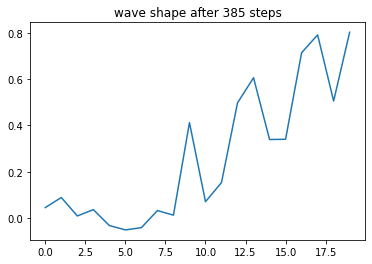

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_385/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_385/model_weights.tf
generator loss:1.6027196056380553
-----------------------


386it [24:17,  5.18s/it]

total discriminator loss:0.39958730723825286
average true return:0.5190669369656766
-----------------------
Training Step: 386
generator loss:1.627937547164327
-----------------------


387it [24:19,  4.19s/it]

total discriminator loss:0.38637680094372795
average true return:0.5215462666650019
-----------------------
Training Step: 387
generator loss:1.6283777034003921
-----------------------


388it [24:21,  3.51s/it]

total discriminator loss:0.3735828899026379
average true return:0.4924121336242643
-----------------------
Training Step: 388
generator loss:1.6787136328779049
-----------------------


389it [24:23,  3.03s/it]

total discriminator loss:0.36970507209550896
average true return:0.5005995097538168
-----------------------
Training Step: 389
generator loss:1.6452824692653691
-----------------------


390it [24:25,  2.69s/it]

total discriminator loss:0.37813102244177615
average true return:0.4984076878606854
-----------------------
Training Step: 390
event_types: [3, 0, 2, 0, 2, 2, 2, 3, 1, 2, 1, 1, 3, 1, 0, 2, 1, 2, 2, 1]
mad_score: 0.4248625
fid_score: 8206.661264390066
rule_score: 0.69


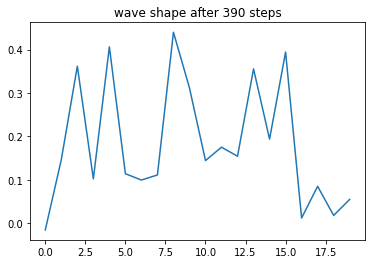

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_390/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_390/model_weights.tf
generator loss:1.6005227900674717
-----------------------


391it [24:36,  5.18s/it]

total discriminator loss:0.3741804813061392
average true return:0.5147731793493909
-----------------------
Training Step: 391
generator loss:1.6191953002415258
-----------------------


392it [24:38,  4.20s/it]

total discriminator loss:0.36678350143715704
average true return:0.5202854588435508
-----------------------
Training Step: 392
generator loss:1.639677589518496
-----------------------


393it [24:39,  3.51s/it]

total discriminator loss:0.37288367314728244
average true return:0.5085367027578632
-----------------------
Training Step: 393
generator loss:1.6633871471153439
-----------------------


394it [24:41,  3.03s/it]

total discriminator loss:0.3795667039585761
average true return:0.5045537628994932
-----------------------
Training Step: 394
generator loss:1.675079360517489
-----------------------


395it [24:43,  2.69s/it]

total discriminator loss:0.36516932839250404
average true return:0.5127124720022987
-----------------------
Training Step: 395
event_types: [2, 2, 3, 1, 2, 2, 0, 3, 3, 2, 2, 2, 3, 2, 2, 3, 3, 1, 2, 3]
mad_score: 0.4166375
fid_score: 7962.860176406025
rule_score: 0.70775


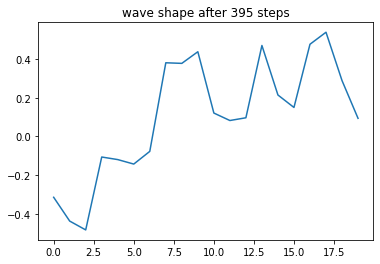

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_395/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_395/model_weights.tf
generator loss:1.6744828306532455
-----------------------


396it [24:55,  5.31s/it]

total discriminator loss:0.3804209193049821
average true return:0.49401793549020984
-----------------------
Training Step: 396
generator loss:1.6797811586984905
-----------------------


397it [24:57,  4.29s/it]

total discriminator loss:0.3641362249821519
average true return:0.5088835795853357
-----------------------
Training Step: 397
generator loss:1.6562535086049657
-----------------------


398it [24:58,  3.58s/it]

total discriminator loss:0.3500334283068294
average true return:0.5247000231962141
-----------------------
Training Step: 398
generator loss:1.702123318122337
-----------------------


399it [25:00,  3.11s/it]

total discriminator loss:0.3625126785174996
average true return:0.5214637926838818
-----------------------
Training Step: 399
generator loss:1.7457162579135241
-----------------------


400it [25:02,  2.75s/it]

total discriminator loss:0.32348273401597194
average true return:0.5088297941044946
-----------------------
Training Step: 400
event_types: [1, 2, 3, 0, 2, 0, 1, 2, 1, 3, 2, 1, 3, 1, 2, 1, 0, 2, 1, 2]
mad_score: 0.4090375
fid_score: 7947.020129334416
rule_score: 0.719


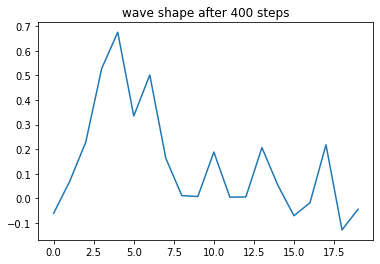

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_400/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_400/model_weights.tf
generator loss:1.836172864737397
-----------------------


401it [25:13,  5.23s/it]

total discriminator loss:0.404974050821612
average true return:0.48280879337549176
-----------------------
Training Step: 401
generator loss:1.826724160248794
-----------------------


402it [25:15,  4.23s/it]

total discriminator loss:0.357486420755202
average true return:0.49251287030360946
-----------------------
Training Step: 402
generator loss:1.7394476659371987
-----------------------


403it [25:17,  3.53s/it]

total discriminator loss:0.32270144066090967
average true return:0.499369281465485
-----------------------
Training Step: 403
generator loss:1.715983117608134
-----------------------


404it [25:19,  3.05s/it]

total discriminator loss:0.33778866217075654
average true return:0.5197325253396552
-----------------------
Training Step: 404
generator loss:1.6678622853774359
-----------------------


405it [25:21,  2.71s/it]

total discriminator loss:0.3541867160376583
average true return:0.5258632368181408
-----------------------
Training Step: 405
event_types: [1, 1, 0, 2, 2, 2, 3, 2, 2, 1, 2, 1, 1, 0, 2, 3, 2, 1, 3, 2]
mad_score: 0.3987125
fid_score: 8123.362843789249
rule_score: 0.7185


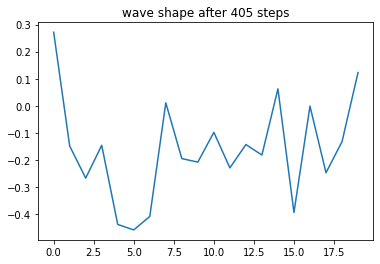

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_405/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_405/model_weights.tf
generator loss:1.791556712064574
-----------------------


406it [25:32,  5.20s/it]

total discriminator loss:0.3362289100415362
average true return:0.5130169787913477
-----------------------
Training Step: 406
generator loss:1.9050920495824486
-----------------------


407it [25:34,  4.22s/it]

total discriminator loss:0.3353140607544247
average true return:0.49392281090980555
-----------------------
Training Step: 407
generator loss:1.9473520805404734
-----------------------


408it [25:36,  3.52s/it]

total discriminator loss:0.32607728500832533
average true return:0.4926376337016739
-----------------------
Training Step: 408
generator loss:1.9284460240824437
-----------------------


409it [25:38,  3.04s/it]

total discriminator loss:0.3545280318612283
average true return:0.4942675902558944
-----------------------
Training Step: 409
generator loss:1.9369909480409149
-----------------------


410it [25:40,  2.70s/it]

total discriminator loss:0.3390327394628289
average true return:0.4964620653990962
-----------------------
Training Step: 410
event_types: [3, 0, 1, 2, 3, 2, 1, 2, 1, 2, 2, 2, 1, 3, 2, 3, 1, 0, 1, 1]
mad_score: 0.392725
fid_score: 8414.11977036827
rule_score: 0.67075


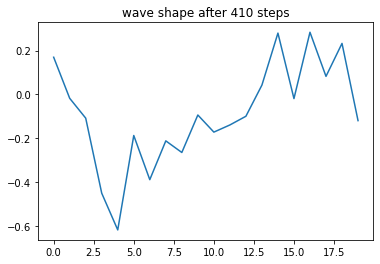

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_410/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_410/model_weights.tf
generator loss:1.9128679914185422
-----------------------


411it [25:51,  5.17s/it]

total discriminator loss:0.3345262892297831
average true return:0.5024733582444324
-----------------------
Training Step: 411
generator loss:1.7901604182469355
-----------------------


412it [25:53,  4.19s/it]

total discriminator loss:0.3443446661793067
average true return:0.5209177690562187
-----------------------
Training Step: 412
generator loss:1.849167401704809
-----------------------


413it [25:54,  3.51s/it]

total discriminator loss:1.7659684421175812
average true return:0.5178592998602314
-----------------------
Training Step: 413
generator loss:1.349388167411624
-----------------------


414it [25:56,  3.03s/it]

total discriminator loss:0.3896944429150901
average true return:0.596975369604883
-----------------------
Training Step: 414
generator loss:1.3700752915500134
-----------------------


415it [25:58,  2.69s/it]

total discriminator loss:0.4278397114477957
average true return:0.5866008964722472
-----------------------
Training Step: 415
event_types: [1, 1, 2, 0, 2, 2, 0, 2, 0, 1, 0, 2, 3, 1, 2, 1, 1, 2, 0, 2]
mad_score: 0.3902875
fid_score: 8847.507780144311
rule_score: 0.61175


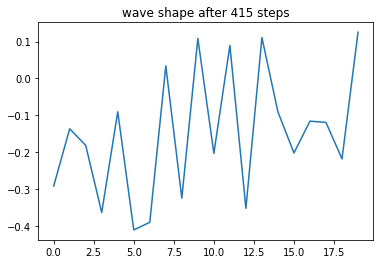

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_415/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_415/model_weights.tf
generator loss:1.733297066118278
-----------------------


416it [26:09,  5.16s/it]

total discriminator loss:0.32707311398240246
average true return:0.5289429385170665
-----------------------
Training Step: 416
generator loss:2.053907778337348
-----------------------


417it [26:11,  4.19s/it]

total discriminator loss:0.34688208945573523
average true return:0.49292615413207924
-----------------------
Training Step: 417
generator loss:2.2041289802796102
-----------------------


418it [26:13,  3.52s/it]

total discriminator loss:0.34680572730154685
average true return:0.4614683907683322
-----------------------
Training Step: 418
generator loss:2.2797835019664503
-----------------------


419it [26:15,  3.03s/it]

total discriminator loss:0.4005724557408161
average true return:0.43679186953427546
-----------------------
Training Step: 419
generator loss:2.2843337974475286
-----------------------


420it [26:17,  2.71s/it]

total discriminator loss:0.3814814935266194
average true return:0.42873342031207684
-----------------------
Training Step: 420
event_types: [1, 1, 2, 1, 0, 2, 0, 1, 2, 2, 0, 1, 1, 1, 2, 2, 0, 2, 1, 1]
mad_score: 0.38605
fid_score: 9368.796569020527
rule_score: 0.47125


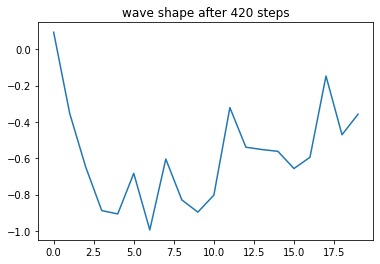

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_420/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_420/model_weights.tf
generator loss:2.1968462603985244
-----------------------
total discriminator loss:0.38535628558096446
average true return:0.45456255850278626
-----------------------


421it [26:33,  6.63s/it]

Training Step: 421
generator loss:2.0828635024436766
-----------------------
total discriminator loss:0.3525838519162767
average true return:0.48572542604284297
-----------------------


422it [26:36,  5.51s/it]

Training Step: 422
generator loss:1.8906347972345476
-----------------------
total discriminator loss:0.34604427253314807
average true return:0.5025768466461884
-----------------------


423it [26:38,  4.71s/it]

Training Step: 423
generator loss:1.6956977694736874
-----------------------
total discriminator loss:0.3567178861658489
average true return:0.5284400752879173
-----------------------


424it [26:41,  4.16s/it]

Training Step: 424
generator loss:1.5092901330493607
-----------------------
total discriminator loss:0.38662611393133217
average true return:0.5687240344030371
-----------------------


425it [26:45,  3.92s/it]

Training Step: 425
event_types: [0, 2, 2, 2, 1, 3, 1, 2, 2, 3, 2, 3, 1, 1, 2, 2, 2, 2, 0, 2]
mad_score: 0.3862125
fid_score: 9989.972678229751
rule_score: 0.34725


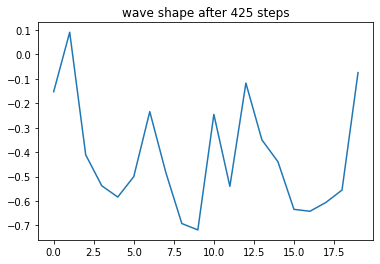

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_425/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_425/model_weights.tf
generator loss:1.5983196989866024
-----------------------
total discriminator loss:0.37503167634611967
average true return:0.5406315789551566
-----------------------


426it [27:01,  7.67s/it]

Training Step: 426
generator loss:1.752860099137886
-----------------------
total discriminator loss:0.36139748639380687
average true return:0.5290241721803842
-----------------------


427it [27:04,  6.19s/it]

Training Step: 427
generator loss:1.9281368176344125
-----------------------
total discriminator loss:0.37242465643154604
average true return:0.5039677744860149
-----------------------


428it [27:07,  5.16s/it]

Training Step: 428
generator loss:2.0461050999060313
-----------------------
total discriminator loss:0.35895440354450336
average true return:0.48682834832781313
-----------------------


429it [27:09,  4.46s/it]

Training Step: 429
generator loss:2.1025332562180457
-----------------------
total discriminator loss:0.3672434029435443
average true return:0.4809540414432697
-----------------------


430it [27:12,  3.95s/it]

Training Step: 430
event_types: [0, 2, 3, 0, 2, 0, 2, 1, 2, 1, 3, 2, 1, 1, 1, 2, 2, 1, 2, 1]
mad_score: 0.3885375
fid_score: 10845.18500900203
rule_score: 0.20875


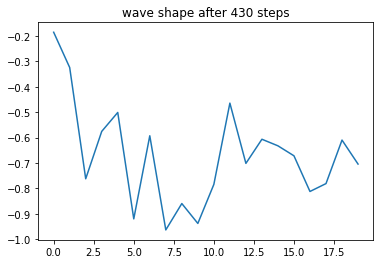

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_430/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_430/model_weights.tf
generator loss:2.1136130999945206
-----------------------


431it [27:24,  6.22s/it]

total discriminator loss:0.3521128962605098
average true return:0.46648104571542237
-----------------------
Training Step: 431
generator loss:2.1761176877927157
-----------------------


432it [27:26,  4.93s/it]

total discriminator loss:0.3697482299303012
average true return:0.47788103520731723
-----------------------
Training Step: 432
generator loss:2.1105656761575
-----------------------


433it [27:28,  4.02s/it]

total discriminator loss:0.3691885094090039
average true return:0.46154676277630224
-----------------------
Training Step: 433
generator loss:2.048133298320754
-----------------------


434it [27:29,  3.39s/it]

total discriminator loss:0.3825084329247085
average true return:0.4954026040875423
-----------------------
Training Step: 434
generator loss:1.8799329214789515
-----------------------


435it [27:31,  2.95s/it]

total discriminator loss:1.7376101390754137
average true return:0.5134849065385223
-----------------------
Training Step: 435
event_types: [1, 1, 2, 0, 1, 1, 2, 2, 0, 2, 1, 2, 1, 2, 1, 0, 1, 1, 2, 2]
mad_score: 0.391725
fid_score: 11680.860381799012
rule_score: 0.1155


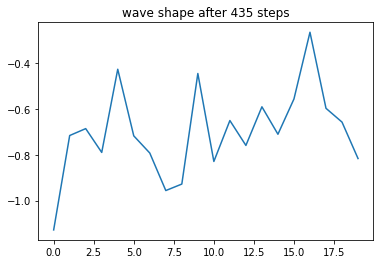

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_435/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_435/model_weights.tf
generator loss:1.5712419600247243
-----------------------


436it [27:42,  5.31s/it]

total discriminator loss:0.3793414049635281
average true return:0.5593963890241334
-----------------------
Training Step: 436
generator loss:1.368508236481965
-----------------------


437it [27:44,  4.29s/it]

total discriminator loss:0.405273040666996
average true return:0.5824331970752205
-----------------------
Training Step: 437
generator loss:1.3390636300278327
-----------------------


438it [27:46,  3.58s/it]

total discriminator loss:0.37546609117743646
average true return:0.5945214005594115
-----------------------
Training Step: 438
generator loss:1.4592749349646232
-----------------------


439it [27:48,  3.08s/it]

total discriminator loss:0.4062872726965665
average true return:0.571370322612167
-----------------------
Training Step: 439
generator loss:1.7639982503475449
-----------------------


440it [27:50,  2.73s/it]

total discriminator loss:0.3433941052277263
average true return:0.5270088562270969
-----------------------
Training Step: 440
event_types: [2, 3, 2, 1, 2, 2, 0, 2, 1, 2, 1, 0, 1, 2, 0, 1, 1, 1, 2, 1]
mad_score: 0.393875
fid_score: 12804.282799924065
rule_score: 0.05775


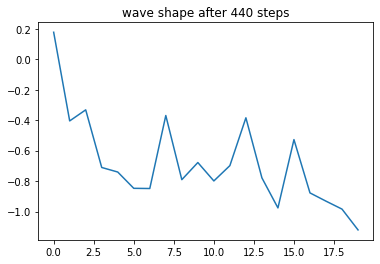

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_440/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_440/model_weights.tf
generator loss:1.908275057636329
-----------------------


441it [28:01,  5.16s/it]

total discriminator loss:0.3519199976514905
average true return:0.5004462196321594
-----------------------
Training Step: 441
generator loss:2.050876437707835
-----------------------


442it [28:03,  4.18s/it]

total discriminator loss:0.3704960446725033
average true return:0.4758194229386538
-----------------------
Training Step: 442
generator loss:2.155866588009459
-----------------------


443it [28:04,  3.50s/it]

total discriminator loss:0.37375748464735004
average true return:0.4592256385748583
-----------------------
Training Step: 443
generator loss:2.182146347455153
-----------------------


444it [28:06,  3.02s/it]

total discriminator loss:0.3981965714209031
average true return:0.4441015591389482
-----------------------
Training Step: 444
generator loss:2.1767252290296284
-----------------------
total discriminator loss:0.38443521065253883
average true return:0.4378732244964181
-----------------------


445it [28:08,  2.71s/it]

Training Step: 445
event_types: [0, 2, 0, 2, 1, 1, 0, 2, 2, 2, 3, 0, 1, 0, 1, 1, 2, 2, 1, 2]
mad_score: 0.393475
fid_score: 14110.815385154978
rule_score: 0.03425


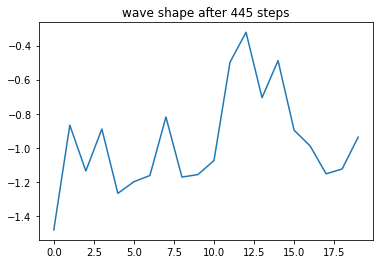

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_445/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_445/model_weights.tf
generator loss:2.1105576442246488
-----------------------


446it [28:19,  5.14s/it]

total discriminator loss:0.3609939127639926
average true return:0.46677911214312834
-----------------------
Training Step: 446
generator loss:2.0036941879983914
-----------------------


447it [28:21,  4.17s/it]

total discriminator loss:0.36391258448996294
average true return:0.47580118297922824
-----------------------
Training Step: 447
generator loss:1.904813282697545
-----------------------


448it [28:23,  3.49s/it]

total discriminator loss:0.3441825338183203
average true return:0.49750328591078574
-----------------------
Training Step: 448
generator loss:1.7529551463272592
-----------------------


449it [28:25,  3.02s/it]

total discriminator loss:0.35185958540731593
average true return:0.5176408262495794
-----------------------
Training Step: 449
generator loss:1.6600320786580238
-----------------------


450it [28:27,  2.69s/it]

total discriminator loss:0.37173346121870404
average true return:0.5405614084835972
-----------------------
Training Step: 450
event_types: [3, 2, 1, 0, 2, 1, 0, 1, 2, 1, 1, 1, 1, 1, 0, 1, 0, 2, 2, 1]
mad_score: 0.39345
fid_score: 15732.059420511829
rule_score: 0.032


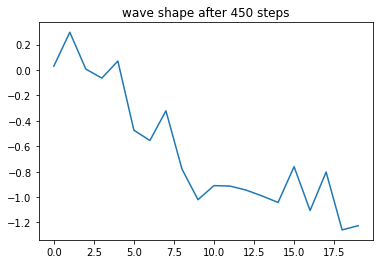

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_450/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_450/model_weights.tf
generator loss:1.6660839046193097
-----------------------


451it [28:38,  5.12s/it]

total discriminator loss:0.34024076279438875
average true return:0.5350714646213385
-----------------------
Training Step: 451
generator loss:1.5781810579085223
-----------------------


452it [28:40,  4.28s/it]

total discriminator loss:0.36917941966655976
average true return:0.5444613008030432
-----------------------
Training Step: 452
generator loss:1.653102841032236
-----------------------


453it [28:42,  3.57s/it]

total discriminator loss:0.3537786410488846
average true return:0.540272245821716
-----------------------
Training Step: 453
generator loss:1.6467055503400831
-----------------------


454it [28:44,  3.08s/it]

total discriminator loss:0.35975811866007423
average true return:0.5355880799164551
-----------------------
Training Step: 454
generator loss:1.7711901656288547
-----------------------


455it [28:46,  2.73s/it]

total discriminator loss:0.3380282098200359
average true return:0.5177907180995183
-----------------------
Training Step: 455
event_types: [3, 2, 0, 2, 2, 0, 1, 0, 0, 1, 2, 1, 0, 1, 0, 1, 1, 2, 1, 1]
mad_score: 0.3974625
fid_score: 17455.63982909346
rule_score: 0.0265


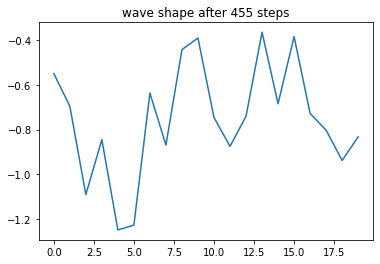

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_455/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_455/model_weights.tf
generator loss:1.8182523169434495
-----------------------


456it [28:57,  5.16s/it]

total discriminator loss:0.36376368552269445
average true return:0.508790770395743
-----------------------
Training Step: 456
generator loss:1.9055780218876792
-----------------------


457it [28:58,  4.18s/it]

total discriminator loss:0.33175282960474944
average true return:0.5117728026850614
-----------------------
Training Step: 457
generator loss:1.9941192747979413
-----------------------


458it [29:00,  3.50s/it]

total discriminator loss:0.3496777038945934
average true return:0.5002598789271946
-----------------------
Training Step: 458
generator loss:2.038885733352873
-----------------------


459it [29:02,  3.03s/it]

total discriminator loss:0.33118382170669314
average true return:0.5006051706967402
-----------------------
Training Step: 459
generator loss:2.0377045381542502
-----------------------


460it [29:04,  2.69s/it]

total discriminator loss:1.8354162442212005
average true return:0.4946265797433267
-----------------------
Training Step: 460
event_types: [0, 2, 1, 0, 2, 2, 0, 2, 0, 2, 1, 1, 0, 1, 1, 0, 2, 0, 2, 0]
mad_score: 0.405525
fid_score: 19516.184012892747
rule_score: 0.02975


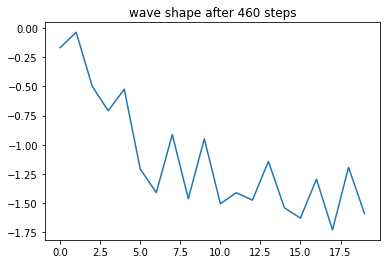

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_460/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_460/model_weights.tf
generator loss:2.0117712817010127
-----------------------


461it [29:15,  5.13s/it]

total discriminator loss:0.3439672652540957
average true return:0.503029944102228
-----------------------
Training Step: 461
generator loss:1.9549867462844261
-----------------------


462it [29:17,  4.17s/it]

total discriminator loss:0.3289234355368391
average true return:0.502826535573429
-----------------------
Training Step: 462
generator loss:1.88232718888179
-----------------------


463it [29:19,  3.49s/it]

total discriminator loss:0.35275227713495416
average true return:0.5027124581130765
-----------------------
Training Step: 463
generator loss:1.8271670515227565
-----------------------


464it [29:21,  3.02s/it]

total discriminator loss:0.34026109707705365
average true return:0.5170088441379113
-----------------------
Training Step: 464
generator loss:1.783507945098234
-----------------------


465it [29:23,  2.69s/it]

total discriminator loss:0.34558709007798516
average true return:0.5149929886688109
-----------------------
Training Step: 465
event_types: [3, 2, 1, 1, 1, 1, 0, 2, 0, 1, 0, 2, 3, 0, 1, 0, 1, 1, 2, 1]
mad_score: 0.411625
fid_score: 22478.206599183497
rule_score: 0.0265


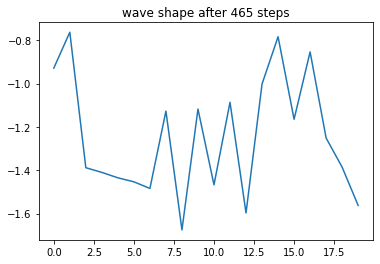

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_465/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_465/model_weights.tf
generator loss:1.695344510825432
-----------------------
total discriminator loss:0.3458462988626725
average true return:0.5119738254901426
-----------------------


466it [29:34,  5.17s/it]

Training Step: 466
generator loss:1.7230432071457635
-----------------------
total discriminator loss:0.3555732540064073
average true return:0.5361216832197733
-----------------------


467it [29:36,  4.46s/it]

Training Step: 467
generator loss:1.6817301268041671
-----------------------
total discriminator loss:0.34731672008868963
average true return:0.5241669738051259
-----------------------


468it [29:39,  3.98s/it]

Training Step: 468
generator loss:1.730711230948328
-----------------------
total discriminator loss:0.3461335502119334
average true return:0.5244912861978328
-----------------------


469it [29:42,  3.64s/it]

Training Step: 469
generator loss:1.694400118757564
-----------------------


470it [29:45,  3.27s/it]

total discriminator loss:1.680594399812298
average true return:0.5196677452378001
-----------------------
Training Step: 470
event_types: [1, 3, 2, 1, 1, 2, 1, 3, 0, 1, 1, 0, 0, 0, 1, 0, 1, 2, 0, 1]
mad_score: 0.4217625
fid_score: 26122.05356001271
rule_score: 0.02725


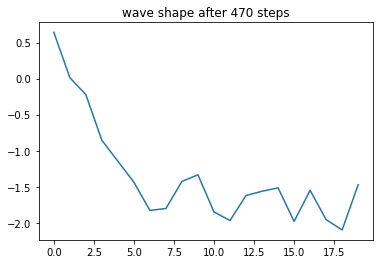

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_470/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_470/model_weights.tf
generator loss:1.6888759513117306
-----------------------


471it [29:56,  5.60s/it]

total discriminator loss:0.330849305510057
average true return:0.5251497567436986
-----------------------
Training Step: 471
generator loss:1.608364507222422
-----------------------


472it [29:58,  4.50s/it]

total discriminator loss:0.3815943824595865
average true return:0.538884853954323
-----------------------
Training Step: 472
generator loss:1.5527331328995697
-----------------------


473it [29:59,  3.73s/it]

total discriminator loss:0.35367999800978633
average true return:0.5342400312055254
-----------------------
Training Step: 473
generator loss:1.57732450106121
-----------------------


474it [30:01,  3.19s/it]

total discriminator loss:0.34868363704728167
average true return:0.5386046951549625
-----------------------
Training Step: 474
generator loss:1.5464730229489043
-----------------------


475it [30:03,  2.81s/it]

total discriminator loss:0.3571055644469923
average true return:0.5375316761480353
-----------------------
Training Step: 475
event_types: [2, 1, 0, 1, 2, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1]
mad_score: 0.4317375
fid_score: 31684.498246996867
rule_score: 0.01625


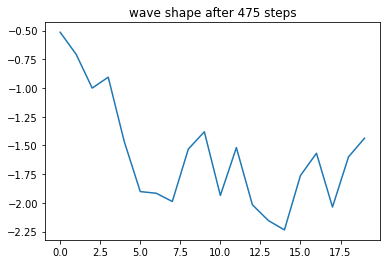

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_475/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_475/model_weights.tf
generator loss:1.5358136725086249
-----------------------


476it [30:14,  5.24s/it]

total discriminator loss:0.3396435814183547
average true return:0.5333222414137155
-----------------------
Training Step: 476
generator loss:1.5926159462242078
-----------------------


477it [30:16,  4.25s/it]

total discriminator loss:0.36875321057605714
average true return:0.5241068176787567
-----------------------
Training Step: 477
generator loss:1.6133386469907285
-----------------------


478it [30:18,  3.55s/it]

total discriminator loss:0.34249901007289774
average true return:0.518770154619647
-----------------------
Training Step: 478
generator loss:1.6519810236544532
-----------------------


479it [30:20,  3.07s/it]

total discriminator loss:0.3710593437016548
average true return:0.5206309421448396
-----------------------
Training Step: 479
generator loss:1.6912982576953122
-----------------------


480it [30:22,  2.73s/it]

total discriminator loss:0.3316640973099549
average true return:0.5230753877762983
-----------------------
Training Step: 480
event_types: [0, 1, 2, 1, 2, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0]
mad_score: 0.4425875
fid_score: 38647.31881250795
rule_score: 0.014


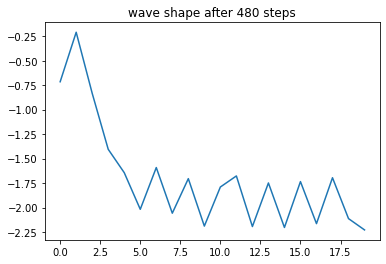

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_480/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_480/model_weights.tf
generator loss:1.7234864387223128
-----------------------
total discriminator loss:0.33588512035377455
average true return:0.5123985427799238
-----------------------


481it [30:38,  6.87s/it]

Training Step: 481
generator loss:1.7297115570055759
-----------------------


482it [30:41,  5.55s/it]

total discriminator loss:0.3561550808283195
average true return:0.5118695640100592
-----------------------
Training Step: 482
generator loss:1.7700005286818827
-----------------------


483it [30:43,  4.46s/it]

total discriminator loss:0.36289514205128826
average true return:0.503138579628382
-----------------------
Training Step: 483
generator loss:1.7742655588188716
-----------------------


484it [30:45,  3.70s/it]

total discriminator loss:0.3217056169206367
average true return:0.5006793973030954
-----------------------
Training Step: 484
generator loss:1.8665683548852219
-----------------------


485it [30:47,  3.17s/it]

total discriminator loss:0.34737892414495253
average true return:0.5061819539769056
-----------------------
Training Step: 485
event_types: [2, 1, 2, 2, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0]
mad_score: 0.4462875
fid_score: 51626.42745506959
rule_score: 0.0135


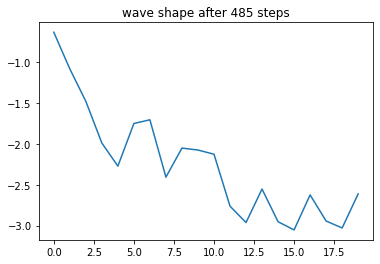

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_485/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_485/model_weights.tf
generator loss:1.8351769022889286
-----------------------


486it [30:58,  5.51s/it]

total discriminator loss:0.3586808414113586
average true return:0.5005283836383675
-----------------------
Training Step: 486
generator loss:1.8598450906944044
-----------------------


487it [31:00,  4.44s/it]

total discriminator loss:0.36579139603567323
average true return:0.5014735191327169
-----------------------
Training Step: 487
generator loss:1.8619836762696593
-----------------------


488it [31:02,  3.69s/it]

total discriminator loss:0.3390530081736398
average true return:0.5024343551200349
-----------------------
Training Step: 488
generator loss:1.8594647473826877
-----------------------


489it [31:04,  3.16s/it]

total discriminator loss:0.3445403826250415
average true return:0.5017609078696752
-----------------------
Training Step: 489
generator loss:1.8559620826371417
-----------------------


490it [31:05,  2.79s/it]

total discriminator loss:0.37002451699417616
average true return:0.5043970603842497
-----------------------
Training Step: 490
event_types: [0, 2, 3, 1, 0, 2, 0, 2, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1]
mad_score: 0.451875
fid_score: 71068.83485663873
rule_score: 0.00775


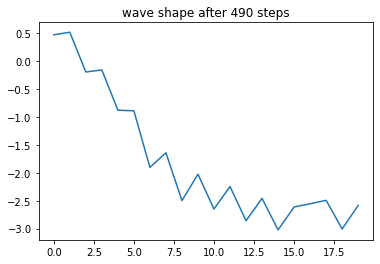

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_490/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_490/model_weights.tf
generator loss:1.8620625277660583
-----------------------


491it [31:16,  5.24s/it]

total discriminator loss:0.3529596686910136
average true return:0.5073844812297095
-----------------------
Training Step: 491
generator loss:1.883518295691268
-----------------------


492it [31:18,  4.24s/it]

total discriminator loss:0.336619363789569
average true return:0.5077772948191219
-----------------------
Training Step: 492
generator loss:1.856342396192894
-----------------------


493it [31:20,  3.55s/it]

total discriminator loss:0.31529028577313145
average true return:0.5135344609340016
-----------------------
Training Step: 493
generator loss:1.861893912002543
-----------------------


494it [31:22,  3.07s/it]

total discriminator loss:0.3267494556250291
average true return:0.5113253631356759
-----------------------
Training Step: 494
generator loss:1.8648508478426375
-----------------------
total discriminator loss:0.32918203619273795
average true return:0.5175064650547382
-----------------------


495it [31:24,  2.77s/it]

Training Step: 495
event_types: [1, 2, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0]
mad_score: 0.456075
fid_score: 104089.80406515503
rule_score: 0.0045


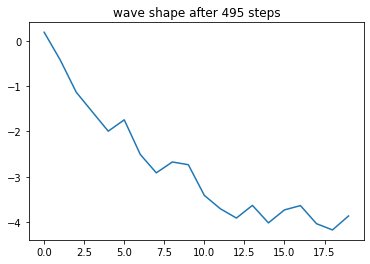

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_495/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_495/model_weights.tf
generator loss:1.8508400595683001
-----------------------


496it [31:35,  5.30s/it]

total discriminator loss:0.35316692678387973
average true return:0.5248525657546601
-----------------------
Training Step: 496
generator loss:1.878822865605201
-----------------------


497it [31:37,  4.30s/it]

total discriminator loss:0.35363202465849497
average true return:0.5128069460807037
-----------------------
Training Step: 497
generator loss:1.8623510849368086
-----------------------


498it [31:39,  3.59s/it]

total discriminator loss:0.31655596184263757
average true return:0.5184573665605801
-----------------------
Training Step: 498
generator loss:1.8851847787226519
-----------------------


499it [31:41,  3.09s/it]

total discriminator loss:0.3278797374735694
average true return:0.5204494252786516
-----------------------
Training Step: 499
generator loss:1.8713225408819998
-----------------------


500it [31:43,  2.74s/it]

total discriminator loss:0.30810324061320354
average true return:0.5186335987192965
-----------------------
Training Step: 500
event_types: [1, 2, 1, 2, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
mad_score: 0.464275
fid_score: 147548.6895024277
rule_score: 0.00275


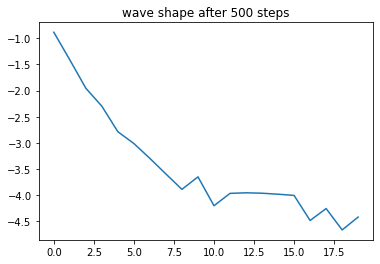

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_500/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_500/model_weights.tf
generator loss:1.8845927364812027
-----------------------


501it [31:54,  5.18s/it]

total discriminator loss:0.33175051784090354
average true return:0.5159354967316785
-----------------------
Training Step: 501
generator loss:1.898118038978905
-----------------------


502it [31:56,  4.20s/it]

total discriminator loss:0.32284257403335404
average true return:0.5200732014710537
-----------------------
Training Step: 502
generator loss:1.915977771729163
-----------------------


503it [31:58,  3.52s/it]

total discriminator loss:0.3331188767988393
average true return:0.516701252548211
-----------------------
Training Step: 503
generator loss:1.9248185956102124
-----------------------


504it [32:00,  3.04s/it]

total discriminator loss:0.33726763118395386
average true return:0.5176625316006891
-----------------------
Training Step: 504
generator loss:1.932918268571767
-----------------------


505it [32:02,  2.71s/it]

total discriminator loss:0.2962321361329243
average true return:0.5184602363055502
-----------------------
Training Step: 505
event_types: [1, 1, 0, 2, 3, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0]
mad_score: 0.48195
fid_score: 199360.58495512418
rule_score: 0.0035


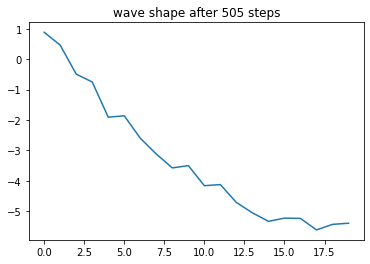

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_505/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_505/model_weights.tf
generator loss:1.9482979614396532
-----------------------


506it [32:13,  5.16s/it]

total discriminator loss:0.3152656950763022
average true return:0.518048876060131
-----------------------
Training Step: 506
generator loss:1.9542941732565515
-----------------------


507it [32:15,  4.19s/it]

total discriminator loss:0.3394346230294905
average true return:0.5181923410653702
-----------------------
Training Step: 507
generator loss:1.981201558201001
-----------------------


508it [32:17,  3.51s/it]

total discriminator loss:0.3133183116170422
average true return:0.5186077517858303
-----------------------
Training Step: 508
generator loss:1.9927727414512917
-----------------------


509it [32:18,  3.04s/it]

total discriminator loss:0.33439849730120297
average true return:0.5174367799826525
-----------------------
Training Step: 509
generator loss:2.0157284237869617
-----------------------


510it [32:20,  2.70s/it]

total discriminator loss:0.31408296536475605
average true return:0.5160103424146456
-----------------------
Training Step: 510
event_types: [1, 1, 0, 0, 2, 0, 0, 1, 0, 1, 1, 0, 2, 0, 1, 1, 0, 0, 1, 1]
mad_score: 0.51895
fid_score: 253465.69643608123
rule_score: 0.00175


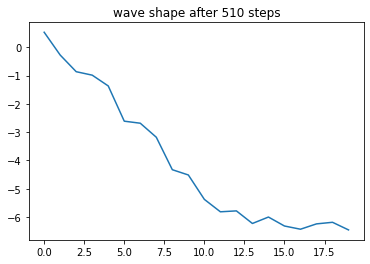

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_510/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_510/model_weights.tf
generator loss:2.0106541103727746
-----------------------


511it [32:32,  5.29s/it]

total discriminator loss:0.33416574586802494
average true return:0.5157829985650373
-----------------------
Training Step: 511
generator loss:2.031606891505358
-----------------------


512it [32:34,  4.29s/it]

total discriminator loss:0.3311461399622865
average true return:0.5128567681533378
-----------------------
Training Step: 512
generator loss:2.0490617268722997
-----------------------


513it [32:36,  3.60s/it]

total discriminator loss:0.2900508522418615
average true return:0.515616911229805
-----------------------
Training Step: 513
generator loss:2.054794652978769
-----------------------


514it [32:38,  3.10s/it]

total discriminator loss:0.3282426025059029
average true return:0.5142711676419338
-----------------------
Training Step: 514
generator loss:2.0649562718963805
-----------------------


515it [32:40,  2.76s/it]

total discriminator loss:0.31085864338624747
average true return:0.5152839339167479
-----------------------
Training Step: 515
event_types: [2, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1]
mad_score: 0.5664125
fid_score: 310223.78522512154
rule_score: 0.00175


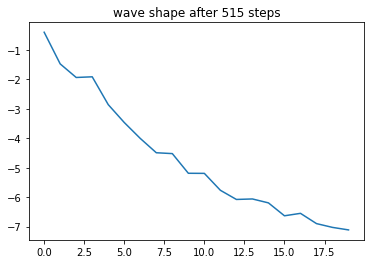

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_515/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_515/model_weights.tf
generator loss:2.076042802635559
-----------------------


516it [32:50,  5.19s/it]

total discriminator loss:0.3268826423868565
average true return:0.5116424936715882
-----------------------
Training Step: 516
generator loss:2.097642936946066
-----------------------


517it [32:52,  4.22s/it]

total discriminator loss:0.3055907703403937
average true return:0.5128015568143256
-----------------------
Training Step: 517
generator loss:2.089013985319188
-----------------------


518it [32:54,  3.53s/it]

total discriminator loss:0.3070518861622483
average true return:0.5138486803561917
-----------------------
Training Step: 518
generator loss:2.088875461092604
-----------------------


519it [32:56,  3.06s/it]

total discriminator loss:0.3115114725010637
average true return:0.5133508029478449
-----------------------
Training Step: 519
generator loss:2.099483868375558
-----------------------


520it [32:58,  2.72s/it]

total discriminator loss:0.33668629156470586
average true return:0.5129004162877384
-----------------------
Training Step: 520
event_types: [0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1]
mad_score: 0.6360875
fid_score: 379668.6451036512
rule_score: 0.0


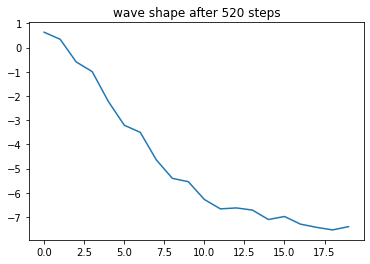

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_520/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_520/model_weights.tf
generator loss:2.114659363541449
-----------------------


521it [33:09,  5.21s/it]

total discriminator loss:0.3241962019260184
average true return:0.5128364647750626
-----------------------
Training Step: 521
generator loss:2.11446163763454
-----------------------


522it [33:11,  4.22s/it]

total discriminator loss:0.3029999630292788
average true return:0.512716317544673
-----------------------
Training Step: 522
generator loss:2.1206416578242977
-----------------------


523it [33:13,  3.54s/it]

total discriminator loss:0.30215678826655185
average true return:0.5123978320222364
-----------------------
Training Step: 523
generator loss:2.1300849851672465
-----------------------


524it [33:15,  3.05s/it]

total discriminator loss:0.30013111053525543
average true return:0.5132978421633522
-----------------------
Training Step: 524
generator loss:2.1407281629666723
-----------------------


525it [33:17,  2.71s/it]

total discriminator loss:0.31726598511625914
average true return:0.5129672515535861
-----------------------
Training Step: 525
event_types: [1, 1, 3, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mad_score: 0.70765
fid_score: 452376.97576888534
rule_score: 0.0


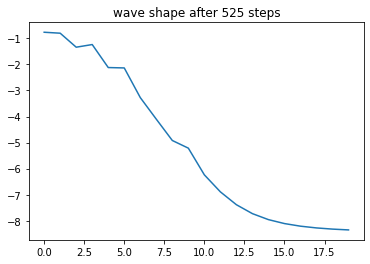

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_525/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_525/model_weights.tf
generator loss:2.1501609890194073
-----------------------


526it [33:28,  5.19s/it]

total discriminator loss:0.31118780696022874
average true return:0.5115772837181647
-----------------------
Training Step: 526
generator loss:2.1551163104493978
-----------------------


527it [33:30,  4.21s/it]

total discriminator loss:0.32199686836755476
average true return:0.5108730016163351
-----------------------
Training Step: 527
generator loss:2.1575455984496608
-----------------------


528it [33:32,  3.53s/it]

total discriminator loss:0.3376198390373106
average true return:0.5115699830522492
-----------------------
Training Step: 528
generator loss:2.1744783593187886
-----------------------


529it [33:34,  3.05s/it]

total discriminator loss:0.32601257017105756
average true return:0.5118555802168522
-----------------------
Training Step: 529
generator loss:2.170454452376524
-----------------------


530it [33:36,  2.72s/it]

total discriminator loss:0.33299266887942996
average true return:0.5093369642505405
-----------------------
Training Step: 530
event_types: [3, 1, 1, 2, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0]
mad_score: 0.7653125
fid_score: 537395.9437974745
rule_score: 0.0


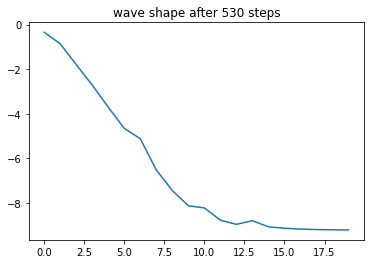

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_530/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_530/model_weights.tf
generator loss:2.170397004758194
-----------------------


531it [33:47,  5.20s/it]

total discriminator loss:0.31614390923043656
average true return:0.5112532826570694
-----------------------
Training Step: 531
generator loss:2.172063764764251
-----------------------


532it [33:49,  4.22s/it]

total discriminator loss:0.3523300471560614
average true return:0.5091499875954373
-----------------------
Training Step: 532
generator loss:2.179008881645452
-----------------------


533it [33:51,  3.53s/it]

total discriminator loss:0.3222706635065584
average true return:0.5116698929325862
-----------------------
Training Step: 533
generator loss:2.186424871788519
-----------------------


534it [33:52,  3.05s/it]

total discriminator loss:0.31039726552263686
average true return:0.5096263777116078
-----------------------
Training Step: 534
generator loss:2.189195949829923
-----------------------


535it [33:54,  2.72s/it]

total discriminator loss:0.2979166296448246
average true return:0.5125448194727911
-----------------------
Training Step: 535
event_types: [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mad_score: 0.7977875
fid_score: 627471.2492998947
rule_score: 0.0


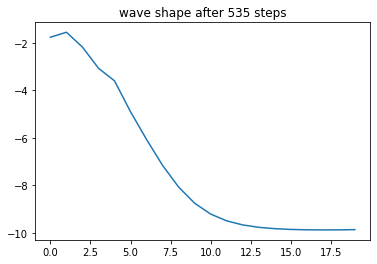

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_535/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_535/model_weights.tf
generator loss:2.186071431868299
-----------------------


536it [34:05,  5.18s/it]

total discriminator loss:0.28952298186591363
average true return:0.5113671684109086
-----------------------
Training Step: 536
generator loss:2.1895877473531655
-----------------------


537it [34:07,  4.20s/it]

total discriminator loss:0.3344469471101023
average true return:0.513393888934889
-----------------------
Training Step: 537
generator loss:2.1876924148833936
-----------------------


538it [34:09,  3.52s/it]

total discriminator loss:0.28144596382181614
average true return:0.5097489974921816
-----------------------
Training Step: 538
generator loss:2.19796584609423
-----------------------


539it [34:12,  3.17s/it]

total discriminator loss:0.31018483711730305
average true return:0.5107293361549059
-----------------------
Training Step: 539
generator loss:2.1989080245245756
-----------------------


540it [34:13,  2.80s/it]

total discriminator loss:0.31002916772551814
average true return:0.5095372069623455
-----------------------
Training Step: 540
event_types: [2, 2, 0, 1, 3, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mad_score: 0.8196875
fid_score: 734417.3488461795
rule_score: 0.0


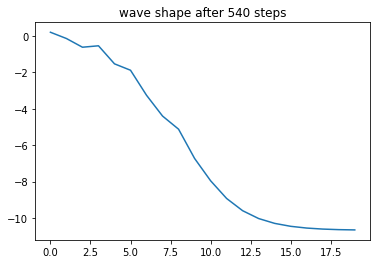

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_540/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_540/model_weights.tf
generator loss:2.2074779009539895
-----------------------


541it [34:24,  5.24s/it]

total discriminator loss:0.33433729866842354
average true return:0.5093308254571923
-----------------------
Training Step: 541
generator loss:2.2086926897823655
-----------------------


542it [34:26,  4.25s/it]

total discriminator loss:0.32013419093827283
average true return:0.5104984148514757
-----------------------
Training Step: 542
generator loss:2.2174674065844915
-----------------------


543it [34:28,  3.56s/it]

total discriminator loss:0.3219607722858249
average true return:0.5103352325995982
-----------------------
Training Step: 543
generator loss:2.2209682674597673
-----------------------


544it [34:30,  3.09s/it]

total discriminator loss:0.30759784863606277
average true return:0.5073981339686573
-----------------------
Training Step: 544
generator loss:2.2356769213369203
-----------------------


545it [34:32,  2.76s/it]

total discriminator loss:0.3376439735018523
average true return:0.507104089396707
-----------------------
Training Step: 545
event_types: [1, 0, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mad_score: 0.8330375
fid_score: 850605.1446564416
rule_score: 0.0


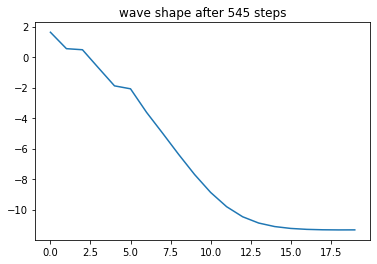

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_545/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_545/model_weights.tf
generator loss:2.224088249314517
-----------------------


546it [34:43,  5.23s/it]

total discriminator loss:2.061207929284665
average true return:0.509265518474207
-----------------------
Training Step: 546
generator loss:2.1638926864146373
-----------------------


547it [34:45,  4.24s/it]

total discriminator loss:0.2979590040280058
average true return:0.509830716754434
-----------------------
Training Step: 547
generator loss:2.1168055271824016
-----------------------


548it [34:47,  3.55s/it]

total discriminator loss:0.32410493493482545
average true return:0.5088113794872613
-----------------------
Training Step: 548
generator loss:2.0820393293081225
-----------------------


549it [34:49,  3.06s/it]

total discriminator loss:0.3559411815679222
average true return:0.5107353373542941
-----------------------
Training Step: 549
generator loss:2.0407904913999575
-----------------------


550it [34:51,  2.72s/it]

total discriminator loss:0.3444176718926547
average true return:0.5121864568751464
-----------------------
Training Step: 550
event_types: [0, 3, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mad_score: 0.8410125
fid_score: 969955.2812885563
rule_score: 0.0


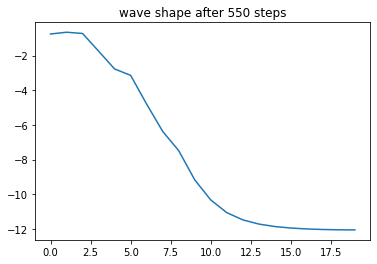

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_550/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_550/model_weights.tf
generator loss:2.011424588287091
-----------------------


551it [35:02,  5.20s/it]

total discriminator loss:0.3109294836914108
average true return:0.513826296738934
-----------------------
Training Step: 551
generator loss:1.9759895397439076
-----------------------


552it [35:04,  4.23s/it]

total discriminator loss:0.30024217752737375
average true return:0.5139287256943018
-----------------------
Training Step: 552
generator loss:1.956491416464384
-----------------------


553it [35:06,  3.54s/it]

total discriminator loss:0.32546970460016145
average true return:0.5144697717775515
-----------------------
Training Step: 553
generator loss:1.9435388390854498
-----------------------


554it [35:08,  3.06s/it]

total discriminator loss:0.301944571677873
average true return:0.5146726623120389
-----------------------
Training Step: 554
generator loss:1.9281204247043964
-----------------------


555it [35:10,  2.72s/it]

total discriminator loss:0.3290901093433925
average true return:0.51580319587528
-----------------------
Training Step: 555
event_types: [1, 3, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mad_score: 0.8436875
fid_score: 1092686.6374699026
rule_score: 0.0


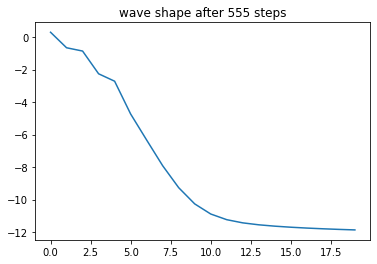

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_555/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_555/model_weights.tf
generator loss:1.9242000341214778
-----------------------


556it [35:21,  5.17s/it]

total discriminator loss:0.33829676526808106
average true return:0.5151783668140897
-----------------------
Training Step: 556
generator loss:1.915358119410157
-----------------------


557it [35:23,  4.20s/it]

total discriminator loss:0.33463464499790874
average true return:0.5158814905719664
-----------------------
Training Step: 557
generator loss:1.915318927671496
-----------------------


558it [35:24,  3.52s/it]

total discriminator loss:0.317072262765606
average true return:0.5159846732558213
-----------------------
Training Step: 558
generator loss:1.9040975634753243
-----------------------


559it [35:26,  3.05s/it]

total discriminator loss:0.3401482886233052
average true return:0.5128073771988086
-----------------------
Training Step: 559
generator loss:1.9163275142418161
-----------------------


560it [35:28,  2.71s/it]

total discriminator loss:0.3172280867170799
average true return:0.512815139506639
-----------------------
Training Step: 560
event_types: [0, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mad_score: 0.8483625
fid_score: 1221416.8873299113
rule_score: 0.0


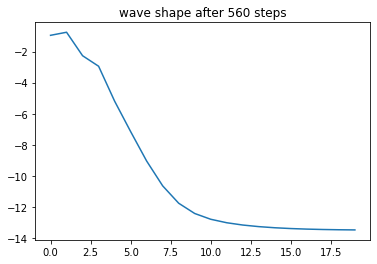

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_560/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_560/model_weights.tf
generator loss:1.9243271492938734
-----------------------


561it [35:39,  5.15s/it]

total discriminator loss:0.3423885330657896
average true return:0.5130064651856467
-----------------------
Training Step: 561
generator loss:1.9398739708942967
-----------------------


562it [35:41,  4.19s/it]

total discriminator loss:0.3172857990364409
average true return:0.5133569413285857
-----------------------
Training Step: 562
generator loss:1.9451425633612967
-----------------------


563it [35:43,  3.51s/it]

total discriminator loss:0.3291982877161855
average true return:0.5122851212396378
-----------------------
Training Step: 563
generator loss:1.9572687767025438
-----------------------


564it [35:45,  3.04s/it]

total discriminator loss:0.33334691762436075
average true return:0.5105976100746338
-----------------------
Training Step: 564
generator loss:1.9695361500462738
-----------------------


565it [35:47,  2.70s/it]

total discriminator loss:0.32017558727635176
average true return:0.5102886542267699
-----------------------
Training Step: 565
event_types: [1, 1, 1, 0, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mad_score: 0.8505375
fid_score: 1329424.124299481
rule_score: 0.0


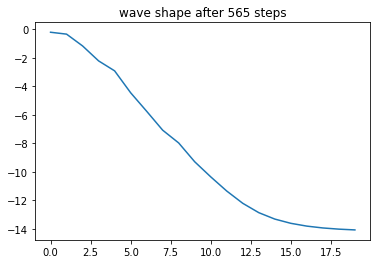

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_565/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_565/model_weights.tf
generator loss:1.976220104896531
-----------------------


566it [35:58,  5.29s/it]

total discriminator loss:0.3078717185020443
average true return:0.5068687238124281
-----------------------
Training Step: 566
generator loss:1.9975108519772127
-----------------------


567it [36:00,  4.28s/it]

total discriminator loss:0.3441837089145063
average true return:0.5083664307832236
-----------------------
Training Step: 567
generator loss:2.010185129253334
-----------------------


568it [36:02,  3.58s/it]

total discriminator loss:0.3350511615652032
average true return:0.5075134135567659
-----------------------
Training Step: 568
generator loss:2.027380906787621
-----------------------


569it [36:04,  3.09s/it]

total discriminator loss:0.3258665351728619
average true return:0.505264505331767
-----------------------
Training Step: 569
generator loss:2.0435032435913687
-----------------------


570it [36:06,  2.74s/it]

total discriminator loss:0.304090648651974
average true return:0.5050339331701432
-----------------------
Training Step: 570
event_types: [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mad_score: 0.8520625
fid_score: 1442859.0985274592
rule_score: 0.0


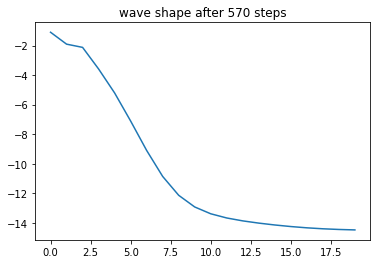

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_570/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_570/model_weights.tf
generator loss:2.058639056009193
-----------------------


571it [36:17,  5.19s/it]

total discriminator loss:0.32692723884990277
average true return:0.505484089455269
-----------------------
Training Step: 571
generator loss:2.075053234949536
-----------------------


572it [36:19,  4.22s/it]

total discriminator loss:0.3170828970740186
average true return:0.5055122304411054
-----------------------
Training Step: 572
generator loss:2.0882307557844952
-----------------------


573it [36:21,  3.54s/it]

total discriminator loss:0.33390671469170946
average true return:0.503717201807342
-----------------------
Training Step: 573
generator loss:2.1090950162018767
-----------------------


574it [36:23,  3.06s/it]

total discriminator loss:0.3085069829625755
average true return:0.5035272664040586
-----------------------
Training Step: 574
generator loss:2.1212516894979636
-----------------------


575it [36:25,  2.72s/it]

total discriminator loss:0.30900295420553203
average true return:0.5036842341380985
-----------------------
Training Step: 575
event_types: [3, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mad_score: 0.8546625
fid_score: 1551372.2709459048
rule_score: 0.0


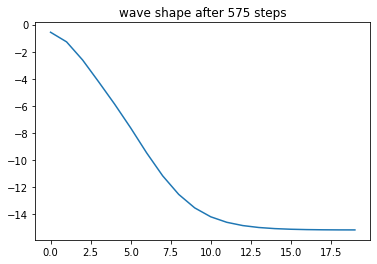

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_575/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_575/model_weights.tf
generator loss:2.137352497626982
-----------------------


576it [36:36,  5.17s/it]

total discriminator loss:0.2975159034252368
average true return:0.5037007638853578
-----------------------
Training Step: 576
generator loss:2.14821720635236
-----------------------


577it [36:38,  4.20s/it]

total discriminator loss:0.2914013512209006
average true return:0.5006805325011846
-----------------------
Training Step: 577
generator loss:2.171112500666573
-----------------------


578it [36:39,  3.53s/it]

total discriminator loss:0.334721372840428
average true return:0.502975632586457
-----------------------
Training Step: 578
generator loss:2.1875602715696476
-----------------------


579it [36:41,  3.06s/it]

total discriminator loss:0.32568221927671726
average true return:0.4998602139404711
-----------------------
Training Step: 579
generator loss:2.1885098677039916
-----------------------


580it [36:43,  2.74s/it]

total discriminator loss:0.33957647214115094
average true return:0.49993617549529124
-----------------------
Training Step: 580
event_types: [0, 0, 1, 2, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mad_score: 0.8531375
fid_score: 1640889.4931739387
rule_score: 0.0


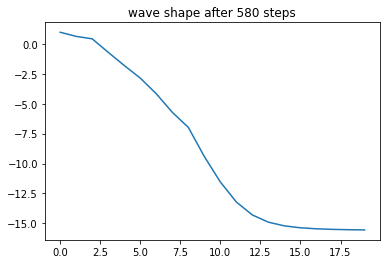

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_580/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_580/model_weights.tf
generator loss:2.2126397802967874
-----------------------


581it [36:54,  5.21s/it]

total discriminator loss:0.30717892201628394
average true return:0.501144701632688
-----------------------
Training Step: 581
generator loss:2.2288319950541937
-----------------------


582it [36:56,  4.23s/it]

total discriminator loss:0.2939559171401308
average true return:0.49925568959853994
-----------------------
Training Step: 582
generator loss:2.2346978888359006
-----------------------


583it [36:58,  3.55s/it]

total discriminator loss:0.3148682523750084
average true return:0.5007689436189585
-----------------------
Training Step: 583
generator loss:2.2514875346569694
-----------------------


584it [37:00,  3.06s/it]

total discriminator loss:0.28723038062240003
average true return:0.49865800904837776
-----------------------
Training Step: 584
generator loss:2.261397205335294
-----------------------


585it [37:02,  2.74s/it]

total discriminator loss:0.26871193902157425
average true return:0.4987575095759327
-----------------------
Training Step: 585
event_types: [2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mad_score: 0.8538875
fid_score: 1732582.1772349472
rule_score: 0.0


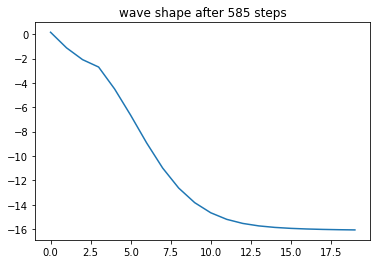

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_585/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_585/model_weights.tf
generator loss:2.2811139641829024
-----------------------


586it [37:14,  5.31s/it]

total discriminator loss:0.30941802267133167
average true return:0.5003627888960043
-----------------------
Training Step: 586
generator loss:2.2917382121631826
-----------------------


587it [37:15,  4.29s/it]

total discriminator loss:2.0784496194242523
average true return:0.49978517449242504
-----------------------
Training Step: 587
generator loss:2.254694696309129
-----------------------


588it [37:17,  3.58s/it]

total discriminator loss:0.3093787986434089
average true return:0.4993179223198657
-----------------------
Training Step: 588
generator loss:2.2339522581844724
-----------------------


589it [37:19,  3.09s/it]

total discriminator loss:0.3065999760200879
average true return:0.4981394795133979
-----------------------
Training Step: 589
generator loss:2.192781928167522
-----------------------


590it [37:21,  2.74s/it]

total discriminator loss:0.3385698792879631
average true return:0.4978774627300257
-----------------------
Training Step: 590
event_types: [0, 2, 1, 0, 2, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mad_score: 0.85415
fid_score: 1818314.782778963
rule_score: 0.0


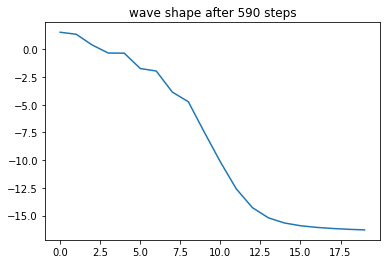

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_590/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_590/model_weights.tf
generator loss:2.1700704010205722
-----------------------


591it [37:32,  5.20s/it]

total discriminator loss:0.3288074773615821
average true return:0.5000692960011273
-----------------------
Training Step: 591
generator loss:2.148237033622216
-----------------------


592it [37:34,  4.22s/it]

total discriminator loss:0.3143635023053319
average true return:0.5003706576479736
-----------------------
Training Step: 592
generator loss:2.1281080767815266
-----------------------


593it [37:36,  3.54s/it]

total discriminator loss:0.33184912254086096
average true return:0.5040803197534073
-----------------------
Training Step: 593
generator loss:2.1105037221708236
-----------------------


594it [37:38,  3.07s/it]

total discriminator loss:0.32590655954276837
average true return:0.5007989740588837
-----------------------
Training Step: 594
generator loss:2.1019668758952057
-----------------------


595it [37:40,  2.86s/it]

total discriminator loss:1.9319957501931735
average true return:0.5020972584360901
-----------------------
Training Step: 595
event_types: [2, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mad_score: 0.8559375
fid_score: 1910544.1304058544
rule_score: 0.0


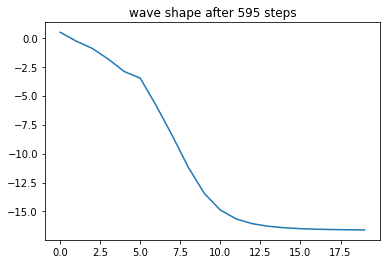

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_595/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_595/model_weights.tf
generator loss:2.0534282476749546
-----------------------


596it [37:52,  5.39s/it]

total discriminator loss:0.32544523948998216
average true return:0.5039527906731713
-----------------------
Training Step: 596
generator loss:2.0146914941404437
-----------------------


597it [37:54,  4.35s/it]

total discriminator loss:0.34049818610097693
average true return:0.5009069206895498
-----------------------
Training Step: 597
generator loss:1.979843275539213
-----------------------


598it [37:56,  3.64s/it]

total discriminator loss:0.3271535266196393
average true return:0.5042949673755814
-----------------------
Training Step: 598
generator loss:1.9399131680273929
-----------------------


599it [37:58,  3.13s/it]

total discriminator loss:0.34933877481005005
average true return:0.5049475139835173
-----------------------
Training Step: 599
generator loss:1.919584550454017
-----------------------


600it [37:59,  2.77s/it]

total discriminator loss:0.3085836376122839
average true return:0.5057094810217015
-----------------------
Training Step: 600
event_types: [1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mad_score: 0.852425
fid_score: 1977969.6190142639
rule_score: 0.0


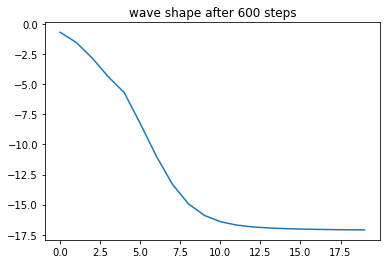

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_600/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_600/model_weights.tf
generator loss:1.8974026852309338
-----------------------


601it [38:10,  5.23s/it]

total discriminator loss:0.33173670115290266
average true return:0.5044747385999407
-----------------------
Training Step: 601
generator loss:1.8792694079139374
-----------------------


602it [38:12,  4.24s/it]

total discriminator loss:0.33413467050660955
average true return:0.5066358201300327
-----------------------
Training Step: 602
generator loss:1.8712760510183812
-----------------------


603it [38:14,  3.55s/it]

total discriminator loss:0.3566140519494743
average true return:0.5096076331108973
-----------------------
Training Step: 603
generator loss:1.8551438504257514
-----------------------


604it [38:16,  3.07s/it]

total discriminator loss:0.3307116923490855
average true return:0.507436812364422
-----------------------
Training Step: 604
generator loss:1.8511070646618522
-----------------------


605it [38:18,  2.73s/it]

total discriminator loss:0.3452007212103477
average true return:0.5065995905044407
-----------------------
Training Step: 605
event_types: [1, 2, 2, 1, 0, 2, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mad_score: 0.852675
fid_score: 2055693.7997277656
rule_score: 0.0


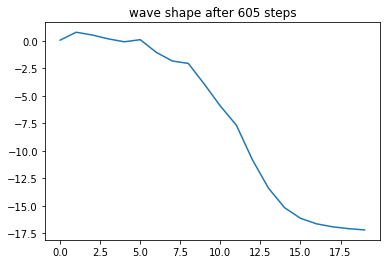

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_605/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_605/model_weights.tf
generator loss:1.8420755304771583
-----------------------
total discriminator loss:0.3313922484760544
average true return:0.5101086356559013
-----------------------


606it [38:29,  5.25s/it]

Training Step: 606
generator loss:1.8459163221520298
-----------------------


607it [38:31,  4.27s/it]

total discriminator loss:0.3173743819504027
average true return:0.5077291595163926
-----------------------
Training Step: 607
generator loss:1.852533106725955
-----------------------
total discriminator loss:0.3425804277390561
average true return:0.507118559965413
-----------------------


608it [38:33,  3.60s/it]

Training Step: 608
generator loss:1.8598820419618338
-----------------------


609it [38:35,  3.14s/it]

total discriminator loss:0.3411672389502281
average true return:0.50451679546647
-----------------------
Training Step: 609
generator loss:1.8595102736157625
-----------------------


610it [38:37,  2.78s/it]

total discriminator loss:0.32094266586711045
average true return:0.5070854074266826
-----------------------
Training Step: 610
event_types: [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mad_score: 0.8512625
fid_score: 2126056.1512208893
rule_score: 0.0


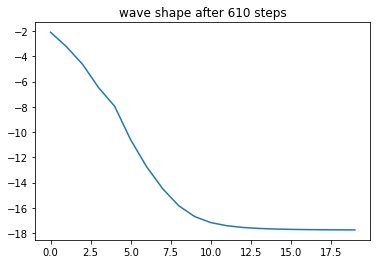

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_610/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_610/model_weights.tf
generator loss:1.872153349601986
-----------------------


611it [38:48,  5.25s/it]

total discriminator loss:0.3185392470797135
average true return:0.505536439026504
-----------------------
Training Step: 611
generator loss:1.8807758366763114
-----------------------


612it [38:50,  4.26s/it]

total discriminator loss:0.3332009771124963
average true return:0.5046207351894865
-----------------------
Training Step: 612
generator loss:1.8990159470039143
-----------------------


613it [38:52,  3.57s/it]

total discriminator loss:0.3190714240909719
average true return:0.5039385455020321
-----------------------
Training Step: 613
generator loss:1.9107239883684821
-----------------------


614it [38:54,  3.08s/it]

total discriminator loss:0.3317085588413323
average true return:0.5039784114712648
-----------------------
Training Step: 614
generator loss:1.92387655780208
-----------------------


615it [38:56,  2.75s/it]

total discriminator loss:0.3155267395828116
average true return:0.5026407334379094
-----------------------
Training Step: 615
event_types: [3, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mad_score: 0.8520625
fid_score: 2219931.0989465155
rule_score: 0.0


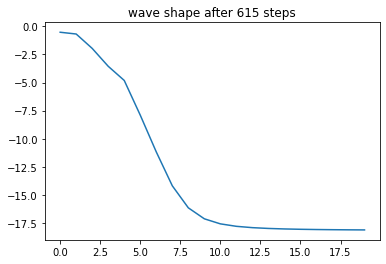

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_615/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_615/model_weights.tf
generator loss:1.9404840774844212
-----------------------


616it [39:07,  5.29s/it]

total discriminator loss:0.30885777312082296
average true return:0.5041794436103799
-----------------------
Training Step: 616
generator loss:1.9543492303858032
-----------------------


617it [39:09,  4.29s/it]

total discriminator loss:0.3251999074471211
average true return:0.5031089700704205
-----------------------
Training Step: 617
generator loss:1.9694736544064555
-----------------------


618it [39:11,  3.58s/it]

total discriminator loss:0.33042033416104966
average true return:0.5038759020084504
-----------------------
Training Step: 618
generator loss:1.99011260870713
-----------------------


619it [39:13,  3.10s/it]

total discriminator loss:0.33134755107548297
average true return:0.5024239375963481
-----------------------
Training Step: 619
generator loss:1.9989078316065187
-----------------------


620it [39:15,  2.75s/it]

total discriminator loss:0.344868943960302
average true return:0.5060003454234986
-----------------------
Training Step: 620
event_types: [2, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mad_score: 0.8521125
fid_score: 2296479.153700511
rule_score: 0.0


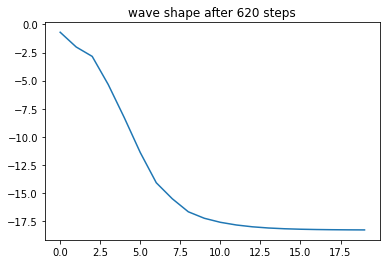

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_620/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_620/model_weights.tf
generator loss:2.0209995473836067
-----------------------


621it [39:26,  5.25s/it]

total discriminator loss:0.3077042178021019
average true return:0.5007067517698531
-----------------------
Training Step: 621
generator loss:2.031220705101389
-----------------------


622it [39:29,  4.38s/it]

total discriminator loss:0.32573656310163157
average true return:0.5012404918206963
-----------------------
Training Step: 622
generator loss:2.0566596627690035
-----------------------


623it [39:31,  3.65s/it]

total discriminator loss:0.31329473823134435
average true return:0.5021911080126477
-----------------------
Training Step: 623
generator loss:2.061308892759352
-----------------------


624it [39:33,  3.14s/it]

total discriminator loss:0.3107661436676752
average true return:0.5006057363140292
-----------------------
Training Step: 624
generator loss:2.083810730052729
-----------------------


625it [39:35,  2.79s/it]

total discriminator loss:0.3097395906159394
average true return:0.4996515625954431
-----------------------
Training Step: 625
event_types: [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]
mad_score: 0.851325
fid_score: 2350485.824852367
rule_score: 0.0


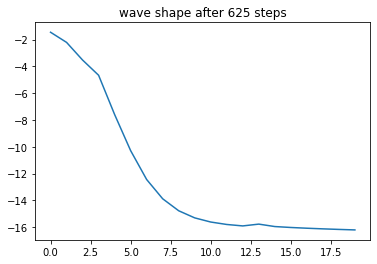

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_625/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_625/model_weights.tf
generator loss:2.098143713907655
-----------------------


626it [39:46,  5.29s/it]

total discriminator loss:0.3098251431636372
average true return:0.5013066869503857
-----------------------
Training Step: 626
generator loss:2.118208762781382
-----------------------


627it [39:48,  4.29s/it]

total discriminator loss:0.32040130652709753
average true return:0.499688383204915
-----------------------
Training Step: 627
generator loss:2.1234201658237173
-----------------------


628it [39:50,  3.60s/it]

total discriminator loss:0.31431437767364334
average true return:0.499129891374005
-----------------------
Training Step: 628
generator loss:2.1435620200371246
-----------------------


629it [39:52,  3.11s/it]

total discriminator loss:0.30168538249000537
average true return:0.5005484852950427
-----------------------
Training Step: 629
generator loss:2.159534043917319
-----------------------


630it [39:54,  2.77s/it]

total discriminator loss:0.2976040353772579
average true return:0.501112773105975
-----------------------
Training Step: 630
event_types: [2, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mad_score: 0.8491125
fid_score: 2415493.565971188
rule_score: 0.0


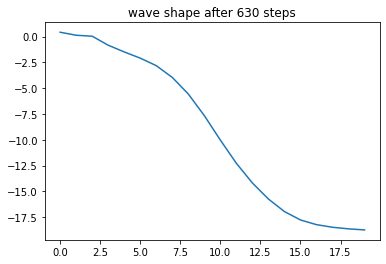

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_630/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_630/model_weights.tf
generator loss:2.1742900358805866
-----------------------


631it [40:05,  5.36s/it]

total discriminator loss:0.3083569211980489
average true return:0.5020997814039717
-----------------------
Training Step: 631
generator loss:2.1868889879016495
-----------------------


632it [40:07,  4.35s/it]

total discriminator loss:0.31260762716749035
average true return:0.4989898062382142
-----------------------
Training Step: 632
generator loss:2.2001122389698127
-----------------------


633it [40:09,  3.64s/it]

total discriminator loss:0.3338657158185145
average true return:0.5028564811351213
-----------------------
Training Step: 633
generator loss:2.212192821647216
-----------------------


634it [40:11,  3.14s/it]

total discriminator loss:0.32830209381429193
average true return:0.5007422917792469
-----------------------
Training Step: 634
generator loss:2.2332350070269227
-----------------------


635it [40:13,  2.79s/it]

total discriminator loss:0.309470769627005
average true return:0.4966497363110456
-----------------------
Training Step: 635
event_types: [2, 2, 1, 0, 2, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mad_score: 0.8495375
fid_score: 2497645.6095008026
rule_score: 0.0


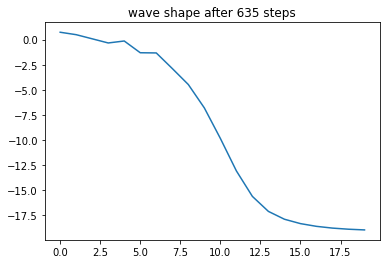

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_635/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_635/model_weights.tf
generator loss:2.2323973356490816
-----------------------


636it [40:24,  5.29s/it]

total discriminator loss:0.343431971111708
average true return:0.49904138287138433
-----------------------
Training Step: 636
generator loss:2.249985493569775
-----------------------


637it [40:26,  4.29s/it]

total discriminator loss:0.32096662010777854
average true return:0.497463438293296
-----------------------
Training Step: 637
generator loss:2.2622553869248407
-----------------------


638it [40:28,  3.58s/it]

total discriminator loss:0.31710276019409983
average true return:0.49957410682497977
-----------------------
Training Step: 638
generator loss:2.264478802253721
-----------------------


639it [40:30,  3.10s/it]

total discriminator loss:0.32497462516810627
average true return:0.4978439067623831
-----------------------
Training Step: 639
generator loss:2.272556732166093
-----------------------


640it [40:32,  2.75s/it]

total discriminator loss:0.29927329302100203
average true return:0.4986748537639888
-----------------------
Training Step: 640
event_types: [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mad_score: 0.8464875
fid_score: 2548342.0313267265
rule_score: 0.0


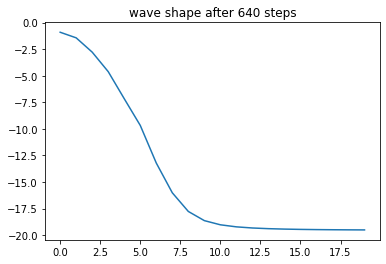

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_640/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_640/model_weights.tf
generator loss:2.2854907403861193
-----------------------


641it [40:43,  5.22s/it]

total discriminator loss:0.335879056078751
average true return:0.5006464356797063
-----------------------
Training Step: 641
generator loss:2.2871283997940304
-----------------------


642it [40:45,  4.24s/it]

total discriminator loss:0.3053720613770734
average true return:0.4969631131270121
-----------------------
Training Step: 642
generator loss:2.2922495439747026
-----------------------


643it [40:47,  3.55s/it]

total discriminator loss:0.32471310995361186
average true return:0.4969557643354034
-----------------------
Training Step: 643
generator loss:2.284681552208532
-----------------------


644it [40:49,  3.07s/it]

total discriminator loss:0.3303453513973311
average true return:0.49968931238970854
-----------------------
Training Step: 644
generator loss:2.2928488894691363
-----------------------


645it [40:51,  2.77s/it]

total discriminator loss:2.0632565459199945
average true return:0.49907077412075995
-----------------------
Training Step: 645
event_types: [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mad_score: 0.8480375
fid_score: 2627200.698522549
rule_score: 0.00025


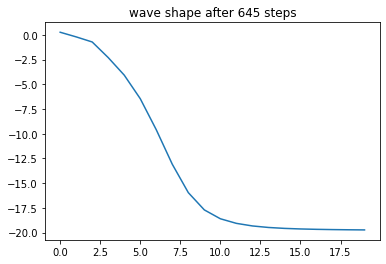

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_645/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_645/model_weights.tf
generator loss:2.273704191353243
-----------------------


646it [41:02,  5.26s/it]

total discriminator loss:0.34031822049279475
average true return:0.4974718868266828
-----------------------
Training Step: 646
generator loss:2.2557515286073633
-----------------------


647it [41:04,  4.26s/it]

total discriminator loss:0.3476530761820946
average true return:0.49880114555272964
-----------------------
Training Step: 647
generator loss:2.227805349987227
-----------------------


648it [41:06,  3.57s/it]

total discriminator loss:0.31443922804487345
average true return:0.5014634975004322
-----------------------
Training Step: 648
generator loss:2.1889072537767014
-----------------------


649it [41:08,  3.09s/it]

total discriminator loss:0.3059904526571029
average true return:0.497988372676315
-----------------------
Training Step: 649
generator loss:2.178759165413482
-----------------------


650it [41:10,  2.74s/it]

total discriminator loss:0.31510773894242206
average true return:0.5064715076936847
-----------------------
Training Step: 650
event_types: [2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mad_score: 0.84545
fid_score: 2679461.5866179424
rule_score: 0.0


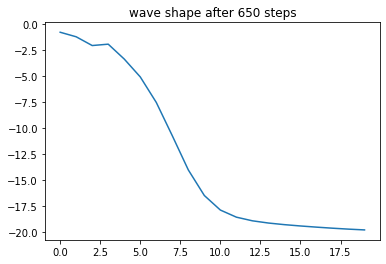

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_650/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_650/model_weights.tf
generator loss:2.153900765933175
-----------------------


651it [41:21,  5.32s/it]

total discriminator loss:0.29364680035245205
average true return:0.5002198892952096
-----------------------
Training Step: 651
generator loss:2.1369713245111077
-----------------------


652it [41:23,  4.31s/it]

total discriminator loss:0.3139581591976133
average true return:0.49908149609715247
-----------------------
Training Step: 652
generator loss:2.1432187750932794
-----------------------


653it [41:25,  3.60s/it]

total discriminator loss:0.32774158004321113
average true return:0.5010077808186063
-----------------------
Training Step: 653
generator loss:2.132190168400234
-----------------------


654it [41:27,  3.10s/it]

total discriminator loss:0.3139118375880482
average true return:0.5010159004126716
-----------------------
Training Step: 654
generator loss:2.113070493927318
-----------------------


655it [41:29,  2.75s/it]

total discriminator loss:0.3245555794847754
average true return:0.5036417401833355
-----------------------
Training Step: 655
event_types: [1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mad_score: 0.8435
fid_score: 2746907.5885939
rule_score: 0.00025


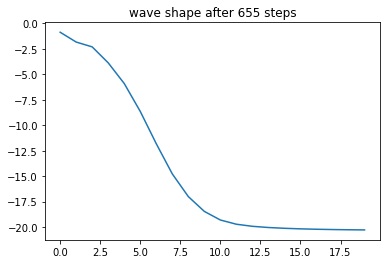

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_655/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_655/model_weights.tf
generator loss:2.116128774302425
-----------------------


656it [41:40,  5.21s/it]

total discriminator loss:0.29302774303897766
average true return:0.5011649051252536
-----------------------
Training Step: 656
generator loss:2.1142376382537913
-----------------------


657it [41:41,  4.23s/it]

total discriminator loss:0.303522298937917
average true return:0.5038150827236574
-----------------------
Training Step: 657
generator loss:2.120565533013967
-----------------------


658it [41:43,  3.54s/it]

total discriminator loss:0.3301869375291085
average true return:0.5022954342137396
-----------------------
Training Step: 658
generator loss:2.10013099794904
-----------------------


659it [41:45,  3.05s/it]

total discriminator loss:0.3366038710267518
average true return:0.5012871602419119
-----------------------
Training Step: 659
generator loss:2.11348596799787
-----------------------


660it [41:47,  2.73s/it]

total discriminator loss:0.3064141302402198
average true return:0.5012588671614882
-----------------------
Training Step: 660
event_types: [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mad_score: 0.8387625
fid_score: 2795263.6089830115
rule_score: 0.00025


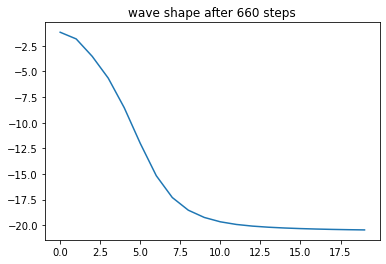

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_660/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_660/model_weights.tf
generator loss:2.097512816774451
-----------------------


661it [41:58,  5.24s/it]

total discriminator loss:0.3541874541316187
average true return:0.5024890531598529
-----------------------
Training Step: 661
generator loss:2.1233285537850035
-----------------------


662it [42:00,  4.25s/it]

total discriminator loss:0.32922400313885
average true return:0.5043921501679486
-----------------------
Training Step: 662
generator loss:2.122421126650533
-----------------------


663it [42:02,  3.55s/it]

total discriminator loss:0.30005689147860115
average true return:0.5017734527764042
-----------------------
Training Step: 663
generator loss:2.124084004589956
-----------------------


664it [42:04,  3.07s/it]

total discriminator loss:0.3101386815798536
average true return:0.5020593210674216
-----------------------
Training Step: 664
generator loss:2.111305416963756
-----------------------


665it [42:06,  2.73s/it]

total discriminator loss:0.32207150015062846
average true return:0.5035867307583359
-----------------------
Training Step: 665
event_types: [3, 2, 0, 2, 2, 2, 2, 2, 0, 3, 0, 2, 3, 0, 1, 1, 0, 1, 1, 1]
mad_score: 0.8358625
fid_score: 2841149.326449215
rule_score: 0.00075


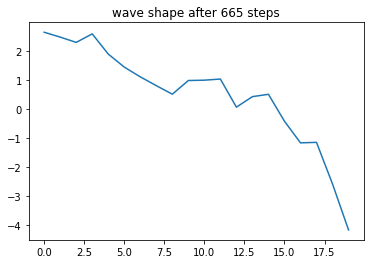

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_665/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_665/model_weights.tf
generator loss:2.1244438026290684
-----------------------


666it [42:17,  5.18s/it]

total discriminator loss:0.30036999905550377
average true return:0.5057473928110099
-----------------------
Training Step: 666
generator loss:2.1297017150094892
-----------------------


667it [42:19,  4.20s/it]

total discriminator loss:0.3073676069409516
average true return:0.49980039129459025
-----------------------
Training Step: 667
generator loss:2.131499699220047
-----------------------


668it [42:21,  3.53s/it]

total discriminator loss:0.3138550281044875
average true return:0.5031920264976748
-----------------------
Training Step: 668
generator loss:2.134082493370502
-----------------------
total discriminator loss:0.31861533487315186
average true return:0.5006020962647906
-----------------------


669it [42:23,  3.08s/it]

Training Step: 669
generator loss:2.124861830059097
-----------------------


670it [42:25,  2.78s/it]

total discriminator loss:0.30834816661013953
average true return:0.5025601187159171
-----------------------
Training Step: 670
event_types: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]
mad_score: 0.836375
fid_score: 2939162.29201541
rule_score: 0.00025


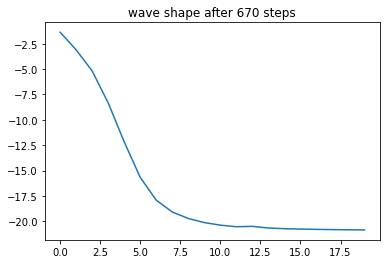

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_670/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_670/model_weights.tf
generator loss:2.143365889174537
-----------------------


671it [42:36,  5.19s/it]

total discriminator loss:0.3285543461957652
average true return:0.5014763723281024
-----------------------
Training Step: 671
generator loss:2.1568525824401723
-----------------------


672it [42:38,  4.21s/it]

total discriminator loss:1.9632295570202098
average true return:0.5016700590639219
-----------------------
Training Step: 672
generator loss:2.1246857265458656
-----------------------
total discriminator loss:0.3114913045175698
average true return:0.5028528679358283
-----------------------


673it [42:40,  3.60s/it]

Training Step: 673
generator loss:2.11142558653895
-----------------------
total discriminator loss:0.30789545523341655
average true return:0.50311453408402
-----------------------


674it [42:43,  3.37s/it]

Training Step: 674
generator loss:2.096527039406034
-----------------------
total discriminator loss:0.32804953720557484
average true return:0.5031394880974469
-----------------------


675it [42:46,  3.20s/it]

Training Step: 675
event_types: [2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mad_score: 0.8333
fid_score: 2996494.658840681
rule_score: 0.00025


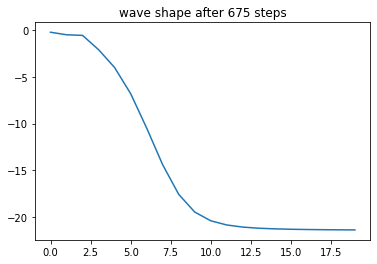

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_675/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_675/model_weights.tf
generator loss:2.077296160876024
-----------------------


676it [42:58,  6.04s/it]

total discriminator loss:0.32032674151058194
average true return:0.5003986856712508
-----------------------
Training Step: 676
generator loss:2.0813172366109463
-----------------------


677it [43:00,  4.81s/it]

total discriminator loss:0.34597716568878456
average true return:0.5005104720433868
-----------------------
Training Step: 677
generator loss:2.060549530079018
-----------------------


678it [43:02,  3.94s/it]

total discriminator loss:0.35006526590518094
average true return:0.508123013663847
-----------------------
Training Step: 678
generator loss:2.0460089761527955
-----------------------


679it [43:04,  3.34s/it]

total discriminator loss:0.33261330525702065
average true return:0.5014139667063597
-----------------------
Training Step: 679
generator loss:2.014149005663889
-----------------------


680it [43:06,  2.92s/it]

total discriminator loss:0.316901190835035
average true return:0.5039177970561302
-----------------------
Training Step: 680
event_types: [3, 2, 2, 2, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mad_score: 0.83075
fid_score: 3060229.3754498214
rule_score: 0.001


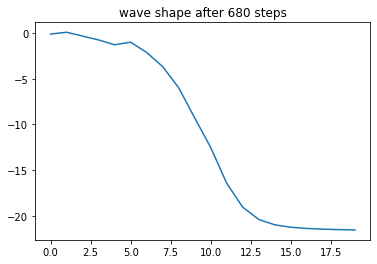

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_680/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_680/model_weights.tf
generator loss:2.027944735453646
-----------------------


681it [43:17,  5.42s/it]

total discriminator loss:0.32122758796696393
average true return:0.5058317644331566
-----------------------
Training Step: 681
generator loss:2.013728424507198
-----------------------


682it [43:19,  4.38s/it]

total discriminator loss:0.3053440957819146
average true return:0.5033262207533473
-----------------------
Training Step: 682
generator loss:2.023614297850547
-----------------------


683it [43:21,  3.64s/it]

total discriminator loss:0.3250322351628959
average true return:0.4993462887613348
-----------------------
Training Step: 683
generator loss:2.013041216244691
-----------------------


684it [43:23,  3.13s/it]

total discriminator loss:0.3302978272732039
average true return:0.5034985871026859
-----------------------
Training Step: 684
generator loss:2.027741514123708
-----------------------


685it [43:25,  2.78s/it]

total discriminator loss:0.337391971335512
average true return:0.49945132357265787
-----------------------
Training Step: 685
event_types: [1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mad_score: 0.8255625
fid_score: 3124665.925254898
rule_score: 0.00125


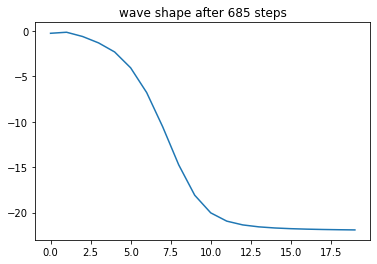

G saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/G_685/model_weights.tf
D saved to: /home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-09-39-43/D_685/model_weights.tf
generator loss:2.022139877986195
-----------------------
total discriminator loss:0.3355507341775019
average true return:0.5048028352584653
-----------------------


686it [43:38,  5.93s/it]

Training Step: 686
generator loss:2.013596603065513
-----------------------
total discriminator loss:0.30196045103301294
average true return:0.5061497550383861
-----------------------


687it [43:41,  4.95s/it]

Training Step: 687
generator loss:2.0279934630562857
-----------------------
total discriminator loss:0.3367831114494457
average true return:0.5026452000438352
-----------------------


688it [43:43,  4.17s/it]

Training Step: 688
generator loss:2.026743686047821
-----------------------


689it [43:46,  3.64s/it]

total discriminator loss:0.33158612908925444
average true return:0.5022830523508042
-----------------------
Training Step: 689
generator loss:2.054112676593634
-----------------------


690it [43:48,  3.12s/it]

total discriminator loss:1.8676158393588935
average true return:0.5049113190814623
-----------------------
Training Step: 690


690it [43:52,  3.81s/it]


KeyboardInterrupt: 

In [413]:
for feature_batch, _ in tqdm(train_dataset.take(_TOTAL_STEPS)):
    event_type_batch, time_delta_batch = feature_batch
    print('Training Step:', step)
    
    if step % 5 == 0:
        _mad_score, _fid_score, _rule_score = track_training(step, G, model_save_path, verbose=True, plot=True)
        mad_history.append(_mad_score)
        fid_history.append(_fid_score)
        rule_history.append(_rule_score)
        
    # train the generator
    for _ in range(_G_STEPS):
        gen_loss = train_generator_gumbel(G, D, BATCH_SIZE, T, verbose=True, optimizer=G_optimizer)
        gen_loss_history.append(gen_loss.numpy())
    
    # train the discriminator
    for _ in range(_D_STEPS):
        disc_loss, ave_true_return = train_discriminator_gumbel(event_type_batch, time_delta_batch, G, D, BATCH_SIZE, T,
                                                                verbose=True, optimizer=D_optimizer, 
                                                                label_smoothing=True, label_flipping=True)
        disc_loss_history.append(disc_loss.numpy())
        average_true_return_history.append(ave_true_return.numpy())
                
    step += 1

Text(0.5, 0, 'Training steps')

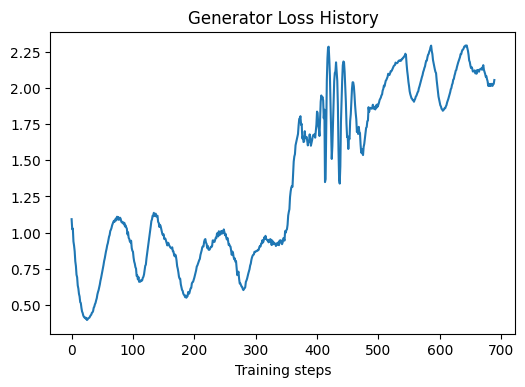

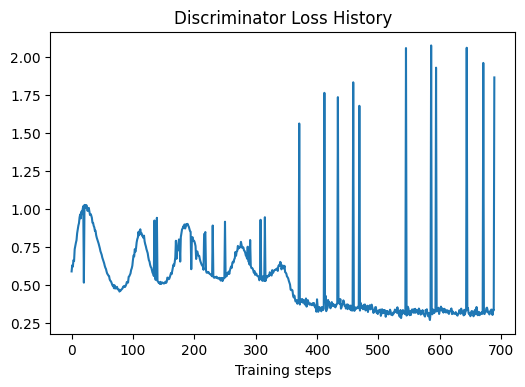

In [414]:
x = range(len(gen_loss_history))
plt.figure(dpi=100)
plt.plot(x, gen_loss_history)
plt.title('Generator Loss History')
plt.xlabel('Training steps')

x = range(len(disc_loss_history))
plt.figure(dpi=100)
plt.plot(x, disc_loss_history)
plt.title('Discriminator Loss History')
plt.xlabel('Training steps')

Text(0.5, 0, 'Training steps')

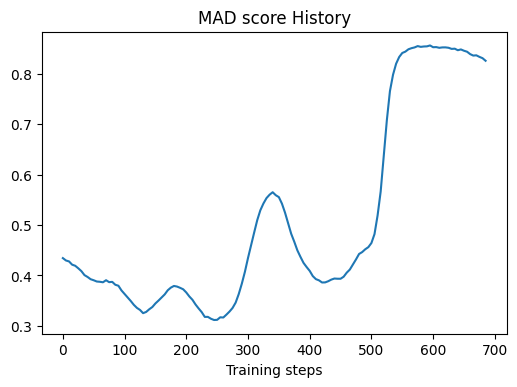

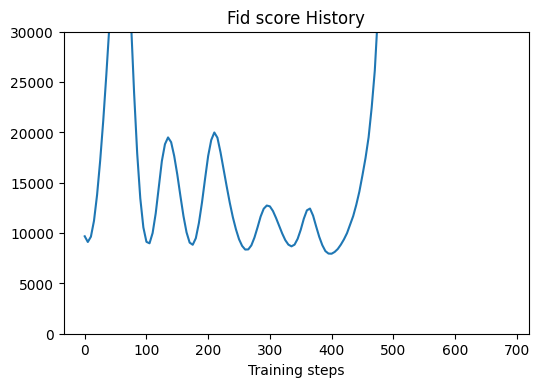

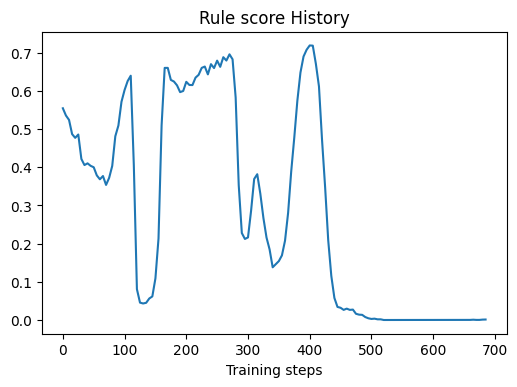

In [417]:
x =  [i * 5 for i in range(len(mad_history))]
plt.figure(dpi=100)
plt.plot(x, mad_history)
plt.title('MAD score History')
plt.xlabel('Training steps')

x =  [i * 5 for i in range(len(fid_history))]
plt.figure(dpi=100)
plt.plot(x, fid_history)
plt.title('Fid score History')
plt.xlabel('Training steps')
plt.ylim([0, 30000])

x =  [i * 5 for i in range(len(rule_history))]
plt.figure(dpi=100)
plt.plot(x, rule_history)
plt.title('Rule score History')
plt.xlabel('Training steps')

## Compare between G0, G1 and G2

In [356]:
from matplotlib import pyplot as plt

def get_generation_metrics(G):
    _gen_seqs_et, _gen_seqs_ts = generate_sequences_gumbel(N_DATA, G, BATCH_SIZE, T)

    # convert one-hot event types to indices; convert normalized timestamps to original
    _gen_seqs_et_ind = tf.argmax(_gen_seqs_et, axis=2).numpy().reshape(N_DATA, T, 1)
    _gen_seqs_ts_ori = apply_mean_std(_gen_seqs_ts, GLOBAL_MEAN, GLOBAL_STD)
    _gen_seqs_for_rules = np.dstack((_gen_seqs_et_ind, _gen_seqs_ts_ori))

    _mad_score = calculate_MAD_score(_gen_seqs_et_ind)
    _fid_score = calculate_FID_score(_gen_seqs_ts_ori)
    _rule_score = calculate_rule_score(_gen_seqs_for_rules)
    return {'mad' : _mad_score, 'fid' : _fid_score, 'oracle' : _rule_score}

In [362]:
G0 = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

res0 = get_generation_metrics(G0)

In [363]:
G1 = pretrained_generator

res1 = get_generation_metrics(G1)

In [364]:
G2 = G

res2 = get_generation_metrics(G2)

In [373]:
res = [res0, res1, res2]

df = pd.DataFrame(res)
df.index = pd.Index(['INIT', 'MLE', 'GAN'])
df

,mad,fid,oracle
INIT,0.504625,11333.160976,0.1675
MLE,0.429113,9743.398414,0.5400
GAN,0.383238,9569.344552,0.7025


## Generate Synthesized data

In [353]:
G_save_path = '/home/lun//project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/2021-03-30-08-55-33/G_115/model_weights.tf'

In [354]:
G = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

G.build(input_shape=((BATCH_SIZE, T, 1)))
G.load_weights(G_save_path)
G.summary()

Model: "model_78"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(256, None, 4)]     0                                            
__________________________________________________________________________________________________
dense_emb (Dense)               (256, None, 16)      80          event_type[0][0]                 
__________________________________________________________________________________________________
time_delta_in (InputLayer)      [(256, None, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_concat_78 (TensorFl [(256, None, 17)]    0           dense_emb[0][0]                  
                                                                 time_delta_in[0][0]       

In [164]:
G_100 = G2
raw_seqs_trained_et_100, raw_seqs_trained_ts_100 = generate_sequences_gumbel(400000, G_100, BATCH_SIZE, T)

In [165]:
seqs_save_et_100 = tf.argmax(raw_seqs_trained_et_100[:400000, :, :], axis=2)
seqs_save_ts_100 = apply_mean_std(raw_seqs_trained_ts_100[:400000, :, :], *get_mean_std(raw_pos_timestamp_seqs))

In [169]:
import pickle

pos_seqs_filename_et = 'syn_positive_type_sequences.pickle'
pos_seqs_filename_ts = 'syn_positive_time_sequences.pickle'

repo_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/"

with open(os.path.join(repo_path, 'syn_data', 'gumbel_softmax_100it', pos_seqs_filename_et), 'wb') as f:
    pickle.dump(seqs_save_et_100, f)
    
with open(os.path.join(repo_path, 'syn_data', 'gumbel_softmax_100it', pos_seqs_filename_ts), 'wb') as f:
    pickle.dump(seqs_save_ts_100, f)

In [161]:
seqs_save_et_100[:10]

<tf.Tensor: shape=(10, 20), dtype=int64, numpy=
array([[2, 3, 1, 2, 3, 3, 1, 0, 2, 0, 2, 3, 2, 2, 2, 0, 0, 2, 1, 3],
       [1, 0, 2, 0, 2, 2, 0, 1, 1, 1, 0, 3, 2, 0, 0, 1, 3, 0, 3, 1],
       [2, 0, 3, 3, 2, 0, 3, 1, 3, 0, 0, 0, 2, 3, 0, 3, 0, 1, 0, 1],
       [1, 3, 3, 2, 3, 3, 1, 3, 2, 2, 2, 1, 0, 1, 1, 0, 1, 1, 1, 1],
       [2, 1, 3, 1, 2, 0, 1, 0, 0, 1, 3, 3, 0, 0, 3, 0, 2, 0, 0, 1],
       [3, 1, 3, 3, 0, 3, 1, 1, 3, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, 1],
       [0, 1, 2, 1, 0, 1, 0, 2, 3, 0, 0, 0, 3, 1, 1, 0, 2, 0, 1, 0],
       [3, 2, 1, 1, 3, 3, 1, 3, 1, 3, 1, 0, 0, 0, 2, 1, 2, 3, 0, 1],
       [0, 3, 3, 1, 1, 0, 2, 2, 3, 3, 1, 0, 3, 1, 3, 2, 1, 3, 2, 2],
       [0, 1, 1, 2, 0, 3, 3, 0, 0, 3, 1, 1, 2, 3, 1, 0, 0, 3, 3, 0]])>

In [162]:
seqs_save_ts_100[:10]

<tf.Tensor: shape=(10, 20, 1), dtype=float64, numpy=
array([[[26.28347012],
        [30.71878761],
        [32.31629063],
        [33.14737885],
        [33.66082748],
        [35.05677763],
        [36.41802661],
        [35.58768993],
        [37.22724401],
        [36.85090879],
        [37.61664908],
        [37.76648525],
        [37.89271309],
        [36.70663829],
        [35.58097335],
        [33.90315138],
        [35.39667259],
        [36.21181891],
        [36.51476279],
        [34.62221017]],

       [[26.13454261],
        [30.35504255],
        [32.79624872],
        [35.03936894],
        [36.18738845],
        [37.3220686 ],
        [37.10721951],
        [37.4181661 ],
        [37.83315744],
        [36.28871581],
        [35.8244918 ],
        [36.46416446],
        [37.61382136],
        [36.7705122 ],
        [36.73860961],
        [36.53310435],
        [36.45036593],
        [36.11615577],
        [36.26013271],
        [35.71212021]],

       [[27.03273846],
